# Optically-dark short GRBs

**Caden Gobat**, The George Washington University

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, astropy.units as u
from matplotlib import ticker

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats, optimize

from src.xrt import XRT_lightcurve, get_photonIndex, get_temporalIndex, get_columnDensity

from asymmetric_uncertainty import a_u, UncertaintyArray

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")
log_mean = lambda x1,x2 : 10**np.mean((np.log10(x1),np.log10(x2)))
log_slope = lambda point1,point2 : np.log10(point2[1]/point1[1])/np.log10(point2[0]/point1[0])
Hz_per_keV = 241797944177033445

Main code has been moved to [`pipeline.ipynb`](./pipeline.ipynb). Running the cell below will perform the entire analysis and output the list of dark sGRBs.

In [3]:
error_B_ox  = True # whether to incorporate Δβₒₓ (due to temporal separation) in errors
restrictive = True # whether to use a permissive inequality cut (w.r.t. error bars) for determining darkness (<< vs. <)
max_dt      = 0.20 # maximum allowable temporal separation between optical and X-ray data points (%)

%run pipeline.ipynb

Finished xray.
Finished optical.
Finished Δβₒₓ.           
Using B_ox_w_err
211227A	 7
211221A	 11
211207A	 7
211106A	 1
211023B	 19
210919A	 2
210726A	 2
210725B	 3
210708A	 1
210704A	 3
210410A	 6
210323A	 12
201006A	 5
200907B	 3
200826A	 1
200716C	 1
200522A	 9
200411A	 9
200219A	 2
191031D	 2
190719C	 7
190627A	 13
181123B	 4
180727A	 8
180618A	 14
180418A	 98
180402A	 2
180204A	 12
170827A	 2
170822A	 14
170728B	 34
170728A	 4
170127B	 4
161004A	 14
161001A	 1
160927A	 6
160821B	 12
160624A	 4
160601A	 2
160525B	 8
160411A	 8
160408A	 9
160303A	 1
151229A	 12
151127A	 4
150831A	 6
150424A	 107
150423A	 6
150301A	 5
150120A	 3
150101B	 4
141212A	 7
140930B	 9
140903A	 13
140622A	 10
140516A	 1
131004A	 38
130912A	 33
130822A	 2
130603B	 34
130515A	 2
121226A	 16
120804A	 18
120630A	 1
120521A	 7
120305A	 5
111222A	 2
111121A	 9
111117A	 17
111020A	 4
110402A	 10
110112B	 1
110112A	 7
110106A	 17
101219A	 5
100816A	 17
100702A	 2
100625A	 2
100213A	 3
100206A	 1
100117A	 1
091109B	

## $\LaTeX$ table formatting

In [47]:
round_scientific = lambda number, places : float(f"%.{places}e"%number)

sample_df = sGRBs[['GRB', 'TriggerNumber', 'BAT T90[sec]', 'Redshift', 'Beta_X', 'Beta_X_neg', 'Beta_X_pos', 'N_H (intrinsic)']].copy()
sample_df.loc[sample_df["Beta_X"].notna(),"B_x"] = [a_u(*row[['Beta_X', 'Beta_X_pos', 'Beta_X_neg']]) for i,row in sample_df.loc[sample_df["Beta_X"].notna(),:].iterrows()]
# sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"] = [a_u(entry) for entry in sample_df.loc[sample_df["N_H (intrinsic)"].notna(),"N_H (intrinsic)"]]
sample_df.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'], axis=1, inplace=True)
sample_df.rename(columns={"B_x":"Beta_X","BAT T90[sec]":"T90","TriggerNumber":"Trigger"},inplace=True)

for i,row in sample_df.iterrows():
    bx = row["Beta_X"]
    nh = row["N_H (intrinsic)"]
    if pd.notna(nh):
#         rounded_nh = (round_scientific(number,3) for number in nh.items())
#         rounded_nh = a_u(*rounded_nh)
        sample_df.loc[i,"N_H (intrinsic)"] = a_u(round(nh.value/1e21,3),
                                                 round(nh.plus/1e21,3),
                                                 round(nh.minus/1e21,3))
    if pd.notna(bx):
        rounded_bx = (round(number,2) for number in bx.items())
        rounded_bx = a_u(*rounded_bx)
        sample_df.loc[i,"Beta_X"] = rounded_bx
table_str = sample_df.to_latex(index=False, columns=["GRB","Trigger","T90","Redshift","Beta_X","N_H (intrinsic)"],na_rep='---')

In [48]:
for line in table_str.split("\n")[4:-3]:
    grb,trig,t90,z,beta_orig,n_h_orig = line.split("&")
    n_h_orig = n_h_orig[:-2]
    if beta_orig.strip() != "---":
        beta = beta_orig
        beta = beta.replace(" (+","^{+")
        beta = beta.replace(", -","}_{-")
        beta = beta.replace(")","}")
        beta = beta.replace("±",r"\pm")
        table_str = table_str.replace(beta_orig," $"+beta.strip()+"$ ")
    if n_h_orig.strip() != "---":
        n_h = n_h_orig
        n_h = n_h.replace("(+","^{+")
        n_h = n_h.replace(", -","}_{-")
        n_h = n_h.replace(")","}")
        if "±" not in n_h:
            pass
#             print(n_h)
#             val,err = n_h.split()
#             n_h = "("+val+")"+err
        else:
            n_h = n_h.replace("±",r"\pm")
        table_str = table_str.replace(n_h_orig," $"+n_h.strip()+"$ ")
# table_str = table_str.replace("e+19",r"\times10^{19}")
# table_str = table_str.replace("e+20",r"\times10^{20}")
# table_str = table_str.replace("e+21",r"\times10^{21}")
# table_str = table_str.replace("e+22",r"\times10^{22}")
print(table_str)

\begin{tabular}{llllll}
\toprule
    GRB &                    Trigger &        T90 &              Redshift &               Beta\_X &        N\_H (intrinsic) \\
\midrule
211227A &                    1091101 &      83.79 &                   --- & $2.0^{+0.7}_{-0.6}$ & $2.9 ^{+1.8}_{-1.5}$ \\
211221A &                    1090472 &     671.67 &                   --- & $0.59^{+0.31}_{-0.29}$ & $9.0 ^{+4.0}_{-3.0}$ \\
211207A &                    1088376 &       3.73 &                 2.272 & $1.02^{+0.25}_{-0.24}$ & $15.7 ^{+11.5}_{-9.6}$ \\
211106A &                  BAT/GUANO &       1.75 &                   --- & $0.1^{+1.06}_{-0.42}$ & $0.0 ^{+3.43}_{-0.0}$ \\
211023B &                    1080859 &       1.30 &                 0.862 & $1.12^{+0.23}_{-0.21}$ & $0.9 ^{+0.6}_{-0.5}$ \\
210919A &                    1073893 &       0.16 &                   --- & $1.1^{+3.3}_{-1.1}$ & $1.1 ^{+24.7}_{-1.1}$ \\
210726A &                    1061687 &       0.39 &                   --- & $1.2^{+0

In [39]:
xtable = xrt_data[['GRB', 'Time', 'Tpos', 'Tneg', 'SpecFlux']].round(2).copy()
xtable["tx"] = [a_u(*row[["Time","Tpos","Tneg"]]) for i,row in xtable.iterrows()]
xtable["SpecFlux"] *= 1e6
xtable["Fx"] = [a_u(round(row["SpecFlux"].value,3),
                                      round(row["SpecFlux"].plus,3),
                                      round(row["SpecFlux"].minus,3)) for i,row in xtable.iterrows()]
print(xtable[["GRB","tx","Fx"]].to_latex(index=False).replace(" (","^{").replace(", ","}_{").replace(")","}$").replace("& ","& $"))

\begin{tabular}{lll}
\toprule
    GRB & $                                 tx & $                           Fx \\
\midrule
211227A & $               63.73^{+0.27}_{-0.25}$ & $   232.235^{+64.384}_{-57.996}$ \\
211227A & $               64.32^{+0.28}_{-0.32}$ & $    339.521^{+89.75}_{-80.209}$ \\
211227A & $               64.97^{+0.33}_{-0.37}$ & $   332.516^{+87.644}_{-78.003}$ \\
211227A & $                 65.6^{+0.39}_{-0.3}$ & $   270.464^{+71.232}_{-63.363}$ \\
211227A & $                66.34^{+0.3}_{-0.35}$ & $   308.861^{+81.381}_{-72.555}$ \\
211227A & $               67.01^{+0.34}_{-0.37}$ & $   286.421^{+75.734}_{-67.795}$ \\
211227A & $                       67.61 ± 0.26 & $  386.146^{+102.279}_{-91.863}$ \\
211227A & $                68.18^{+0.3}_{-0.31}$ & $   356.721^{+94.934}_{-85.831}$ \\
211227A & $               68.79^{+0.32}_{-0.31}$ & $   245.729^{+69.837}_{-64.217}$ \\
211227A & $                       69.44 ± 0.34 & $    255.889^{+73.044}_{-65.54}$ \\
211227A & $ 

In [9]:
print(pd.DataFrame(np.array([[grb,sum(xrt_data["GRB"]==grb),sum(all_optical["GRB"]==grb),sum(results["GRB"]==grb),sum(close_times["GRB"]==grb)] for grb in sGRBs["GRB"]]),
             columns=["GRB","X-ray points","Optical points","Temporal matches","Dark points"]).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
    GRB & X-ray points & Optical points & Temporal matches & Dark points \\
\midrule
211227A &          101 &              0 &                0 &           0 \\
211221A &           25 &              0 &                0 &           0 \\
211207A &           13 &              0 &                0 &           0 \\
211106A &            4 &              0 &                0 &           0 \\
211023B &           19 &              0 &                0 &           0 \\
210919A &            2 &              0 &                0 &           0 \\
210726A &           15 &              0 &                0 &           0 \\
210725B &           20 &              0 &                0 &           0 \\
210708A &           10 &              0 &                0 &           0 \\
210704A &            5 &             20 &                4 &           3 \\
210618A &            0 &              0 &                0 &           0 \\
210413B &            0 &              4 &      

## *Swift*-XRT lightcurve/spectrum demo

In [24]:
burst = "050603"
fluxdata = XRT_lightcurve(burst)
Gamma,mode = get_photonIndex(burst)
NH,mode = get_columnDensity(burst)

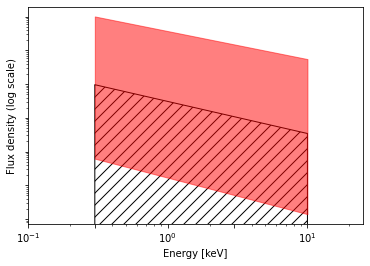

In [25]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

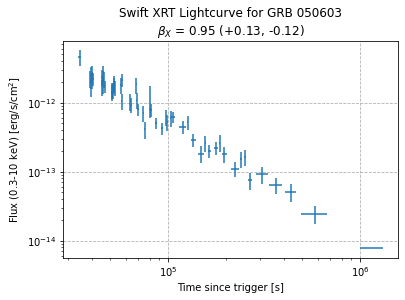

In [26]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,
             yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X$ = %s" % (burst,Gamma-1))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

## Filter transmission calculations

c:\users\caden gobat\appdata\local\programs\python\python38\lib\site-packages\pandas\io\parsers.py:765: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


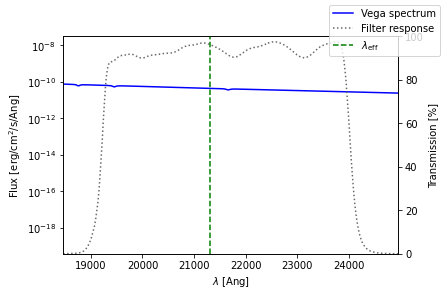

21303.690943444715

In [4]:
from src.fluxtools import effective_wavelength

# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt",header=None)
# I_filter.columns = ["Wavelength","Transmission"]
# I_filter["Wavelength"] *= 10
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_J["Wavelength"] *= 10000
MOSFIRE_J["Transmission"] *= 100

MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ",engine='python').iloc[:,:2]
MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
MOSFIRE_K["Wavelength"] *= 10000
MOSFIRE_K["Transmission"] *= 100

# REMIR_H = pd.read_csv("./data/REM/H.csv",header=None,names=["Wavelength","Transmission"])
# REMIR_H.sort_values(by="Wavelength",inplace=True)
# REMIR_H["Wavelength"] *= 10
# REMIR_r = pd.read_csv("./data/REM/r'.csv")
# REMIR_r.sort_values(by="Wavelength",inplace=True)
# REMIR_r["Wavelength"] *= 10

# LDSS3_i = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/i01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/r01.txt",
#                         header=None,names=["Wavelength","Transmission"])
# LDSS3_r["Wavelength"] *= 10 # nm to Ang

# IMACS_r_below = pd.read_csv("./data/Magellan/IMACS_r.csv",header=None)
# IMACS_r_below.columns = ["Wavelength","Transmission"]
# IMACS_r_below = IMACS_r_below[IMACS_r_below["Wavelength"]<600].copy()
# IMACS_r_below.sort_values(by="Wavelength",inplace=True)
# IMACS_r_below.drop_duplicates(subset=["Wavelength"],inplace=True)
# IMACS_r_above = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/imacs/imacs-filters/sloan_r_red01.txt",
#                               delimiter="\t",names=["Wavelength","Transmission"])
# IMACS_r = IMACS_r_below.append(IMACS_r_above,ignore_index=True)
# IMACS_r["Wavelength"] *= 10

effective_wavelength(MOSFIRE_K,show_plot=True)

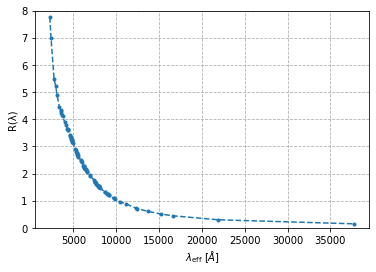

In [72]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"],fill_value="extrapolate") # function that takes a wavelength [Ang] and returns the corresponding R_b value

RbTable.drop([37,55,61,73],axis=0,inplace=True) # smoothing
RbTable.sort_values(by="lambda_eff",inplace=True) # sort in order of wavelength: UV -> IR
plt.plot(RbTable["lambda_eff"], RbTable["R_b"], ".--")
plt.xlabel("$\lambda_\mathrm{eff}$ [$\AA$]")
plt.ylabel("R(λ)")
plt.ylim(0,8)
plt.grid(linestyle="--")
# plt.savefig("./products/RbTable.png",bbox_inches="tight",dpi=300,)

## Plot dark GRBs' lightcurves

0 1 3


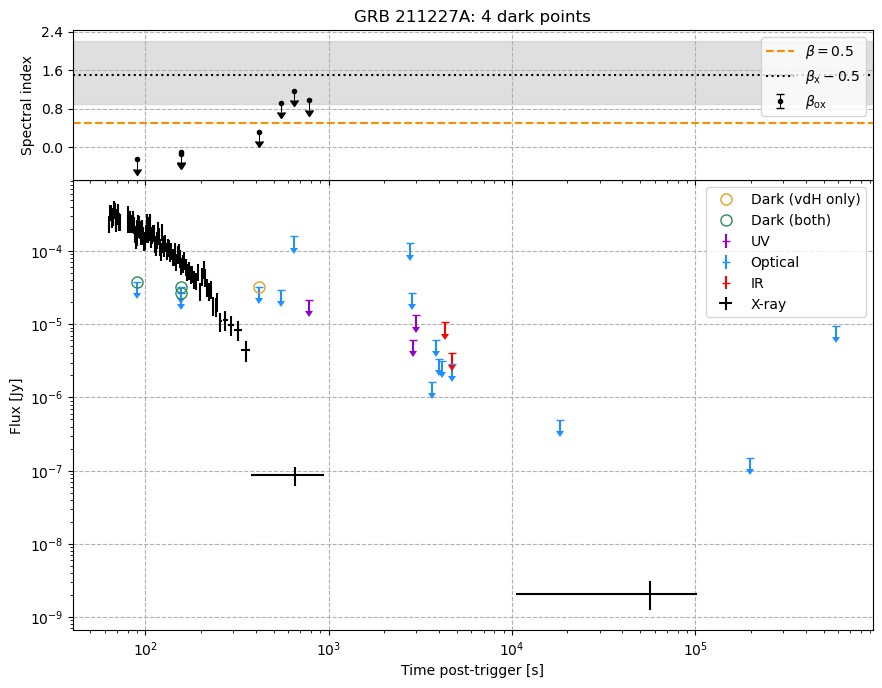

GRB     t_o       dt%  \
14  211227A   90.14  0.002865   
49  211227A  156.00  0.007854   
71  211227A  157.00  0.001495   
82  211227A  419.00  0.191221   
83  211227A  551.50  0.162239   
84  211227A  646.00  0.018687   
85  211227A  782.00  0.187905   

                                           B_ox_w_err               B_x     α  \
14  -0.25099302608658447 (+0.049333933712908624, -...  2.0 (+0.7, -0.6)  1.19   
49  -0.13267376352220342 (+0.045001752696141234, -...  2.0 (+0.7, -0.6)  2.30   
71  -0.10341966507580574 (+0.04297943211925725, -inf)  2.0 (+0.7, -0.6)  2.30   
82    0.3197416906818682 (+0.40491619429722603, -inf)  2.0 (+0.7, -0.6)  5.26   
83    0.9267124667895975 (+0.36723677405324184, -inf)  2.0 (+0.7, -0.6)  5.26   
84    1.1724417170377992 (+0.16337369690637318, -inf)  2.0 (+0.7, -0.6)  5.26   
85      0.9735765292430156 (+0.421222070169985, -inf)  2.0 (+0.7, -0.6)  5.26   

   Jak_dark vdH_dark  
14     True     True  
49     True     True  
71     True     True  
82    False     True  
83    False    False  
84    False    False  
85    False    False

8 0 0


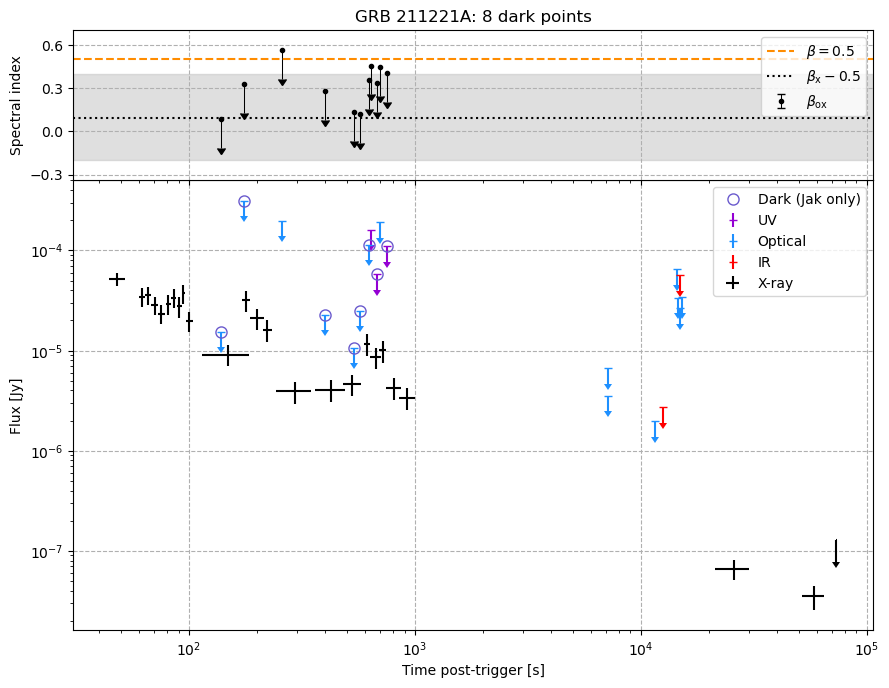

GRB    t_o       dt%  \
86   211221A  138.0  0.075687   
88   211221A  175.0  0.023470   
91   211221A  257.0  0.125255   
92   211221A  400.0  0.061601   
93   211221A  536.5  0.013258   
97   211221A  573.5  0.065969   
100  211221A  627.5  0.021979   
103  211221A  640.5  0.043151   
107  211221A  678.0  0.011797   
112  211221A  702.5  0.023785   
115  211221A  751.5  0.044307   

                                           B_ox_w_err                  B_x  \
86    0.08398172528223727 (+0.0507538576032077, -inf)  0.59 (+0.31, -0.29)   
88    0.3299092378008266 (+0.05376766483341545, -inf)  0.59 (+0.31, -0.29)   
91    0.5647537379200247 (+0.09235456442920667, -inf)  0.59 (+0.31, -0.29)   
92   0.27982462842422573 (+0.06061101831971126, -inf)  0.59 (+0.31, -0.29)   
93   0.13303148967184628 (+0.04193016938155784, -inf)  0.59 (+0.31, -0.29)   
97      0.12196873130511 (+0.05072237501939939, -inf)  0.59 (+0.31, -0.29)   
100   0.3554129166615319 (+0.06004083765657582, -inf)  0.59 (+0.31, -0.29)   
103  0.45632749337944867 (+0.08006269297292466, -inf)  0.59 (+0.31, -0.29)   
107    0.334386924175628 (+0.06431624495299386, -inf)  0.59 (+0.31, -0.29)   
112    0.4449233578878715 (+0.0674543899998397, -inf)  0.59 (+0.31, -0.29)   
115    0.405450595809191 (+0.07259713955951788, -inf)  0.59 (+0.31, -0.29)   

        α Jak_dark vdH_dark  
86   1.02     True    False  
88   1.02     True    False  
91   1.02    False    False  
92   1.02     True    False  
93   1.02     True    False  
97   1.02     True    False  
100  1.02     True    False  
103  1.02    False    False  
107  1.02     True    False  
112  1.02    False    False  
115  1.02     True    False

0 0 1


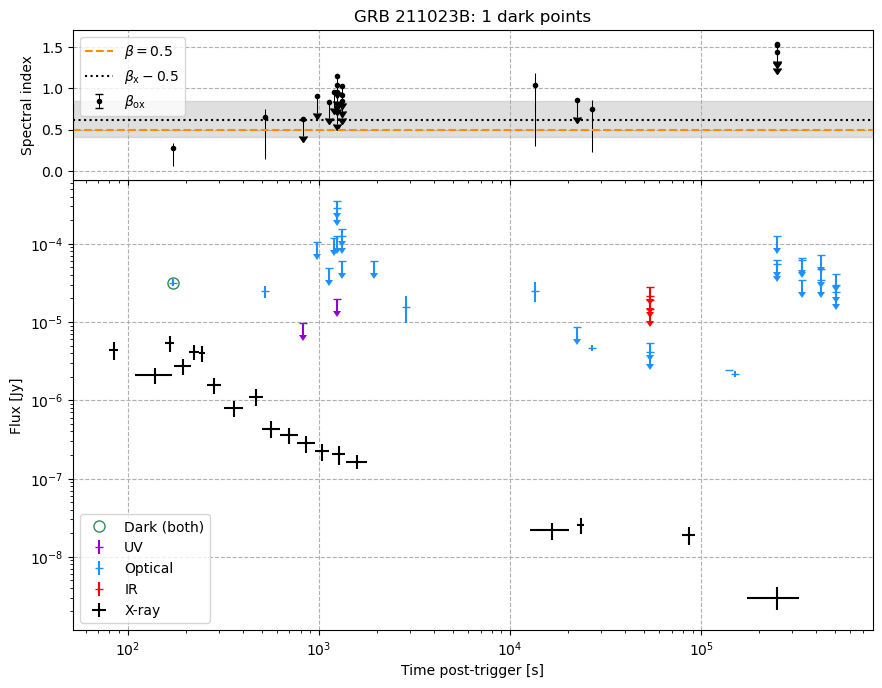

GRB         t_o       dt%  \
132  211023B     172.500  0.043595   
135  211023B     522.000  0.073808   
137  211023B     827.000  0.036906   
139  211023B     973.728  0.063206   
140  211023B    1122.500  0.079923   
143  211023B    1196.500  0.060967   
145  211023B    1241.000  0.026043   
147  211023B    1241.000  0.026043   
149  211023B    1241.000  0.026043   
151  211023B    1246.500  0.021726   
152  211023B    1324.000  0.039097   
154  211023B    1324.000  0.039097   
156  211023B    1324.000  0.039097   
158  211023B   13489.632  0.181126   
159  211023B   22320.000  0.047784   
160  211023B   26706.240  0.139341   
161  211023B  250560.000  0.005205   
162  211023B  250560.000  0.005205   
163  211023B  250560.000  0.005205   

                                            B_ox_w_err                  B_x  \
132  0.28112896338672066 (+0.05707456511353485, -0....  1.12 (+0.23, -0.21)   
135  0.6517958876840213 (+0.10368705765060536, -0.5...  1.12 (+0.23, -0.21)   
137     0.6255741588078932 (+0.1013525454331819, -inf)  1.12 (+0.23, -0.21)   
139     0.905455071978658 (+0.11827840576111703, -inf)  1.12 (+0.23, -0.21)   
140    0.8403814558860491 (+0.11889259599102356, -inf)  1.12 (+0.23, -0.21)   
143    0.9592597311819141 (+0.12840957072031275, -inf)  1.12 (+0.23, -0.21)   
145    1.1521672336999942 (+0.15285699684845014, -inf)  1.12 (+0.23, -0.21)   
147     0.952100804948431 (+0.12333930033168881, -inf)  1.12 (+0.23, -0.21)   
149    1.0428944809053946 (+0.13017071264080116, -inf)  1.12 (+0.23, -0.21)   
151    0.7699768186392831 (+0.11656485289743572, -inf)  1.12 (+0.23, -0.21)   
152    1.0242661398596438 (+0.13773977475886834, -inf)  1.12 (+0.23, -0.21)   
154    0.8430138668299184 (+0.11142608609221115, -inf)  1.12 (+0.23, -0.21)   
156    0.9236026173670062 (+0.11730549637201867, -inf)  1.12 (+0.23, -0.21)   
158  1.0364935017278023 (+0.1536104669224118, -0.73...  1.12 (+0.23, -0.21)   
159    0.8593294221197547 (+0.11134379131204827, -inf)  1.12 (+0.23, -0.21)   
160  0.7514351786229936 (+0.11001576298017463, -0.5...  1.12 (+0.23, -0.21)   
161     1.531068361917801 (+0.20034929907487087, -inf)  1.12 (+0.23, -0.21)   
162     1.4421500264258627 (+0.1804841857234215, -inf)  1.12 (+0.23, -0.21)   
163    1.5193600668734892 (+0.18441490709855024, -inf)  1.12 (+0.23, -0.21)   

         α Jak_dark vdH_dark  
132  0.948     True     True  
135  0.948    False    False  
137  0.948    False    False  
139  0.948    False    False  
140  0.948    False    False  
143  0.948    False    False  
145  0.948    False    False  
147  0.948    False    False  
149  0.948    False    False  
151  0.948    False    False  
152  0.948    False    False  
154  0.948    False    False  
156  0.948    False    False  
158  0.948    False    False  
159  0.948    False    False  
160  0.948    False    False  
161  0.948    False    False  
162  0.948    False    False  
163  0.948    False    False

1 0 0


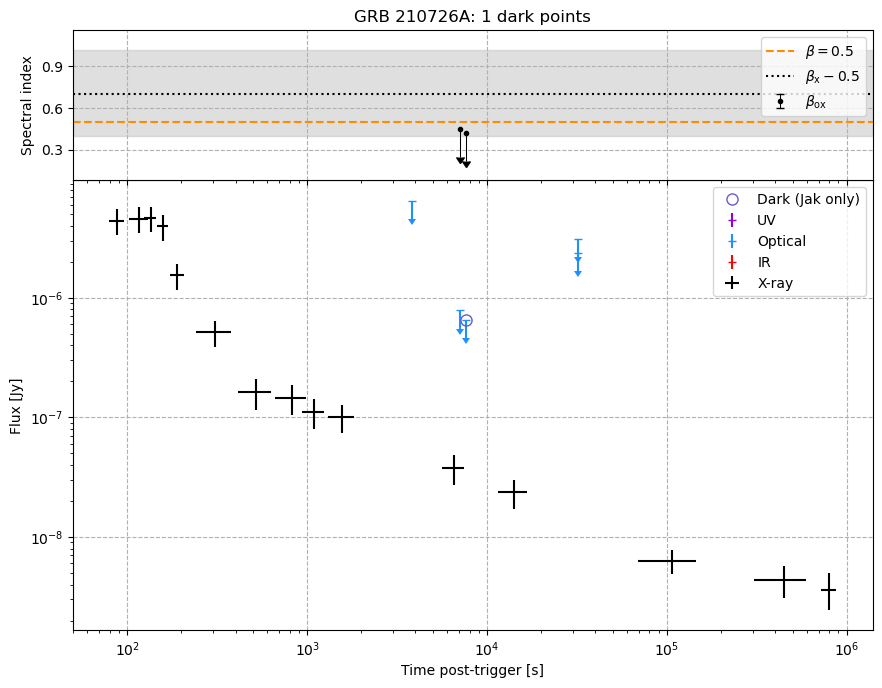

GRB     t_o       dt%  \
166  210726A  7041.6  0.076535   
167  210726A  7650.0  0.169548   

                                           B_ox_w_err                B_x  \
166   0.4506156575831122 (+0.07110941463007812, -inf)  1.2 (+0.32, -0.3)   
167  0.42114169739227614 (+0.07644274617931837, -inf)  1.2 (+0.32, -0.3)   

        α Jak_dark vdH_dark  
166  0.58    False    False  
167  0.58     True    False

2 0 0


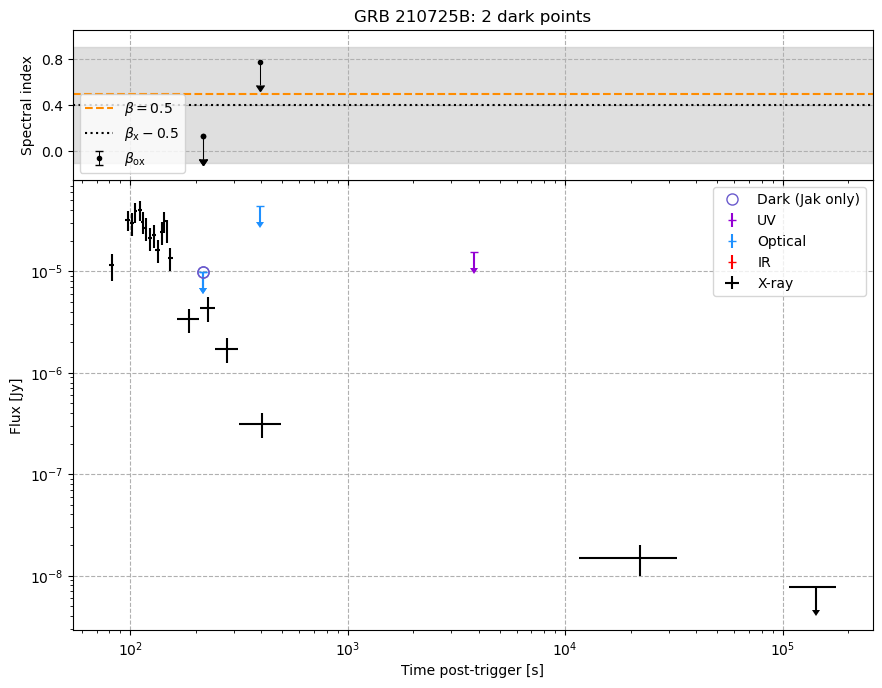

GRB    t_o       dt%  \
169  210725B  216.5  0.048431   
171  210725B  216.5  0.048431   
172  210725B  393.0  0.028834   

                                           B_ox_w_err        B_x     α  \
169  0.13020871804521683 (+0.06595051691675644, -inf)  0.9 ± 0.5  2.22   
171  0.13020871804521683 (+0.06595051691675644, -inf)  0.9 ± 0.5  2.22   
172   0.7725649669525019 (+0.11153803623101657, -inf)  0.9 ± 0.5  2.22   

    Jak_dark vdH_dark  
169     True    False  
171     True    False  
172    False    False

0 0 1


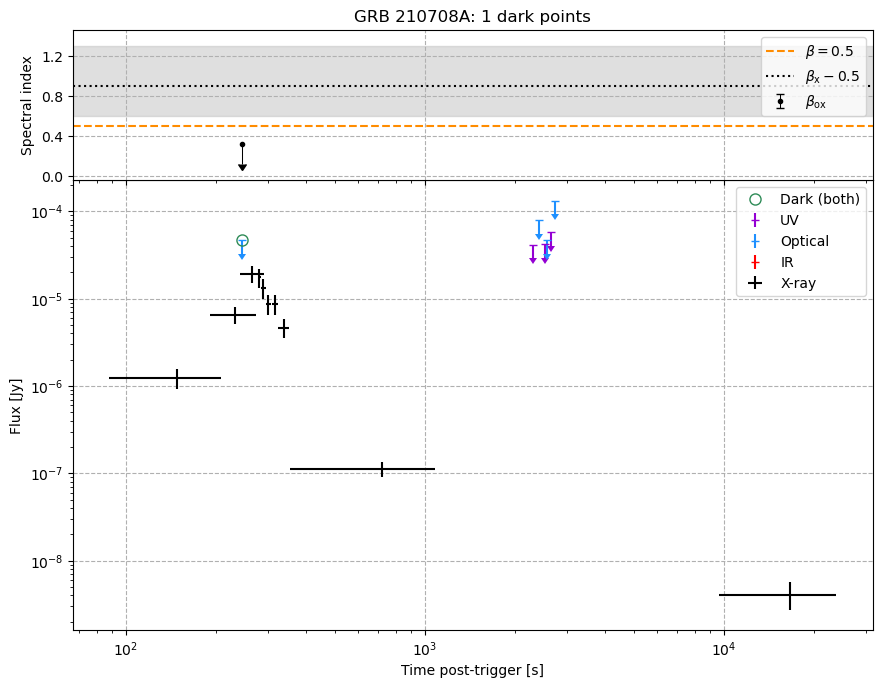

GRB    t_o       dt%  \
173  210708A  245.5  0.057633   

                                           B_ox_w_err               B_x     α  \
173  0.31607301266936977 (+0.06120442534630953, -inf)  1.4 (+0.4, -0.3)  1.05   

    Jak_dark vdH_dark  
173     True     True

1 0 0


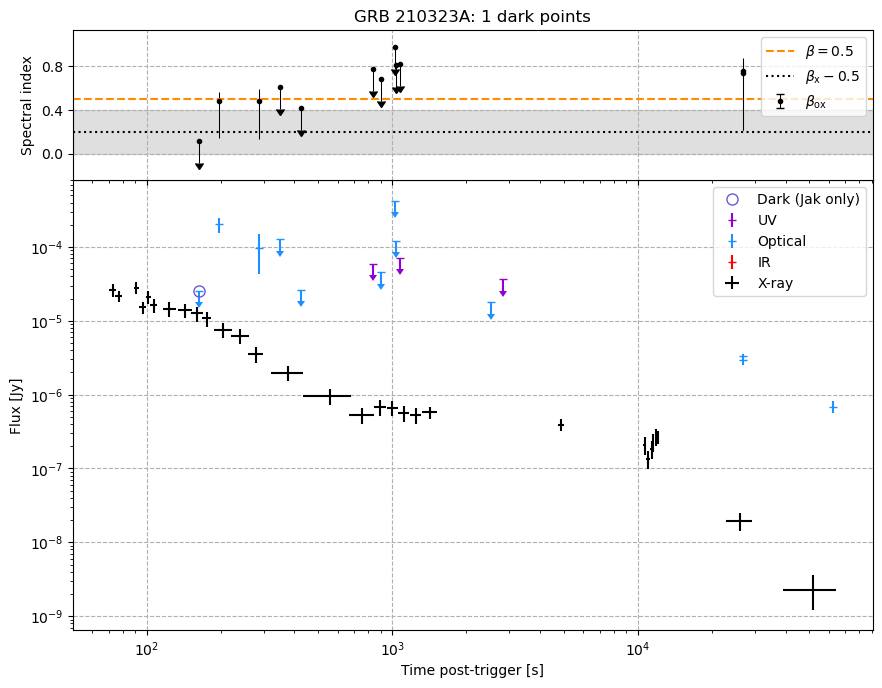

GRB        t_o       dt%  \
197  210323A    164.000  0.022176   
200  210323A    197.856  0.037024   
203  210323A    287.712  0.032951   
204  210323A    348.192  0.078930   
205  210323A    427.000  0.129540   
207  210323A    838.000  0.060724   
210  210323A    899.500  0.008208   
214  210323A   1027.500  0.027058   
218  210323A   1040.000  0.039553   
222  210323A   1077.000  0.033029   
224  210323A  26820.000  0.031177   
225  210323A  26939.520  0.035773   

                                            B_ox_w_err        B_x      α  \
197   0.11224670473253857 (+0.04278139383706613, -inf)  0.7 ± 0.2  1.600   
200  0.48146308092807644 (+0.07892234633808277, -0....  0.7 ± 0.2  1.600   
203  0.48413314165013294 (+0.10816552278366268, -0....  0.7 ± 0.2  1.600   
204    0.6096691043170209 (+0.09695544285472978, -inf)  0.7 ± 0.2  1.600   
205    0.4168772313152361 (+0.10816280268550332, -inf)  0.7 ± 0.2  1.600   
207    0.7770398035669612 (+0.11960739073850142, -inf)  0.7 ± 0.2  0.452   
210    0.6782290321733282 (+0.09815391355477487, -inf)  0.7 ± 0.2  0.452   
214    0.9749658384217068 (+0.12678590989086103, -inf)  0.7 ± 0.2  0.452   
218     0.8118359094467696 (+0.1112225131543405, -inf)  0.7 ± 0.2  0.452   
222    0.8188118699194027 (+0.12104775098046179, -inf)  0.7 ± 0.2  0.452   
224  0.7593483832591326 (+0.11007418307821619, -0.5...  0.7 ± 0.2  3.130   
225  0.7378449358856282 (+0.11113614352790967, -0.5...  0.7 ± 0.2  3.130   

    Jak_dark vdH_dark  
197     True    False  
200    False    False  
203    False    False  
204    False    False  
205    False    False  
207    False    False  
210    False    False  
214    False    False  
218    False    False  
222    False    False  
224    False    False  
225    False    False

1 0 0


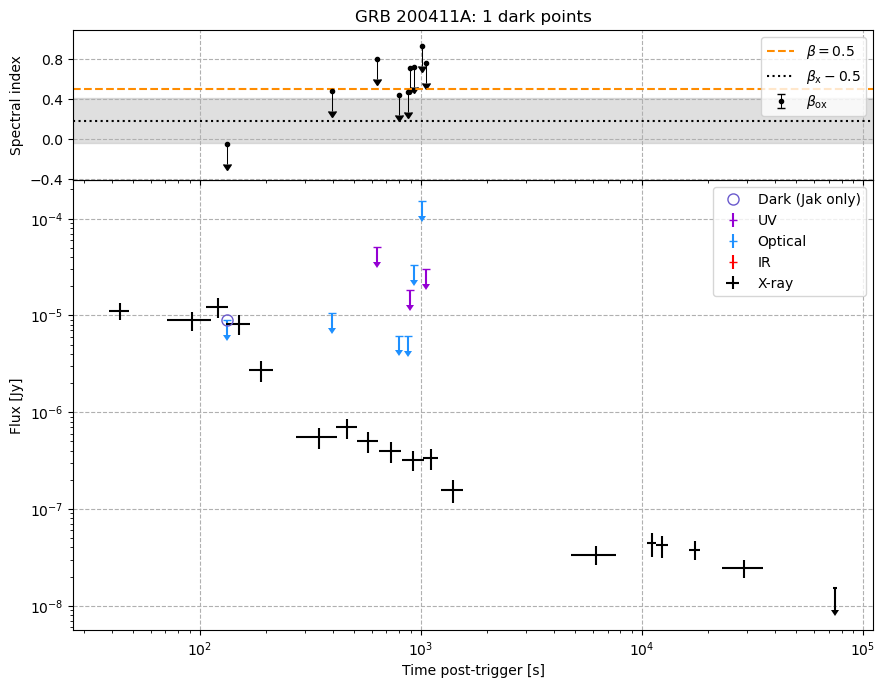

GRB     t_o       dt%  \
250  200411A   133.0  0.102198   
252  200411A   395.0  0.142021   
254  200411A   636.0  0.105920   
256  200411A   799.0  0.092668   
258  200411A   880.0  0.047658   
259  200411A   898.0  0.028178   
261  200411A   934.0  0.010781   
263  200411A  1009.0  0.091946   
266  200411A  1058.5  0.047526   

                                            B_ox_w_err                  B_x  \
250  -0.04851978052332558 (+0.05688337699006908, -inf)  0.68 (+0.23, -0.22)   
252    0.4783689882776384 (+0.09487235881232385, -inf)  0.68 (+0.23, -0.22)   
254     0.8042328731734381 (+0.1306512312686606, -inf)  0.68 (+0.23, -0.22)   
256    0.4373515063480147 (+0.07913264777404969, -inf)  0.68 (+0.23, -0.22)   
258   0.47447759588625593 (+0.07670545605582574, -inf)  0.68 (+0.23, -0.22)   
259    0.7092132768244779 (+0.11208122627933255, -inf)  0.68 (+0.23, -0.22)   
261     0.7227931242105741 (+0.1003803999823947, -inf)  0.68 (+0.23, -0.22)   
263    0.9299491714944917 (+0.12745818617667767, -inf)  0.68 (+0.23, -0.22)   
266    0.7609495275141429 (+0.11535404995967484, -inf)  0.68 (+0.23, -0.22)   

        α Jak_dark vdH_dark  
250  1.02     True    False  
252  1.02    False    False  
254  1.02    False    False  
256  1.02    False    False  
258  1.02    False    False  
259  1.02    False    False  
261  1.02    False    False  
263  1.02    False    False  
266  1.02    False    False

0 0 1


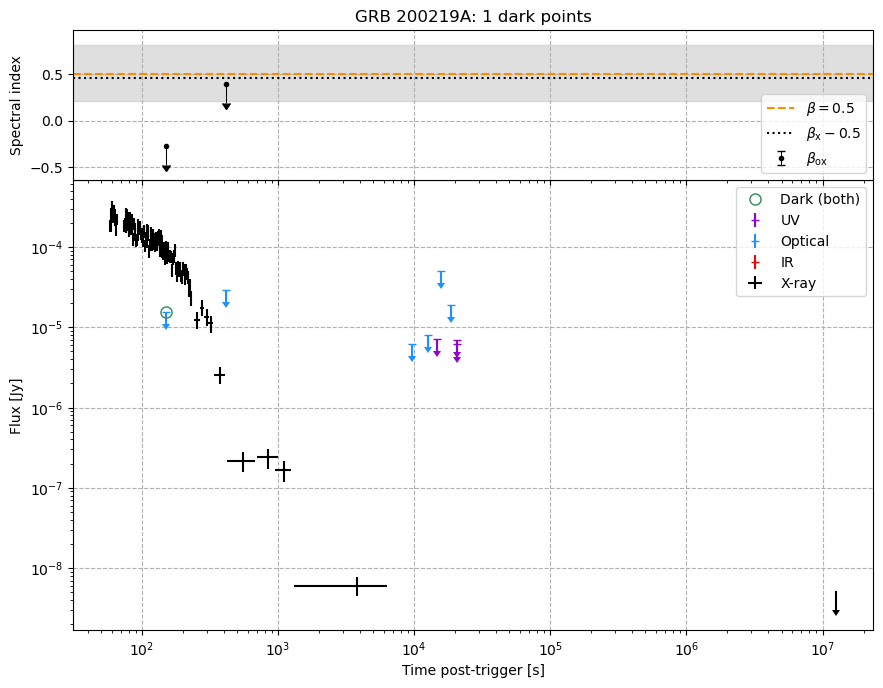

GRB    t_o       dt%  \
282  200219A  150.0  0.004870   
299  200219A  412.0  0.106046   

                                           B_ox_w_err                  B_x  \
282  -0.2738795394973301 (+0.04551266355059989, -inf)  0.96 (+0.35, -0.25)   
299    0.3930623206621587 (+0.2363715253434425, -inf)  0.96 (+0.35, -0.25)   

        α Jak_dark vdH_dark  
282  2.05     True     True  
299  5.19    False    False

1 0 0


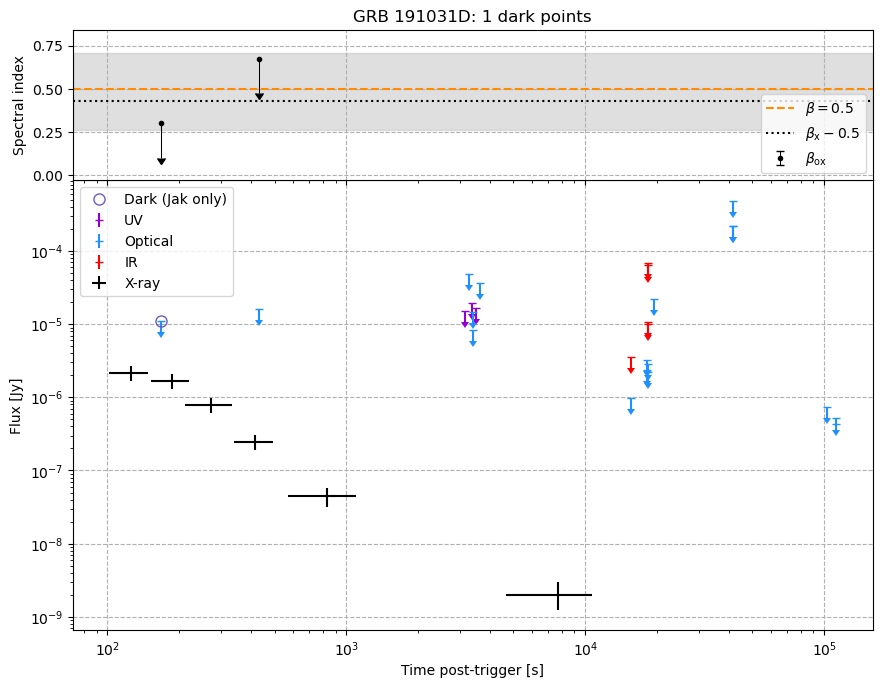

GRB    t_o       dt%  \
300  191031D  167.5  0.099559   
301  191031D  430.5  0.036059   

                                          B_ox_w_err                  B_x  \
300  0.3013995792493801 (+0.09686586908982647, -inf)  0.93 (+0.28, -0.17)   
301  0.6746782734039395 (+0.10202858622274029, -inf)  0.93 (+0.28, -0.17)   

        α Jak_dark vdH_dark  
300  1.95     True    False  
301  1.95    False    False

4 0 1


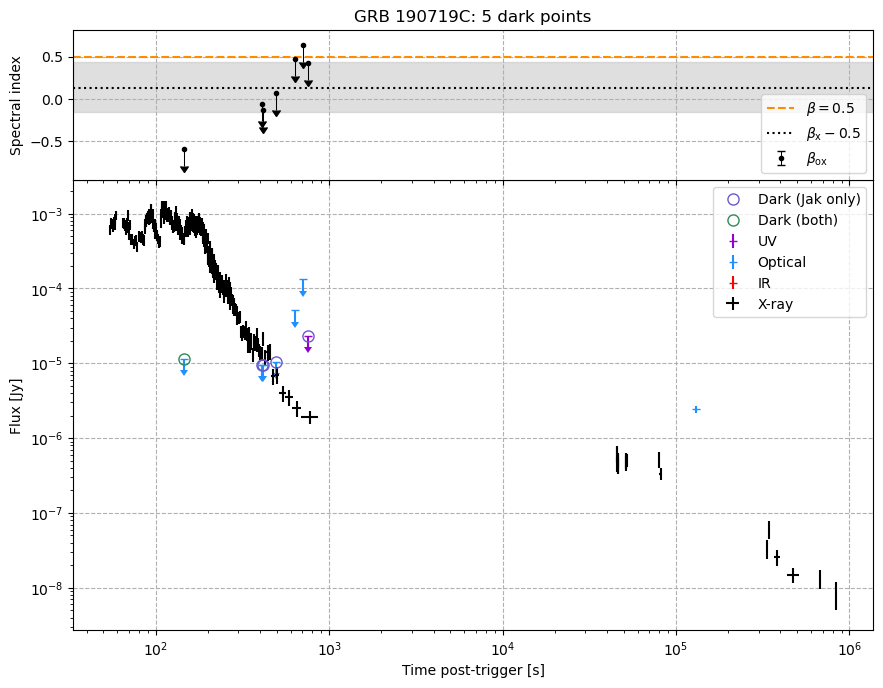

GRB    t_o       dt%  \
327  190719C  146.0  0.000404   
390  190719C  408.0  0.001813   
410  190719C  413.5  0.000571   
421  190719C  494.5  0.018019   
426  190719C  635.0  0.023853   
429  190719C  710.0  0.079953   
431  190719C  759.0  0.016457   

                                            B_ox_w_err                 B_x  \
327   -0.5889694249784356 (+0.08118119720248067, -inf)  0.63 (+0.3, -0.28)   
390  -0.05661184230678618 (+0.03480549045206605, -inf)  0.63 (+0.3, -0.28)   
410  -0.12907305411767916 (+0.03672237773612865, -inf)  0.63 (+0.3, -0.28)   
421   0.06343831813919938 (+0.04109125428086391, -inf)  0.63 (+0.3, -0.28)   
426    0.47189679713636695 (+0.0721816717296729, -inf)  0.63 (+0.3, -0.28)   
429    0.6405047267121906 (+0.09135601915920856, -inf)  0.63 (+0.3, -0.28)   
431    0.42094216852109856 (+0.0675042707551657, -inf)  0.63 (+0.3, -0.28)   

       α Jak_dark vdH_dark  
327  1.0     True     True  
390  1.0     True    False  
410  1.0     True    False  
421  1.0     True    False  
426  1.0    False    False  
429  1.0    False    False  
431  1.0     True    False

1 0 0


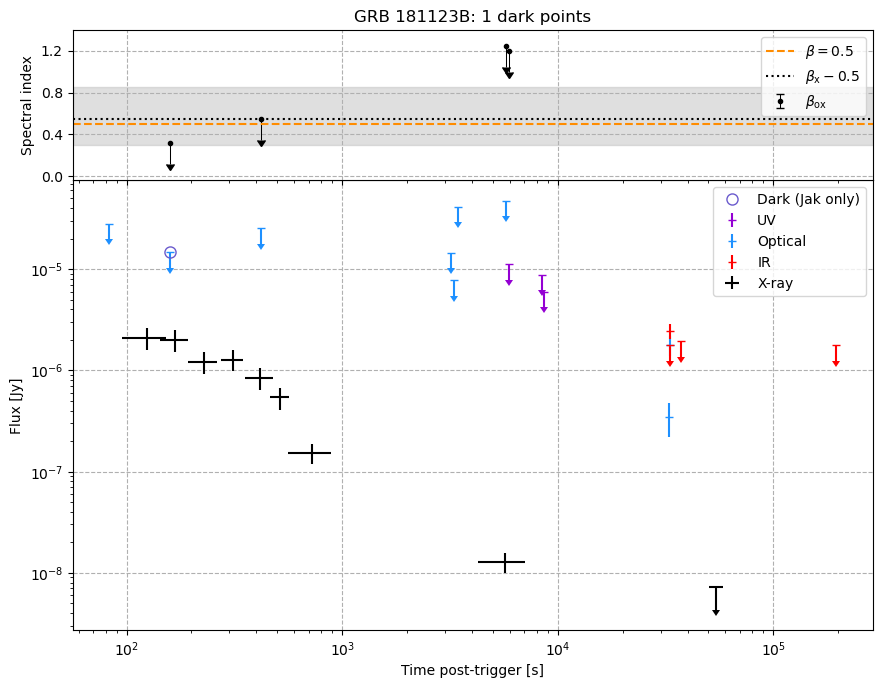

GRB     t_o       dt%  \
483  181123B   158.5  0.056227   
484  181123B   421.0  0.014967   
486  181123B  5774.0  0.017439   
487  181123B  5917.0  0.042637   

                                           B_ox_w_err                 B_x  \
483  0.31724610479428333 (+0.06562468296156637, -inf)  1.05 (+0.3, -0.25)   
484   0.5489210873989546 (+0.08340075224975443, -inf)  1.05 (+0.3, -0.25)   
486   1.2412891991341262 (+0.15884182215870998, -inf)  1.05 (+0.3, -0.25)   
487   1.1960044352612713 (+0.18049580276881366, -inf)  1.05 (+0.3, -0.25)   

        α Jak_dark vdH_dark  
483  1.41     True    False  
484  1.41    False    False  
486  1.41    False    False  
487  1.41    False    False

1 0 0


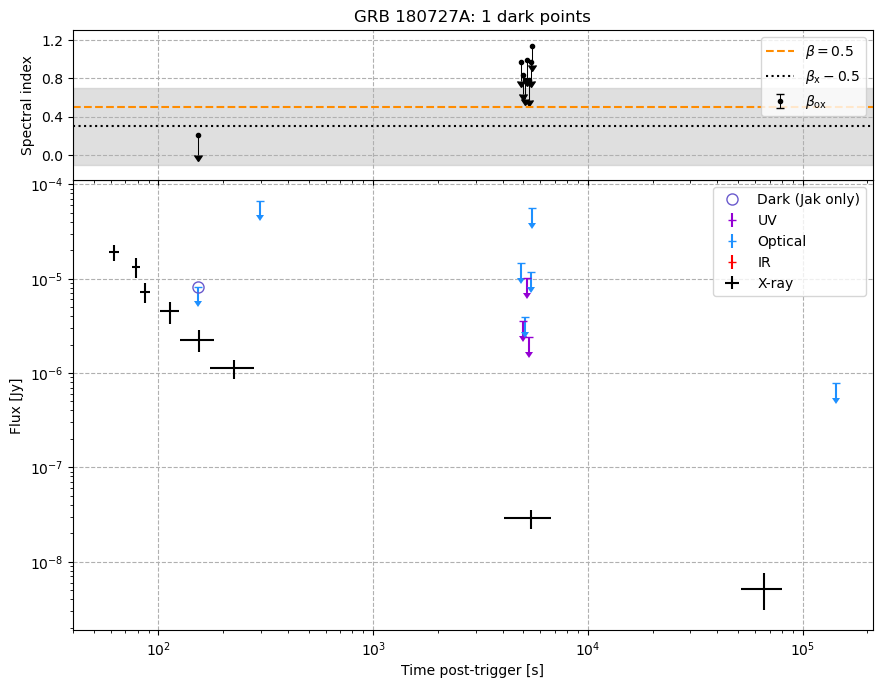

GRB     t_o       dt%  \
488  180727A   152.0  0.011286   
489  180727A  4892.5  0.094739   
490  180727A  4995.0  0.075773   
491  180727A  5097.5  0.056808   
492  180727A  5201.0  0.037657   
493  180727A  5303.5  0.018692   
494  180727A  5405.0  0.000089   
495  180727A  5501.0  0.017852   

                                           B_ox_w_err        B_x     α  \
488  0.20493517918355417 (+0.04999241805790475, -inf)  0.8 ± 0.4  1.38   
489   0.9705350869930872 (+0.14089705850990228, -inf)  0.8 ± 0.4  1.38   
490    0.8357851707828052 (+0.1337817749268779, -inf)  0.8 ± 0.4  1.38   
491   0.7797222565865061 (+0.11337834093214914, -inf)  0.8 ± 0.4  1.38   
492    0.9876889710985113 (+0.1446214718752361, -inf)  0.8 ± 0.4  1.38   
493   0.7780083241285315 (+0.12059979463992108, -inf)  0.8 ± 0.4  1.38   
494   0.9683910078866975 (+0.13417740367028747, -inf)  0.8 ± 0.4  1.38   
495   1.1417056516989406 (+0.14679112636914804, -inf)  0.8 ± 0.4  1.38   

    Jak_dark vdH_dark  
488     True    False  
489    False    False  
490    False    False  
491    False    False  
492    False    False  
493    False    False  
494    False    False  
495    False    False

0 0 1


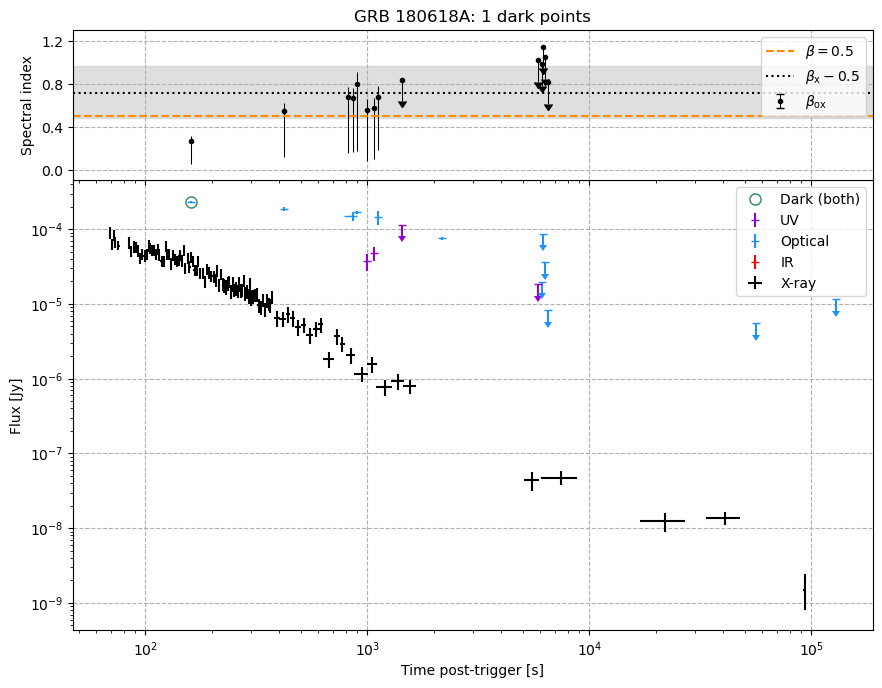

GRB     t_o       dt%  \
505  180618A   161.0  0.001487   
520  180618A   423.0  0.016343   
527  180618A   815.0  0.031596   
531  180618A   864.0  0.026627   
536  180618A   897.5  0.046156   
540  180618A  1001.0  0.048888   
543  180618A  1074.0  0.020474   
546  180618A  1112.0  0.056580   
549  180618A  1437.5  0.050929   
551  180618A  5882.5  0.071921   
552  180618A  6087.5  0.109277   
554  180618A  6190.0  0.127955   
556  180618A  6292.5  0.146632   
559  180618A  6497.5  0.124063   

                                            B_ox_w_err                  B_x  \
505  0.2701817734707163 (+0.04474859606087953, -0.2...  1.22 (+0.25, -0.23)   
520  0.5462199361034078 (+0.0818627937857624, -0.42...  1.22 (+0.25, -0.23)   
527  0.677317056166536 (+0.09773780698132033, -0.51...  1.22 (+0.25, -0.23)   
531  0.6674828969336349 (+0.09729216604542491, -0.4...  1.22 (+0.25, -0.23)   
536  0.800724408534892 (+0.11536874054817413, -0.61...  1.22 (+0.25, -0.23)   
540  0.5563424102797698 (+0.10409478164988357, -0.4...  1.22 (+0.25, -0.23)   
543  0.5759094251223985 (+0.09770079103414002, -0.4...  1.22 (+0.25, -0.23)   
546  0.6804661264558614 (+0.10004264407911767, -0.4...  1.22 (+0.25, -0.23)   
549    0.8398757950940956 (+0.12927202054024545, -inf)  1.22 (+0.25, -0.23)   
551    1.0199452356852825 (+0.15271008584954765, -inf)  1.22 (+0.25, -0.23)   
552    0.9870282975728539 (+0.14609675880156883, -inf)  1.22 (+0.25, -0.23)   
554     1.1470094712914323 (+0.1579203445903674, -inf)  1.22 (+0.25, -0.23)   
556    1.0483195418809161 (+0.15386565599251006, -inf)  1.22 (+0.25, -0.23)   
559    0.8189779366377461 (+0.12361144056492365, -inf)  1.22 (+0.25, -0.23)   

       α Jak_dark vdH_dark  
505  1.0     True     True  
520  1.0    False    False  
527  1.0    False    False  
531  1.0    False    False  
536  1.0    False    False  
540  1.0    False    False  
543  1.0    False    False  
546  1.0    False    False  
549  1.0    False    False  
551  1.0    False    False  
552  1.0    False    False  
554  1.0    False    False  
556  1.0    False    False  
559  1.0    False    False

1 0 1


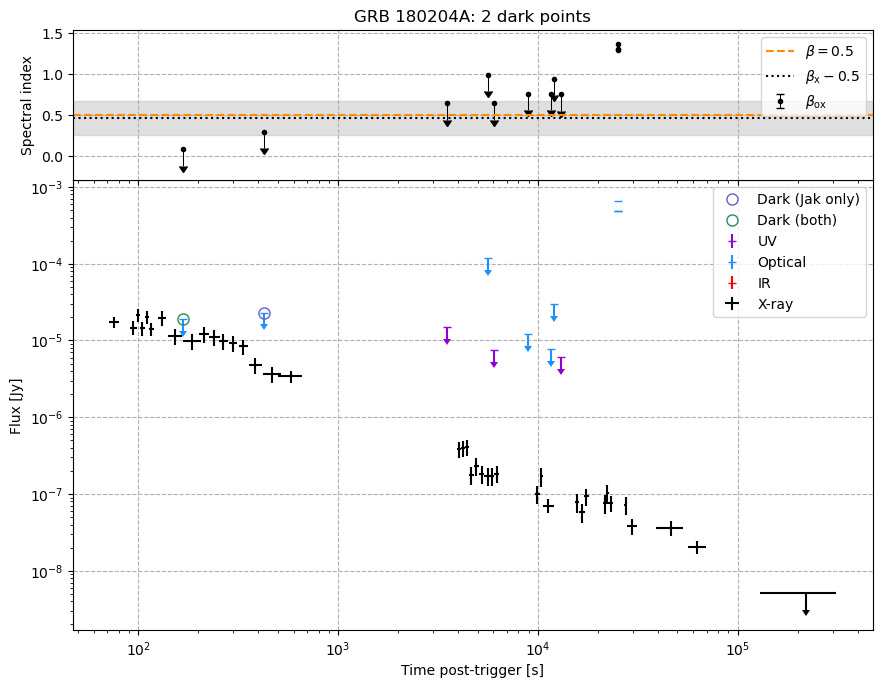

GRB      t_o       dt%  \
923  180204A    167.0  0.088473   
926  180204A    429.0  0.085590   
927  180204A   3503.5  0.133224   
931  180204A   5610.0  0.000121   
937  180204A   6075.0  0.026713   
938  180204A   8988.0  0.098983   
942  180204A  11683.0  0.032183   
944  180204A  12091.0  0.068230   
945  180204A  13045.5  0.152559   
950  180204A  25200.0  0.086293   
955  180204A  25200.0  0.086293   
960  180204A  25200.0  0.086293   

                                           B_ox_w_err                 B_x  \
923  0.08172057145899975 (+0.05496415412971789, -inf)  0.96 (+0.21, -0.2)   
926   0.2976121359239437 (+0.06691837997167112, -inf)  0.96 (+0.21, -0.2)   
927   0.6420782288764217 (+0.11787048321312481, -inf)  0.96 (+0.21, -0.2)   
931   0.9865262434120861 (+0.12962497057014724, -inf)  0.96 (+0.21, -0.2)   
937   0.6443715561357405 (+0.10348192015402807, -inf)  0.96 (+0.21, -0.2)   
938   0.7599729952378779 (+0.11709400620099102, -inf)  0.96 (+0.21, -0.2)   
942   0.7558615623967244 (+0.10708795905675003, -inf)  0.96 (+0.21, -0.2)   
944     0.943958369500233 (+0.1295769652664703, -inf)  0.96 (+0.21, -0.2)   
945   0.7522870715167811 (+0.12875003032360594, -inf)  0.96 (+0.21, -0.2)   
950                   1.3596352869760355 (+nan, -nan)  0.96 (+0.21, -0.2)   
955                   1.2938015684891093 (+nan, -nan)  0.96 (+0.21, -0.2)   
960                   1.3035755745867539 (+nan, -nan)  0.96 (+0.21, -0.2)   

         α Jak_dark vdH_dark  
923  1.073     True     True  
926  1.073     True    False  
927  1.073    False    False  
931  1.073    False    False  
937  1.073    False    False  
938  1.073    False    False  
942  1.073    False    False  
944  1.073    False    False  
945  1.073    False    False  
950  1.073    False    False  
955  1.073    False    False  
960  1.073    False    False

0 0 2


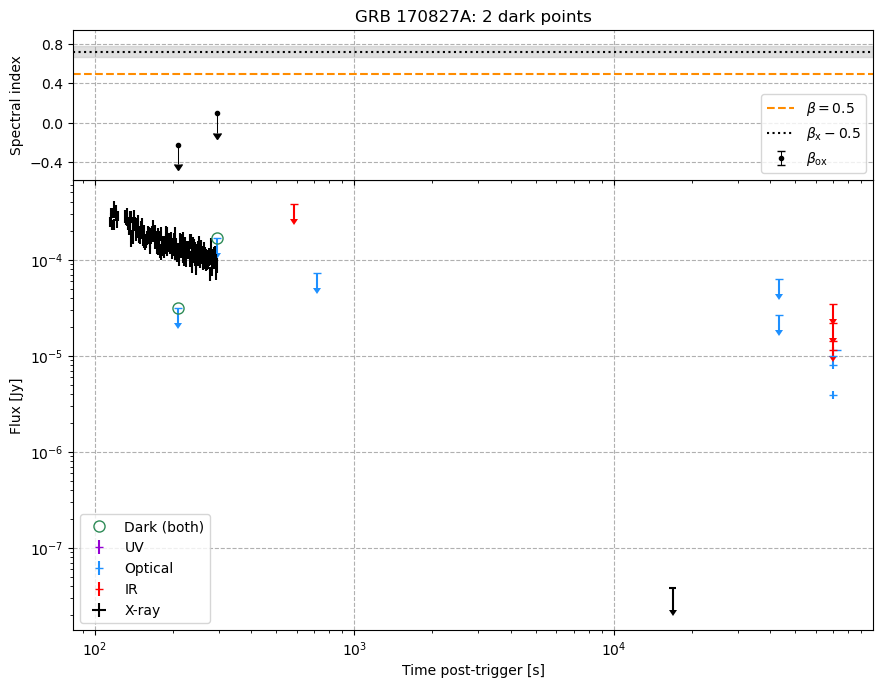

GRB    t_o       dt%  \
995   170827A  209.0  0.001620   
1085  170827A  295.0  0.001141   

                                             B_ox_w_err                  B_x  \
995   -0.2203397298098377 (+0.039224001726319235, -inf)  1.22 (+0.06, -0.05)   
1085   0.10113836807528154 (+0.03191948707598461, -inf)  1.22 (+0.06, -0.05)   

         α Jak_dark vdH_dark  
995   1.19     True     True  
1085  1.19     True     True

5 0 2


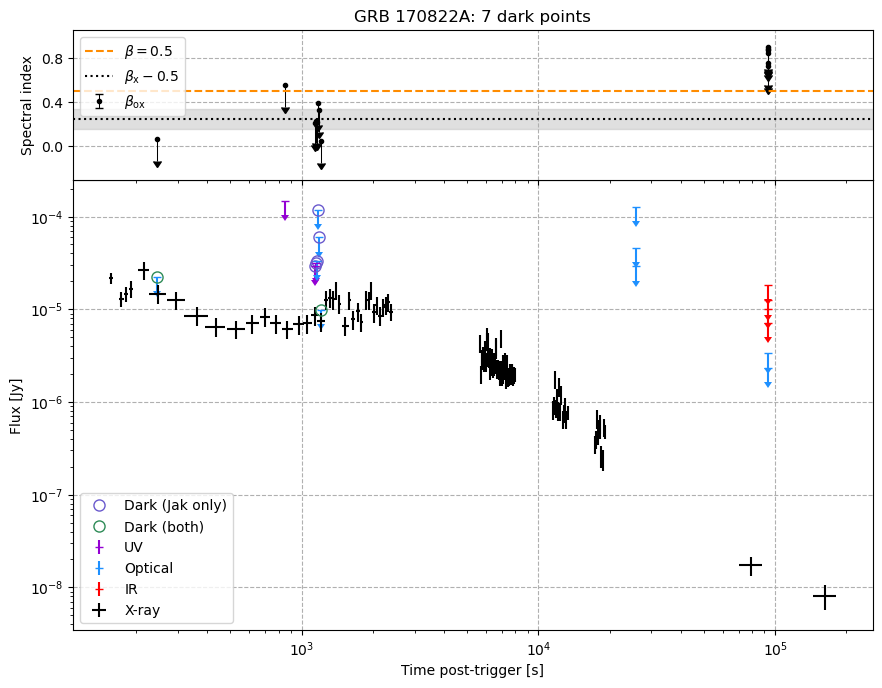

GRB      t_o       dt%  \
1087  170822A    246.0  0.006438   
1090  170822A    852.5  0.021796   
1095  170822A   1137.5  0.001324   
1103  170822A   1151.0  0.010528   
1111  170822A   1162.5  0.020625   
1119  170822A   1171.0  0.028088   
1128  170822A   1187.0  0.017710   
1136  170822A   1211.5  0.002565   
1142  170822A  93294.0  0.178768   
1143  170822A  93294.0  0.178768   
1144  170822A  93294.0  0.178768   
1145  170822A  93294.0  0.178768   
1146  170822A  93294.0  0.178768   
1147  170822A  93294.0  0.178768   

                                             B_ox_w_err          B_x    α  \
1087   0.06632866150371261 (+0.03639487458237825, -inf)  0.75 ± 0.09  1.0   
1090    0.5544462963306861 (+0.08962834553343252, -inf)  0.75 ± 0.09  1.0   
1095    0.2065382858770375 (+0.04815774499357656, -inf)  0.75 ± 0.09  1.0   
1103   0.22706388940018976 (+0.05233729809930151, -inf)  0.75 ± 0.09  1.0   
1111   0.21899768108077097 (+0.04788721575958571, -inf)  0.75 ± 0.09  1.0   
1119   0.39480341427967713 (+0.06132345443956888, -inf)  0.75 ± 0.09  1.0   
1128   0.3255730795351884 (+0.055866177654593896, -inf)  0.75 ± 0.09  1.0   
1136  0.04369080569880635 (+0.037141690846088274, -inf)  0.75 ± 0.09  1.0   
1142     0.7260725864210473 (+0.1189246259640767, -inf)  0.75 ± 0.09  1.0   
1143     0.757191589780777 (+0.11948044169878216, -inf)  0.75 ± 0.09  1.0   
1144     0.8462515631805578 (+0.1257430516258267, -inf)  0.75 ± 0.09  1.0   
1145    0.8776117851423296 (+0.12682754138224064, -inf)  0.75 ± 0.09  1.0   
1146     0.8823887147736473 (+0.1249219067949043, -inf)  0.75 ± 0.09  1.0   
1147    0.9027132829564624 (+0.12380698015314746, -inf)  0.75 ± 0.09  1.0   

     Jak_dark vdH_dark  
1087     True     True  
1090    False    False  
1095     True    False  
1103     True    False  
1111     True    False  
1119     True    False  
1128     True    False  
1136     True     True  
1142    False    False  
1143    False    False  
1144    False    False  
1145    False    False  
1146    False    False  
1147    False    False

16 0 15


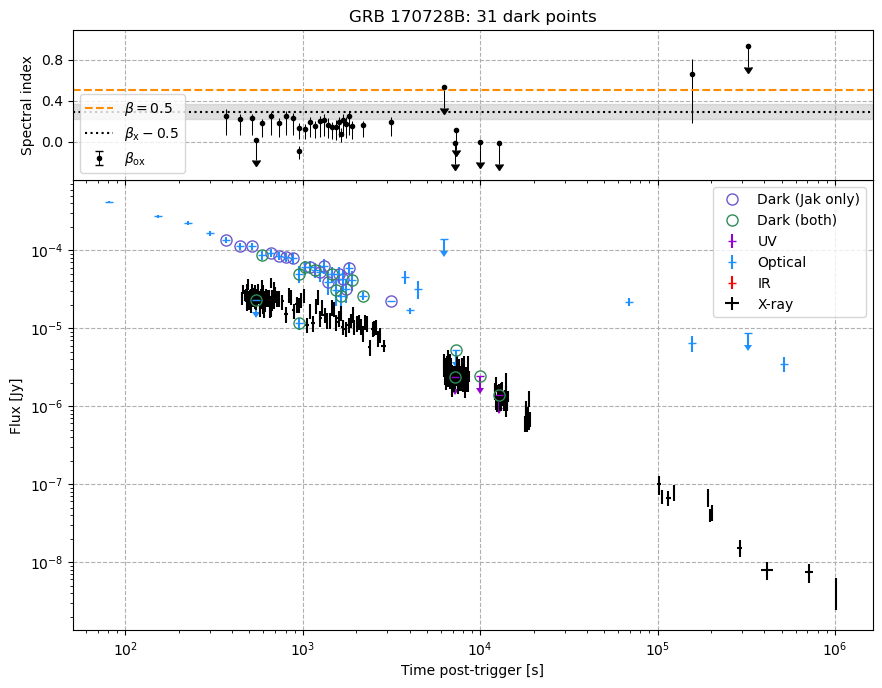

GRB         t_o       dt%  \
1148  170728B     371.000  0.186497   
1150  170728B     444.000  0.026427   
1187  170728B     517.000  0.001554   
1241  170728B     548.000  0.000851   
1301  170728B     589.000  0.002699   
1357  170728B     662.000  0.001591   
1394  170728B     735.000  0.002532   
1410  170728B     807.000  0.004840   
1422  170728B     880.000  0.008298   
1434  170728B     951.000  0.001066   
1446  170728B     953.000  0.003172   
1458  170728B    1026.000  0.014691   
1470  170728B    1098.000  0.000753   
1483  170728B    1171.000  0.012550   
1496  170728B    1243.000  0.007742   
1510  170728B    1316.000  0.013532   
1523  170728B    1389.000  0.013632   
1536  170728B    1462.000  0.000612   
1550  170728B    1534.000  0.006103   
1563  170728B    1607.000  0.009616   
1576  170728B    1644.500  0.006002   
1590  170728B    1680.000  0.000937   
1604  170728B    1753.000  0.003001   
1618  170728B    1825.000  0.007517   
1633  170728B    1898.000  0.004926   
1647  170728B    2190.000  0.001990   
1658  170728B    3150.000  0.101920   
1659  170728B    6244.992  0.000297   
1717  170728B    7255.000  0.001850   
1768  170728B    7285.500  0.002346   
1802  170728B    9965.000  0.154878   
1814  170728B   12764.000  0.001985   
1831  170728B  155360.160  0.192410   
1832  170728B  321670.656  0.107979   

                                             B_ox_w_err                  B_x  \
1148  0.25044226441217077 (+0.06689699664090105, -0....  0.79 (+0.08, -0.07)   
1150  0.22439521296238363 (+0.04201888290485343, -0....  0.79 (+0.08, -0.07)   
1187  0.2273142050325974 (+0.04208145045713396, -0.1...  0.79 (+0.08, -0.07)   
1241   0.018743704294551102 (+0.0293360417086443, -inf)  0.79 (+0.08, -0.07)   
1301  0.1781096822311161 (+0.04016795043538247, -0.1...  0.79 (+0.08, -0.07)   
1357  0.24596624607770318 (+0.04461074272014205, -0....  0.79 (+0.08, -0.07)   
1394  0.18457621386313391 (+0.044494481378185215, -0...  0.79 (+0.08, -0.07)   
1410  0.2492626079164761 (+0.04961978058602232, -0.1...  0.79 (+0.08, -0.07)   
1422  0.227566272804108 (+0.04809312171188405, -0.16...  0.79 (+0.08, -0.07)   
1434  -0.08822109794538191 (+0.04782750223789055, -0...  0.79 (+0.08, -0.07)   
1446  0.1341683621110353 (+0.05126399989145112, -0.1...  0.79 (+0.08, -0.07)   
1458  0.12217608018062213 (+0.04641735870936234, -0....  0.79 (+0.08, -0.07)   
1470  0.18804399412770334 (+0.048225762274585186, -0...  0.79 (+0.08, -0.07)   
1483  0.15557926117772217 (+0.049004795479117264, -0...  0.79 (+0.08, -0.07)   
1496  0.1997430958144993 (+0.05532042479990835, -0.1...  0.79 (+0.08, -0.07)   
1510  0.21350209354040448 (+0.052282654851322316, -0...  0.79 (+0.08, -0.07)   
1523  0.1664405712405106 (+0.06174136147455755, -0.1...  0.79 (+0.08, -0.07)   
1536  0.1426827652097761 (+0.05062247198499502, -0.1...  0.79 (+0.08, -0.07)   
1550  0.14007376539967625 (+0.06826140739792778, -0....  0.79 (+0.08, -0.07)   
1563  0.19094626069006657 (+0.05248011250666278, -0....  0.79 (+0.08, -0.07)   
1576  0.07633621631621328 (+0.05499006066929548, -0....  0.79 (+0.08, -0.07)   
1590  0.2080062878343111 (+0.06039849631156196, -0.1...  0.79 (+0.08, -0.07)   
1604  0.174845244418762 (+0.06462842414425325, -0.13...  0.79 (+0.08, -0.07)   
1618  0.24881537135764847 (+0.0528899656020569, -0.1...  0.79 (+0.08, -0.07)   
1633  0.14997811220446008 (+0.056873356845925226, -0...  0.79 (+0.08, -0.07)   
1647  0.1635409009988904 (+0.04245678763528685, -0.1...  0.79 (+0.08, -0.07)   
1658  0.19460145103402937 (+0.046015371988720334, -0...  0.79 (+0.08, -0.07)   
1659    0.5283712041396927 (+0.07190681929447125, -inf)  0.79 (+0.08, -0.07)   
1717  -0.01582405611031937 (+0.03987156245090574, -inf)  0.79 (+0.08, -0.07)   
1768   0.11631626759799985 (+0.03961845462111817, -inf)  0.79 (+0.08, -0.07)   
1802  0.0012390209473908207 (+0.0863972127521314, -inf)  0.79 (+0.08, -0.07)   
1814  -0.013787394671253103 (+0.038599033560890866, ...  0.79 (+0.08, -0.07)   
1831

1 0 0


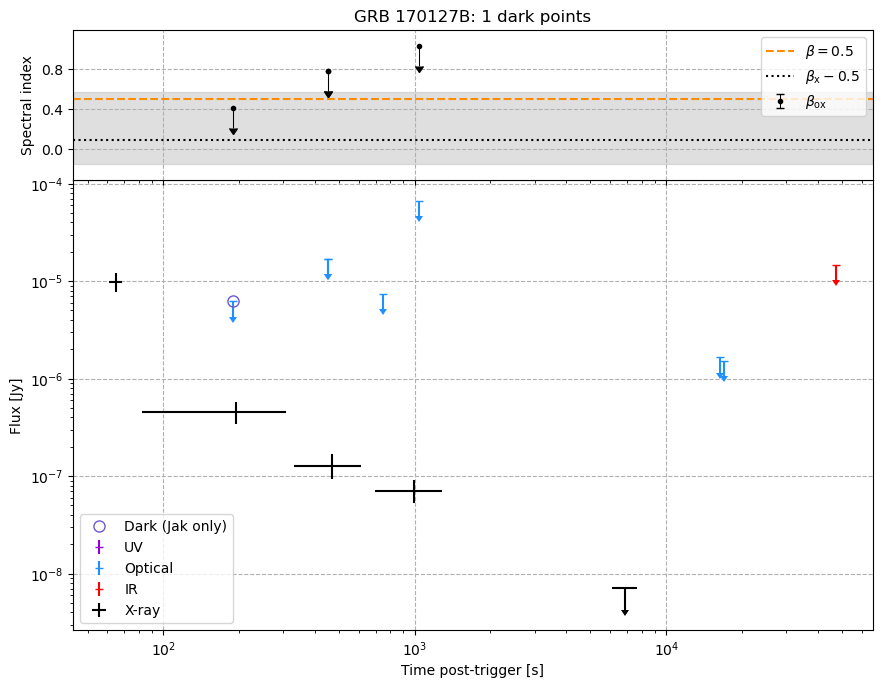

GRB     t_o       dt%  \
1839  170127B   189.0  0.033184   
1840  170127B   451.5  0.040847   
1841  170127B   451.5  0.040847   
1842  170127B  1041.5  0.051929   

                                            B_ox_w_err                  B_x  \
1839  0.41573286666215475 (+0.07187030642336034, -inf)  0.59 (+0.48, -0.24)   
1840   0.7868264752086797 (+0.11860436191480121, -inf)  0.59 (+0.48, -0.24)   
1841   0.7868264752086797 (+0.11860436191480121, -inf)  0.59 (+0.48, -0.24)   
1842    1.0333784403216164 (+0.1407378826257445, -inf)  0.59 (+0.48, -0.24)   

        α Jak_dark vdH_dark  
1839  1.9     True    False  
1840  1.9    False    False  
1841  1.9    False    False  
1842  1.9    False    False

2 0 0


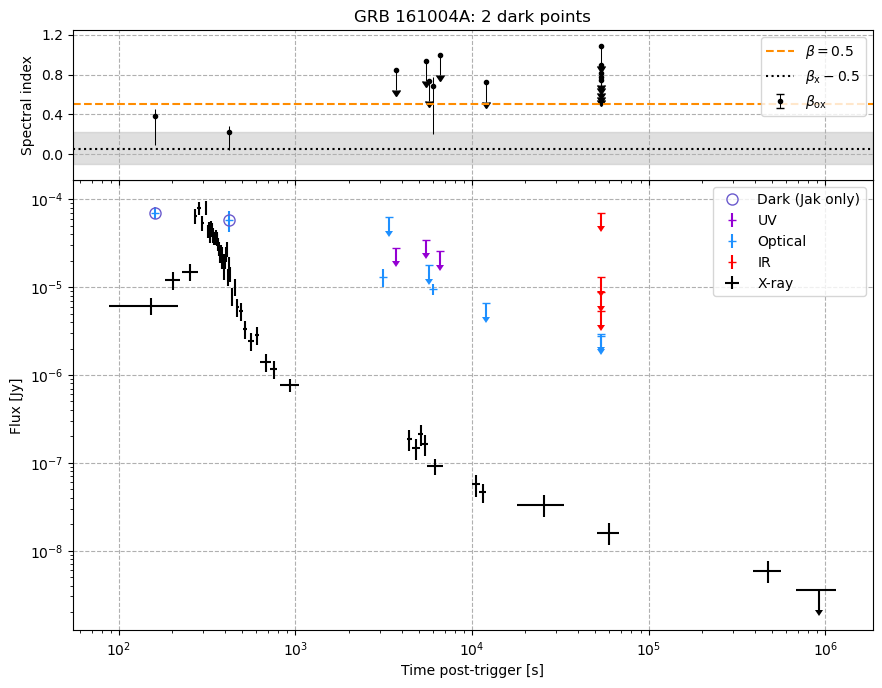

GRB        t_o       dt%  \
1843  161004A    160.000  0.049511   
1860  161004A    422.000  0.006133   
1866  161004A   3689.500  0.165222   
1869  161004A   5508.000  0.016397   
1873  161004A   5739.000  0.059024   
1877  161004A   6031.584  0.026322   
1878  161004A   6554.000  0.058012   
1880  161004A  12061.440  0.049469   
1881  161004A  53496.000  0.099868   
1882  161004A  53496.000  0.099868   
1883  161004A  53496.000  0.099868   
1884  161004A  53496.000  0.099868   
1885  161004A  53496.000  0.099868   
1886  161004A  53496.000  0.099868   

                                             B_ox_w_err                  B_x  \
1843  0.3880093011510872 (+0.06981752143036461, -0.2...  0.55 (+0.17, -0.15)   
1860  0.2271069800104917 (+0.061431669756167734, -0....  0.55 (+0.17, -0.15)   
1866     0.8473018639494653 (+0.1440953380868695, -inf)  0.55 (+0.17, -0.15)   
1869     0.9339777102208214 (+0.1423238646231631, -inf)  0.55 (+0.17, -0.15)   
1873    0.7342353790575469 (+0.10667268257281373, -inf)  0.55 (+0.17, -0.15)   
1877  0.6829336454445946 (+0.09109339737894871, -0.4...  0.55 (+0.17, -0.15)   
1878    0.9937977154246759 (+0.15110339615659701, -inf)  0.55 (+0.17, -0.15)   
1880    0.7283576529608677 (+0.09797631196783615, -inf)  0.55 (+0.17, -0.15)   
1881    0.7722063755142828 (+0.11176208336025191, -inf)  0.55 (+0.17, -0.15)   
1882    0.7424924159741795 (+0.10603918764257649, -inf)  0.55 (+0.17, -0.15)   
1883     0.8175303308371378 (+0.1114571655874065, -inf)  0.55 (+0.17, -0.15)   
1884    0.8681495766736285 (+0.11448847189271323, -inf)  0.55 (+0.17, -0.15)   
1885    0.8974337890306233 (+0.11465192731362879, -inf)  0.55 (+0.17, -0.15)   
1886    1.0867513764461323 (+0.12926224941211678, -inf)  0.55 (+0.17, -0.15)   

         α Jak_dark vdH_dark  
1843  1.04     True    False  
1860  1.04     True    False  
1866  1.04    False    False  
1869  1.04    False    False  
1873  1.04    False    False  
1877  1.04    False    False  
1878  1.04    False    False  
1880  1.04    False    False  
1881  1.04    False    False  
1882  1.04    False    False  
1883  1.04    False    False  
1884  1.04    False    False  
1885  1.04    False    False  
1886  1.04    False    False

1 0 0


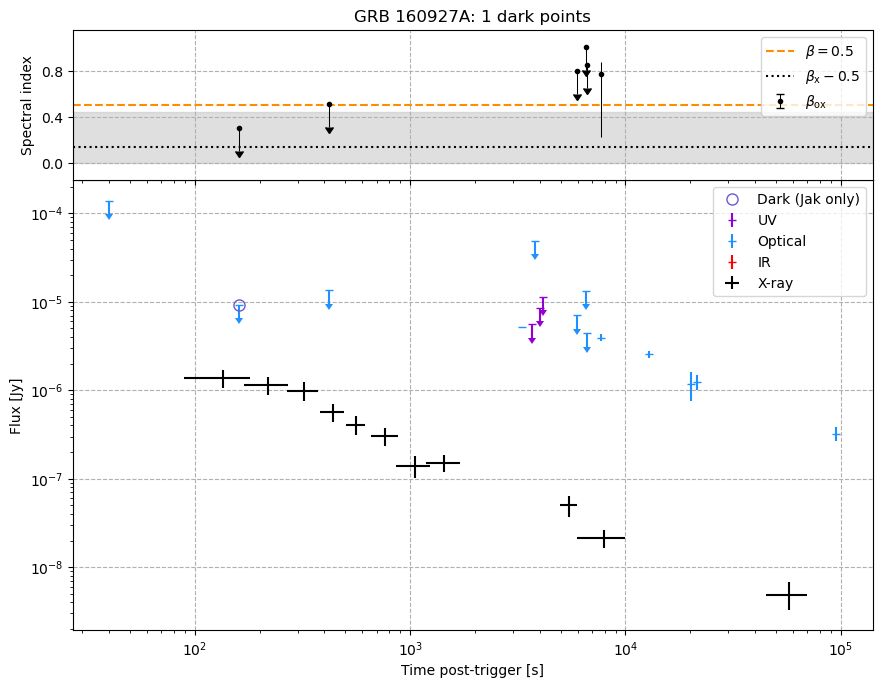

GRB     t_o       dt%  \
1891  160927A   160.0  0.186486   
1892  160927A   422.0  0.034057   
1893  160927A  5942.0  0.090128   
1895  160927A  6526.5  0.179150   
1896  160927A  6634.5  0.165566   
1897  160927A  7668.0  0.035581   

                                             B_ox_w_err                 B_x  \
1891    0.3043567855111735 (+0.09307714658151692, -inf)  0.64 (+0.3, -0.14)   
1892    0.5119706378540153 (+0.07872137712422937, -inf)  0.64 (+0.3, -0.14)   
1893    0.7987395538970372 (+0.12128864425471846, -inf)  0.64 (+0.3, -0.14)   
1895     1.0063520146383453 (+0.1526769050409731, -inf)  0.64 (+0.3, -0.14)   
1896    0.8486969497498111 (+0.13487195914901204, -inf)  0.64 (+0.3, -0.14)   
1897  0.7731784924860126 (+0.10199340349470369, -0.5...  0.64 (+0.3, -0.14)   

         α Jak_dark vdH_dark  
1891  1.02     True    False  
1892  1.02    False    False  
1893  1.02    False    False  
1895  1.02    False    False  
1896  1.02    False    False  
1897  1.02    False    False

1 0 3


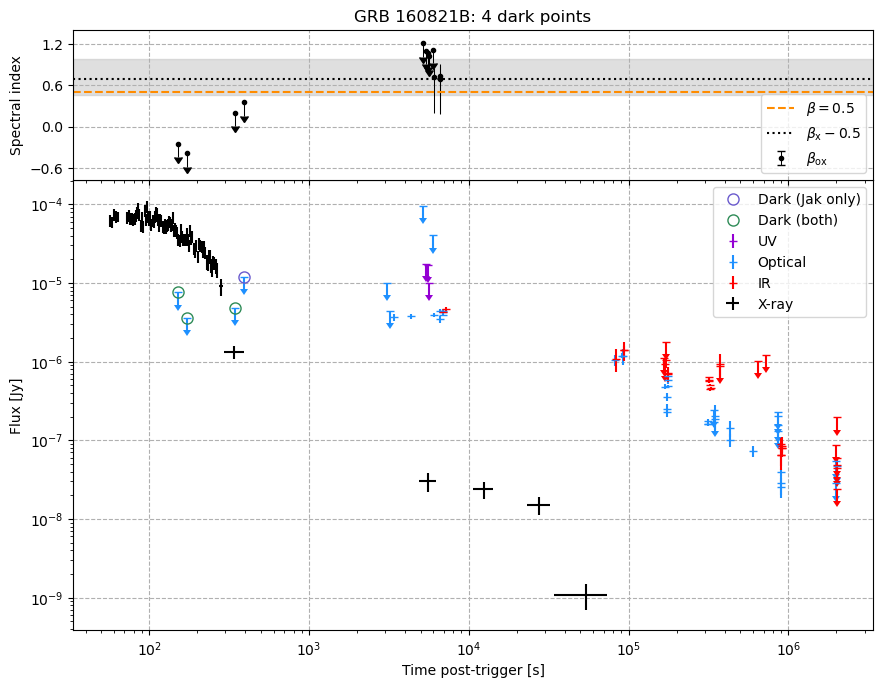

GRB     t_o       dt%  \
1910  160821B   151.0  0.006749   
1933  160821B   172.8  0.006823   
1946  160821B   345.6  0.013968   
1947  160821B   394.5  0.157438   
1948  160821B  5180.0  0.066369   
1949  160821B  5385.0  0.029421   
1950  160821B  5591.0  0.007708   
1951  160821B  5657.0  0.019604   
1952  160821B  6001.0  0.081606   
1953  160821B  6048.0  0.090077   
1954  160821B  6566.4  0.183512   
1955  160821B  6588.0  0.187405   

                                             B_ox_w_err                 B_x  \
1910   -0.2475183058201295 (+0.04262286347909809, -inf)  1.2 (+0.28, -0.24)   
1933   -0.3891564442367287 (+0.05869908696221627, -inf)  1.2 (+0.28, -0.24)   
1946   0.20504740497975443 (+0.04286303429745853, -inf)  1.2 (+0.28, -0.24)   
1947   0.35364396325784125 (+0.14527064340318116, -inf)  1.2 (+0.28, -0.24)   
1948     1.2146676997941956 (+0.1675261705503998, -inf)  1.2 (+0.28, -0.24)   
1949     1.1042728740123586 (+0.1676601540688427, -inf)  1.2 (+0.28, -0.24)   
1950     1.067672678434761 (+0.15582804961585944, -inf)  1.2 (+0.28, -0.24)   
1951      1.02165646869779 (+0.15719606617208984, -inf)  1.2 (+0.28, -0.24)   
1952      1.121564109014966 (+0.1669021590624872, -inf)  1.2 (+0.28, -0.24)   
1953  0.7211540772861706 (+0.12523509619105466, -0.5...  1.2 (+0.28, -0.24)   
1954  0.6965031238722958 (+0.18105677167979525, -0.5...  1.2 (+0.28, -0.24)   
1955  0.7331385415285029 (+0.18541600964331537, -0.5...  1.2 (+0.28, -0.24)   

         α Jak_dark vdH_dark  
1910  2.11     True     True  
1933  2.11     True     True  
1946  2.11     True     True  
1947  2.11     True    False  
1948  2.11    False    False  
1949  2.11    False    False  
1950  2.11    False    False  
1951  2.11    False    False  
1952  2.11    False    False  
1953  2.11    False    False  
1954  2.11    False    False  
1955  2.11    False    False

2 0 0


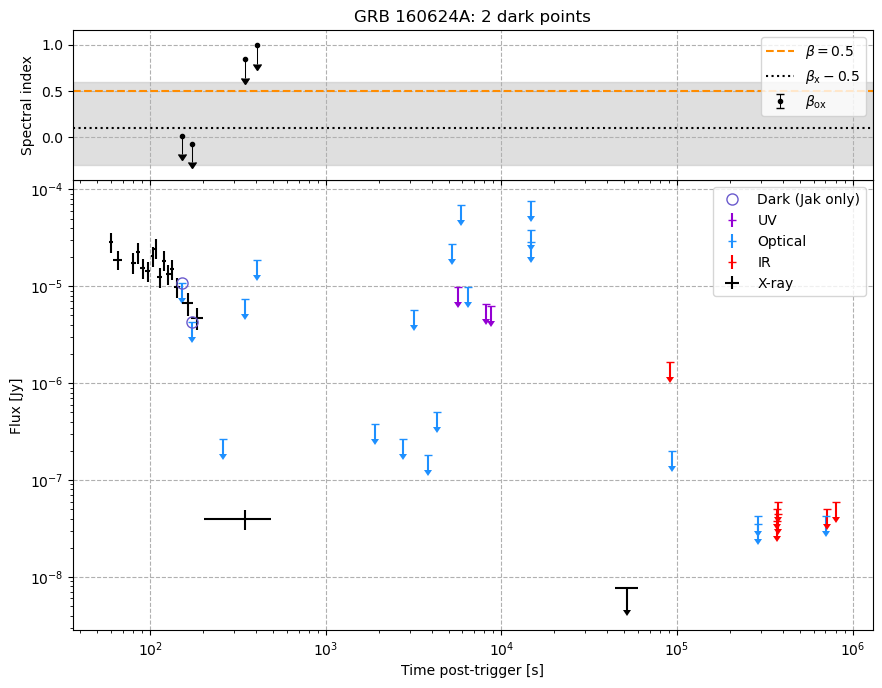

GRB    t_o       dt%  \
1957  160624A  152.0  0.066876   
1960  160624A  172.8  0.058227   
1962  160624A  345.6  0.001057   
1963  160624A  408.0  0.181804   

                                             B_ox_w_err               B_x  \
1957  0.016029122534107654 (+0.11115362302302455, -inf)  0.6 (+0.5, -0.4)   
1960   -0.07121833377450952 (+0.1012355407851191, -inf)  0.6 (+0.5, -0.4)   
1962    0.8446025265261514 (+0.11847515649000338, -inf)  0.6 (+0.5, -0.4)   
1963    0.9931990848042382 (+0.30414961028143517, -inf)  0.6 (+0.5, -0.4)   

         α Jak_dark vdH_dark  
1957  3.74     True    False  
1960  3.74     True    False  
1962  3.74    False    False  
1963  3.74    False    False

1 0 0


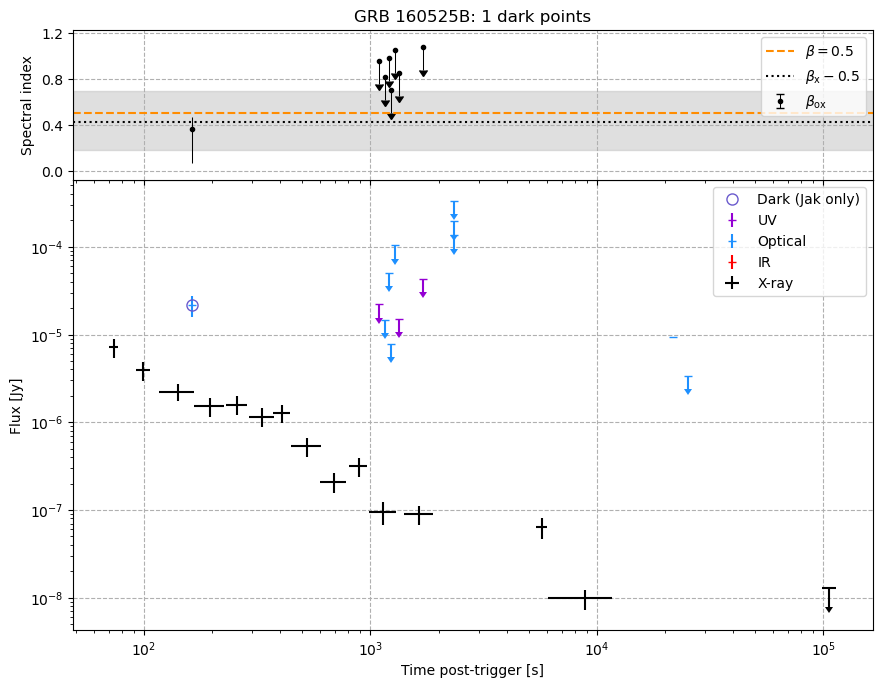

GRB     t_o       dt%  \
1966  160525B   163.0  0.147346   
1968  160525B  1089.5  0.042582   
1969  160525B  1159.0  0.018492   
1970  160525B  1213.0  0.065945   
1971  160525B  1237.5  0.087475   
1972  160525B  1288.0  0.131853   
1973  160525B  1338.0  0.175791   
1975  160525B  1699.0  0.033456   

                                             B_ox_w_err                  B_x  \
1966  0.3610739023388736 (+0.11017183909020013, -0.2...  0.93 (+0.27, -0.25)   
1968     0.9598085722444535 (+0.1505824681624388, -inf)  0.93 (+0.27, -0.25)   
1969    0.8143470698290319 (+0.11839210478964385, -inf)  0.93 (+0.27, -0.25)   
1970     0.9806204332284915 (+0.1393219176331166, -inf)  0.93 (+0.27, -0.25)   
1971     0.7016803005209801 (+0.1140647789965363, -inf)  0.93 (+0.27, -0.25)   
1972    1.0553819432716813 (+0.15683502083892772, -inf)  0.93 (+0.27, -0.25)   
1973    0.8554296117309526 (+0.16068101171700047, -inf)  0.93 (+0.27, -0.25)   
1975     1.0756229807785804 (+0.1617684866363984, -inf)  0.93 (+0.27, -0.25)   

         α Jak_dark vdH_dark  
1966  1.37     True    False  
1968  1.37    False    False  
1969  1.37    False    False  
1970  1.37    False    False  
1971  1.37    False    False  
1972  1.37    False    False  
1973  1.37    False    False  
1975  1.37    False    False

1 0 0


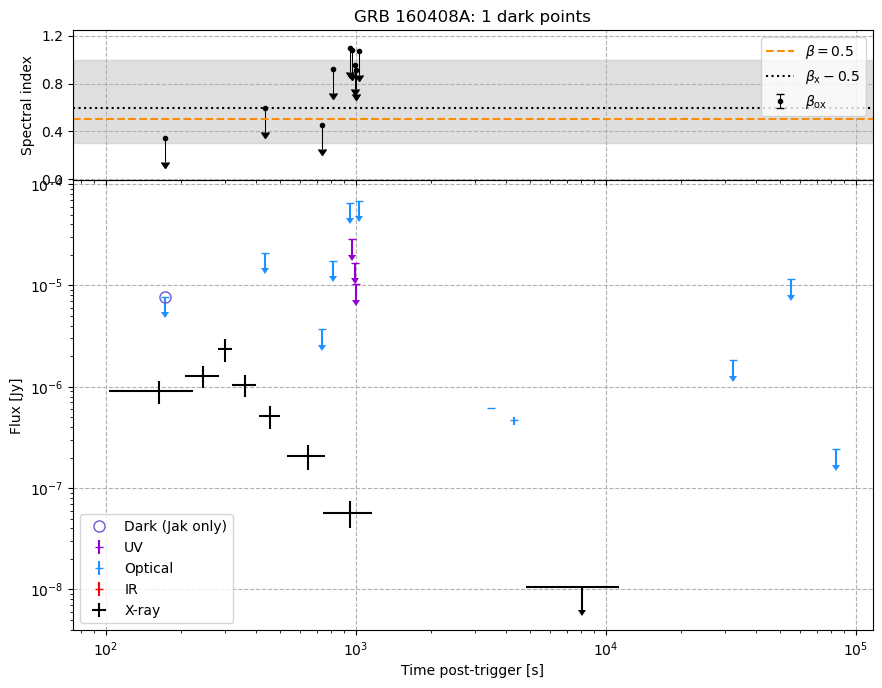

GRB     t_o       dt%  \
1985  160408A   173.0  0.054962   
1986  160408A   436.0  0.041864   
1987  160408A   731.5  0.138956   
1988  160408A   813.5  0.143116   
1989  160408A   953.0  0.003824   
1990  160408A   965.0  0.016464   
1991  160408A   991.0  0.043850   
1992  160408A  1003.5  0.057017   
1993  160408A  1027.5  0.082297   

                                            B_ox_w_err               B_x    α  \
1985  0.34126947057766777 (+0.07021671202580733, -inf)  1.1 (+0.4, -0.3)  1.6   
1986   0.5993653899235445 (+0.09371923045970519, -inf)  1.1 (+0.4, -0.3)  1.6   
1987   0.4573872007139887 (+0.11687892821479748, -inf)  1.1 (+0.4, -0.3)  1.6   
1988     0.923676687657931 (+0.1616111918922529, -inf)  1.1 (+0.4, -0.3)  1.6   
1989   1.0987643700872323 (+0.14916506024123694, -inf)  1.1 (+0.4, -0.3)  1.6   
1990   1.0815420104347433 (+0.16431121885624947, -inf)  1.1 (+0.4, -0.3)  1.6   
1991   0.9587096886990327 (+0.14590892958416357, -inf)  1.1 (+0.4, -0.3)  1.6   
1992   0.9147261680070717 (+0.14828830532504972, -inf)  1.1 (+0.4, -0.3)  1.6   
1993    1.0699514831396904 (+0.1511419161158295, -inf)  1.1 (+0.4, -0.3)  1.6   

     Jak_dark vdH_dark  
1985     True    False  
1986    False    False  
1987    False    False  
1988    False    False  
1989    False    False  
1990    False    False  
1991    False    False  
1992    False    False  
1993    False    False

1 0 2


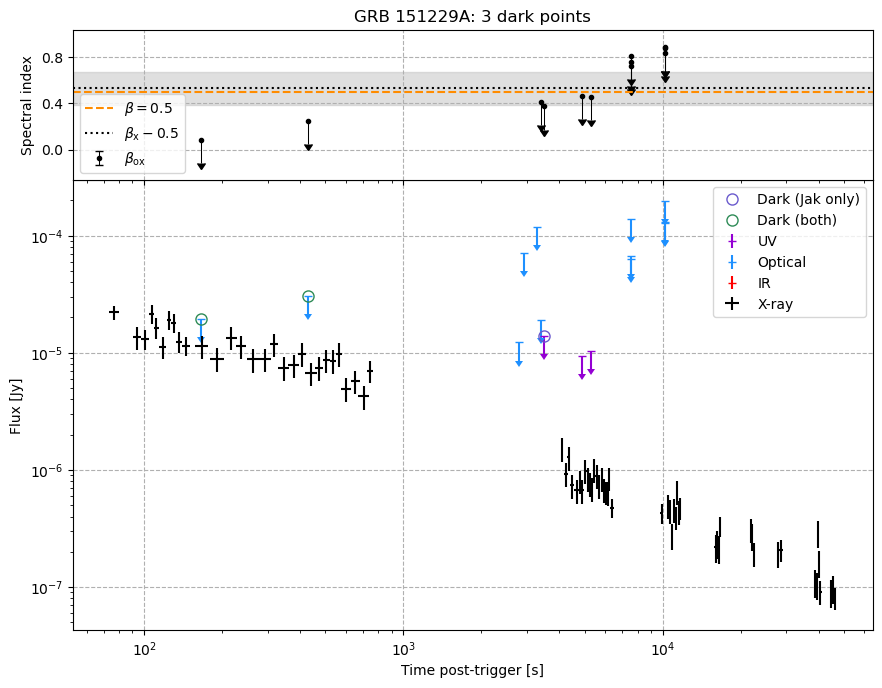

GRB        t_o       dt%  \
1996  151229A    165.000  0.009318   
2000  151229A    427.000  0.031102   
2003  151229A   3407.500  0.168752   
2005  151229A   3497.500  0.146797   
2014  151229A   4881.500  0.003939   
2031  151229A   5291.000  0.004618   
2042  151229A   7533.000  0.180161   
2043  151229A   7533.000  0.180161   
2044  151229A   7533.000  0.180161   
2045  151229A  10172.736  0.025007   
2054  151229A  10172.736  0.025007   
2063  151229A  10172.736  0.025007   

                                             B_ox_w_err          B_x      α  \
1996  0.08551899905655147 (+0.037419935813015996, -inf)  1.03 ± 0.14  0.497   
2000  0.24419921461541708 (+0.048525361239904335, -inf)  1.03 ± 0.14  0.497   
2003   0.40866729611492486 (+0.09212008493579942, -inf)  1.03 ± 0.14  0.950   
2005     0.3734996615407826 (+0.0860956650015564, -inf)  1.03 ± 0.14  0.950   
2014    0.4644253910788263 (+0.07901553636449099, -inf)  1.03 ± 0.14  0.950   
2031     0.4534709302650664 (+0.0765732673538284, -inf)  1.03 ± 0.14  0.950   
2042    0.7537089712252784 (+0.12127242262384737, -inf)  1.03 ± 0.14  0.950   
2043    0.7272558690156109 (+0.11494543007793025, -inf)  1.03 ± 0.14  0.950   
2044    0.8103979885216062 (+0.12056411884043737, -inf)  1.03 ± 0.14  0.950   
2045    0.8838078505832654 (+0.11700752605861212, -inf)  1.03 ± 0.14  0.950   
2054    0.8377419247366603 (+0.10620746740676278, -inf)  1.03 ± 0.14  0.950   
2063      0.87838798259711 (+0.10793835880098035, -inf)  1.03 ± 0.14  0.950   

     Jak_dark vdH_dark  
1996     True     True  
2000     True     True  
2003    False    False  
2005     True    False  
2014    False    False  
2031    False    False  
2042    False    False  
2043    False    False  
2044    False    False  
2045    False    False  
2054    False    False  
2063    False    False

1 0 0


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


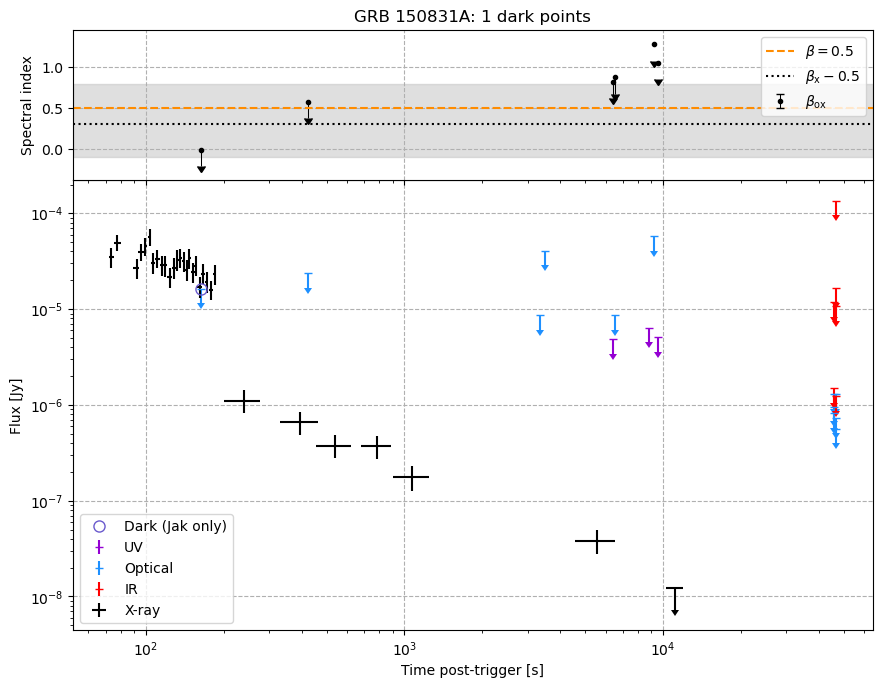

GRB     t_o       dt%  \
2081  150831A   163.0  0.010470   
2086  150831A   425.0  0.072331   
2087  150831A  6396.0  0.150285   
2088  150831A  6542.0  0.176542   
2089  150831A  9258.0  0.167377   
2090  150831A  9592.0  0.137338   

                                             B_ox_w_err               B_x  \
2081  -0.00714602404155144 (+0.038790906752000344, -...  0.8 (+0.5, -0.4)   
2086    0.5787249385195573 (+0.09500633572598878, -inf)  0.8 (+0.5, -0.4)   
2087    0.8181188963369559 (+0.14283691255254122, -inf)  0.8 (+0.5, -0.4)   
2088     0.8761056081892415 (+0.1504578129109857, -inf)  0.8 (+0.5, -0.4)   
2089                           1.2786849871608272 ± inf  0.8 (+0.5, -0.4)   
2090                           1.0501271864637942 ± inf  0.8 (+0.5, -0.4)   

         α Jak_dark vdH_dark  
2081  1.18     True    False  
2086  1.18    False    False  
2087  1.18    False    False  
2088  1.18    False    False  
2089  1.18    False    False  
2090  1.18    False    False

2 0 4


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


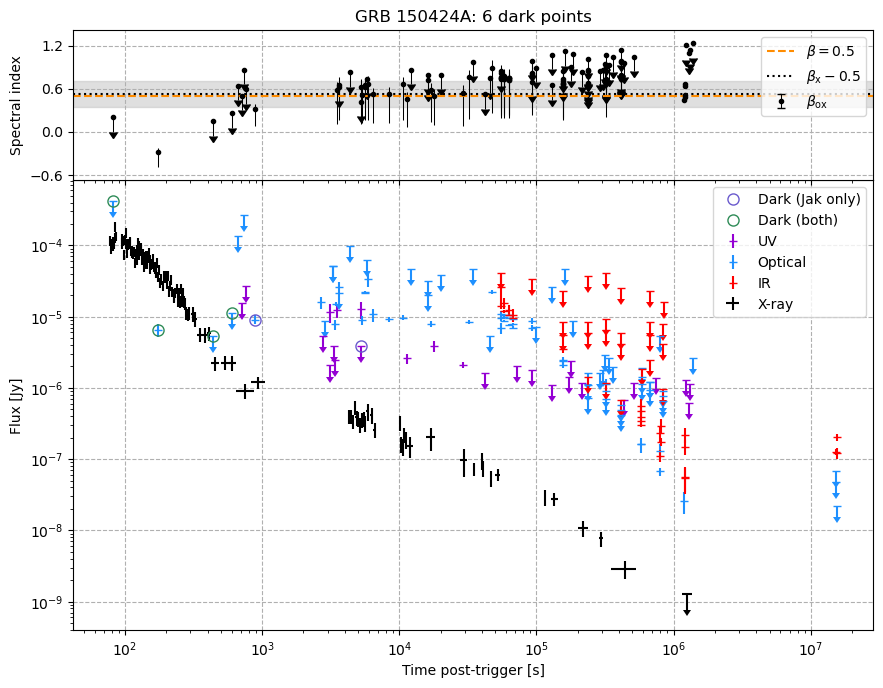

GRB          t_o       dt%  \
2095  150424A       82.000  0.006095   
2121  150424A      174.000  0.002791   
2136  150424A      436.000  0.038665   
2139  150424A      601.000  0.010159   
2140  150424A      664.000  0.093602   
...       ...          ...       ...   
2364  150424A  1206264.096  0.038335   
2365  150424A  1224527.000  0.023775   
2366  150424A  1295417.000  0.032740   
2367  150424A  1310529.000  0.044788   
2368  150424A  1394595.000  0.111807   

                                             B_ox_w_err                  B_x  \
2095   0.2015741817773901 (+0.035108501717430796, -inf)  1.02 (+0.18, -0.17)   
2121  -0.27448807935892167 (+0.055530401460026926, -...  1.02 (+0.18, -0.17)   
2136     0.14382370926139018 (+0.059709905069334, -inf)  1.02 (+0.18, -0.17)   
2139   0.25717748383674716 (+0.05148722044503181, -inf)  1.02 (+0.18, -0.17)   
2140    0.6418120335104655 (+0.09461724595459572, -inf)  1.02 (+0.18, -0.17)   
...                                                 ...                  ...   
2364    0.4877564949109078 (+inf, -0.30963385908012864)  1.02 (+0.18, -0.17)   
2365                           1.2025261435848176 ± inf  1.02 (+0.18, -0.17)   
2366                           1.0901029204818726 ± inf  1.02 (+0.18, -0.17)   
2367                           1.1442678984731742 ± inf  1.02 (+0.18, -0.17)   
2368                           1.2284152302437121 ± inf  1.02 (+0.18, -0.17)   

         α Jak_dark vdH_dark  
2095  1.00     True     True  
2121  2.57     True     True  
2136  2.57     True     True  
2139  2.57     True     True  
2140  0.71    False    False  
...    ...      ...      ...  
2364  1.70    False    False  
2365  1.70    False    False  
2366  1.70    False    False  
2367  1.70    False    False  
2368  1.70    False    False  

[107 rows x 8 columns]

0 0 1


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


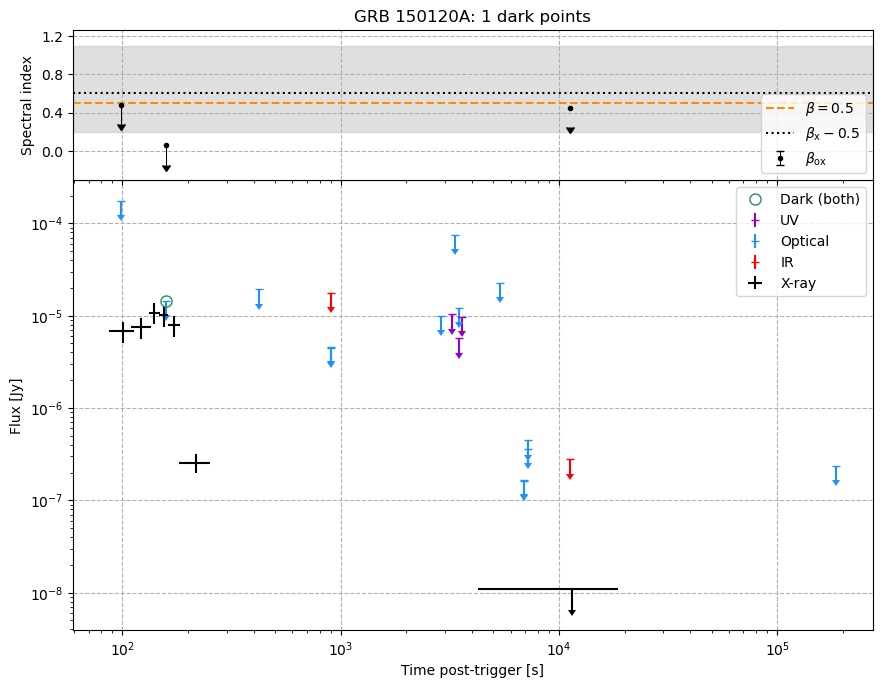

GRB      t_o       dt%  \
2381  150120A     98.0  0.020421   
2384  150120A    158.0  0.022462   
2386  150120A  11232.0  0.020604   

                                           B_ox_w_err               B_x     α  \
2381   0.479977255044103 (+0.07941447192576484, -inf)  1.1 (+0.5, -0.4)  4.38   
2384  0.05687691449590588 (+0.0586804064924505, -inf)  1.1 (+0.5, -0.4)  4.38   
2386                        0.45027988961062976 ± inf  1.1 (+0.5, -0.4)  4.38   

     Jak_dark vdH_dark  
2381    False    False  
2384     True     True  
2386    False    False

1 0 0


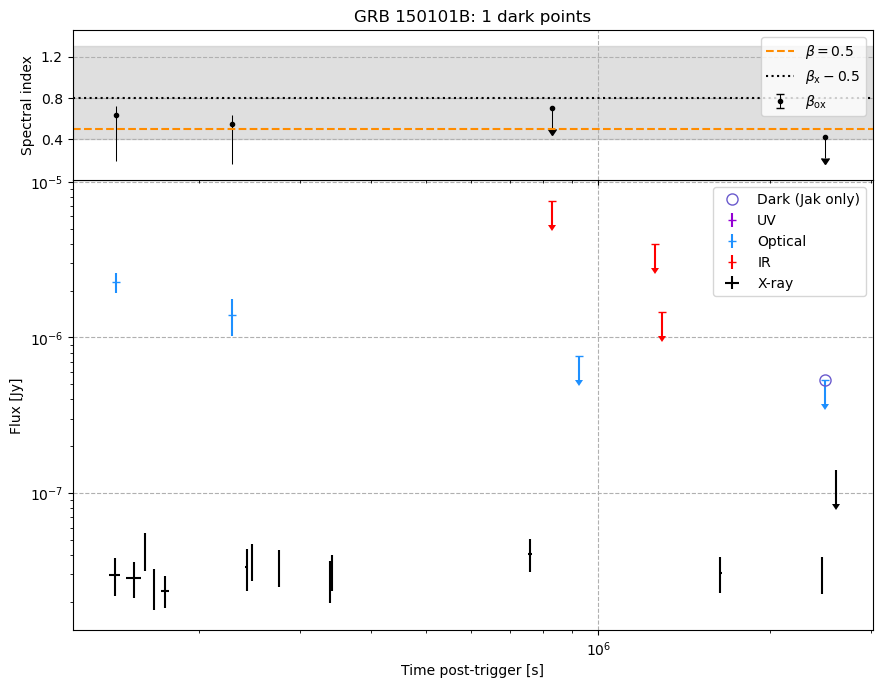

GRB        t_o       dt%  \
2387  150101B   143280.0  0.005732   
2392  150101B   228960.0  0.055246   
2395  150101B   831600.0  0.093281   
2396  150101B  2498400.0  0.013928   

                                             B_ox_w_err               B_x  \
2387  0.6339747633202867 (+0.08915637736992384, -0.4...  1.3 (+0.5, -0.4)   
2392  0.5473913248082393 (+0.09112501007166433, -0.3...  1.3 (+0.5, -0.4)   
2395    0.6994143541072634 (+0.09175470795474887, -inf)  1.3 (+0.5, -0.4)   
2396   0.41836988062206276 (+0.06387739068269137, -inf)  1.3 (+0.5, -0.4)   

        α Jak_dark vdH_dark  
2387  1.0    False    False  
2392  1.0    False    False  
2395  1.0    False    False  
2396  1.0     True    False

1 0 0


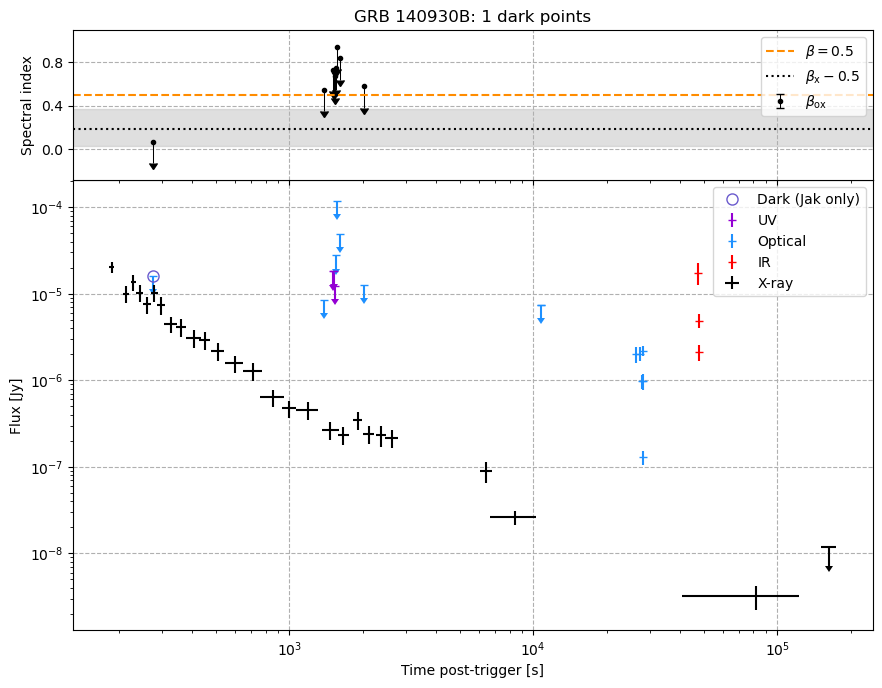

GRB     t_o       dt%  \
2407  140930B   276.0  0.014074   
2411  140930B  1390.0  0.058011   
2413  140930B  1505.5  0.020262   
2415  140930B  1530.5  0.037205   
2418  140930B  1544.0  0.046353   
2421  140930B  1554.5  0.053469   
2425  140930B  1568.0  0.059726   
2428  140930B  1610.0  0.034540   
2431  140930B  2022.0  0.046194   

                                            B_ox_w_err                  B_x  \
2407  0.0715626635639951 (+0.038461031940199515, -inf)  0.69 (+0.18, -0.16)   
2411   0.5481983614433009 (+0.09158713095362558, -inf)  0.69 (+0.18, -0.16)   
2413   0.7324498940525461 (+0.11400294699064774, -inf)  0.69 (+0.18, -0.16)   
2415   0.7133600815291702 (+0.11061259019062646, -inf)  0.69 (+0.18, -0.16)   
2418   0.6747013451038738 (+0.11202262629435358, -inf)  0.69 (+0.18, -0.16)   
2421   0.7485076014419401 (+0.11381619833576342, -inf)  0.69 (+0.18, -0.16)   
2425    0.940398850877426 (+0.13026179788056905, -inf)  0.69 (+0.18, -0.16)   
2428   0.8354381242473943 (+0.11683139642648652, -inf)  0.69 (+0.18, -0.16)   
2431    0.583720111315267 (+0.08588244609846378, -inf)  0.69 (+0.18, -0.16)   

         α Jak_dark vdH_dark  
2407  1.74     True    False  
2411  1.74    False    False  
2413  1.74    False    False  
2415  1.74    False    False  
2418  1.74    False    False  
2421  1.74    False    False  
2425  1.74    False    False  
2428  1.74    False    False  
2431  1.74    False    False

1 0 0


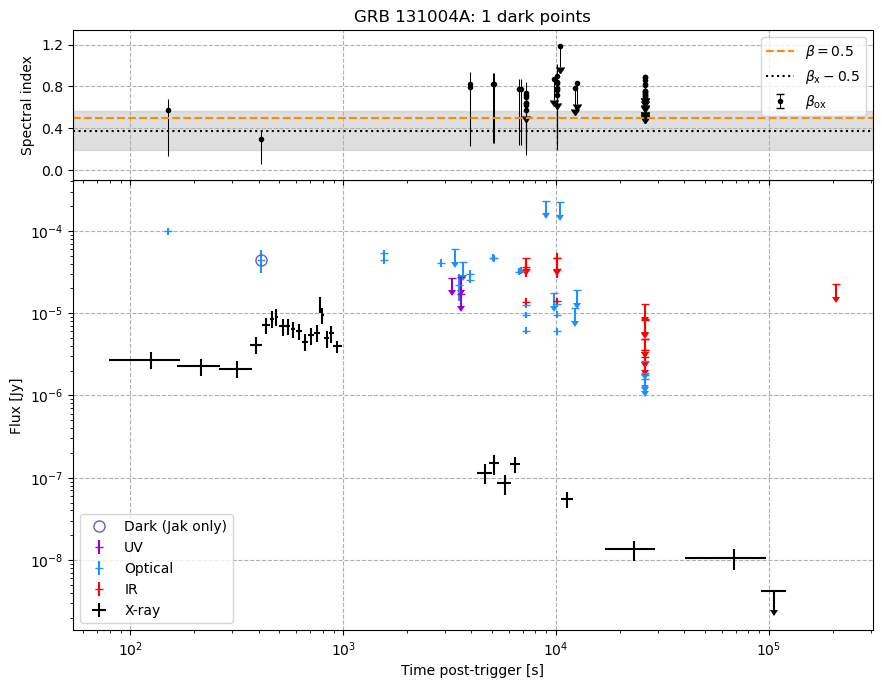

GRB      t_o       dt%  \
2487  131004A    150.0  0.199185   
2489  131004A    412.5  0.051755   
2492  131004A   3960.0  0.147661   
2493  131004A   3960.0  0.147661   
2495  131004A   5040.0  0.013325   
2498  131004A   5106.0  0.000405   
2501  131004A   6678.0  0.041696   
2503  131004A   6840.0  0.066966   
2504  131004A   7200.0  0.123122   
2505  131004A   7200.0  0.123122   
2506  131004A   7200.0  0.123122   
2507  131004A   7200.0  0.123122   
2508  131004A   7200.0  0.123122   
2509  131004A   7200.0  0.123122   
2510  131004A   7200.0  0.123122   
2511  131004A   9720.0  0.138666   
2512  131004A  10080.0  0.106765   
2513  131004A  10080.0  0.106765   
2514  131004A  10080.0  0.106765   
2515  131004A  10080.0  0.106765   
2516  131004A  10080.0  0.106765   
2517  131004A  10080.0  0.106765   
2518  131004A  10080.0  0.106765   
2519  131004A  10440.0  0.074864   
2520  131004A  12240.0  0.084643   
2521  131004A  12600.0  0.116544   
2522  131004A  26208.0  0.134530   
2523  131004A  26208.0  0.134530   
2524  131004A  26208.0  0.134530   
2525  131004A  26208.0  0.134530   
2526  131004A  26208.0  0.134530   
2527  131004A  26208.0  0.134530   
2528  131004A  26280.0  0.137647   
2529  131004A  26280.0  0.137647   
2530  131004A  26280.0  0.137647   
2531  131004A  26280.0  0.137647   
2532  131004A  26280.0  0.137647   
2533  131004A  26280.0  0.137647   

                                             B_ox_w_err                  B_x  \
2487  0.5701365911293371 (+0.11406334761440731, -0.4...  0.87 (+0.19, -0.18)   
2489  0.2949948485695837 (+0.07605737220324377, -0.2...  0.87 (+0.19, -0.18)   
2492  0.818994263043481 (+0.12261997073581882, -0.57...  0.87 (+0.19, -0.18)   
2493  0.7934819335542955 (+0.12022341493557644, -0.5...  0.87 (+0.19, -0.18)   
2495  0.8237025009811003 (+0.10575414404273543, -0.5...  0.87 (+0.19, -0.18)   
2498  0.8235804165812407 (+0.10591618289470928, -0.5...  0.87 (+0.19, -0.18)   
2501  0.7719516163975538 (+0.0993390138694306, -0.53...  0.87 (+0.19, -0.18)   
2503  0.7723064082520155 (+0.10135117998383049, -0.5...  0.87 (+0.19, -0.18)   
2504  0.5786442459953199 (+0.09633431303737088, -0.4...  0.87 (+0.19, -0.18)   
2505  0.6180802015528337 (+0.09687324366469663, -0.4...  0.87 (+0.19, -0.18)   
2506  0.6393739341257555 (+0.09656749524569139, -0.4...  0.87 (+0.19, -0.18)   
2507  0.6366754555575301 (+0.09471102343261567, -0.4...  0.87 (+0.19, -0.18)   
2508  0.7399796709917466 (+0.10313598268681809, -0.4...  0.87 (+0.19, -0.18)   
2509  0.7032153132918811 (+0.09709886432752067, -0.4...  0.87 (+0.19, -0.18)   
2510    0.7200410717469378 (+0.09314300146763566, -inf)  0.87 (+0.19, -0.18)   
2511      0.8677972431663711 (+0.125553742818277, -inf)  0.87 (+0.19, -0.18)   
2512  0.7207391325921415 (+0.10754831142618532, -0.5...  0.87 (+0.19, -0.18)   
2513  0.7619230866559398 (+0.10830463404247268, -0.5...  0.87 (+0.19, -0.18)   
2514  0.7841812637544954 (+0.10794186281829478, -0.5...  0.87 (+0.19, -0.18)   
2515  0.7737914573085923 (+0.10464719214231306, -0.5...  0.87 (+0.19, -0.18)   
2516  0.9029975352918039 (+0.1146997805851153, -0.58...  0.87 (+0.19, -0.18)   
2517  0.8367016326428295 (+0.1070315482918341, -0.52...  0.87 (+0.19, -0.18)   
2518     0.8416085610066762 (+0.1004330339388944, -inf)  0.87 (+0.19, -0.18)   
2519    1.1831497454046538 (+0.14602966370836293, -inf)  0.87 (+0.19, -0.18)   
2520    0.7858856878111916 (+0.10644932938311347, -inf)  0.87 (+0.19, -0.18)   
2521    0.8339687250793366 (+0.11302998421824509, -inf)  0.87 (+0.19, -0.18)   
2522    0.7239667887278759 (+0.11088603775010324, -inf)  0.87 (+0.19, -0.18)   
2523     0.756736641505164 (+0.11152158802827916, -inf)  0.87 (+0.19, -0.18)   
2524    0.8260876465018508 (+0.11622290164553083, -inf)  0.87 (+0.19, -0.18)   
2525    0.8881387711510972 (+0.12025552054883985, -inf)  0.87 (+0.19, -0.18)   
2526    0.8602349973237662 (+0.11508493771866592, -inf)  0.87 (+0.19, -0.18)   
2527    0.8888508128466672 (+0.11459012427263

6 0 0


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


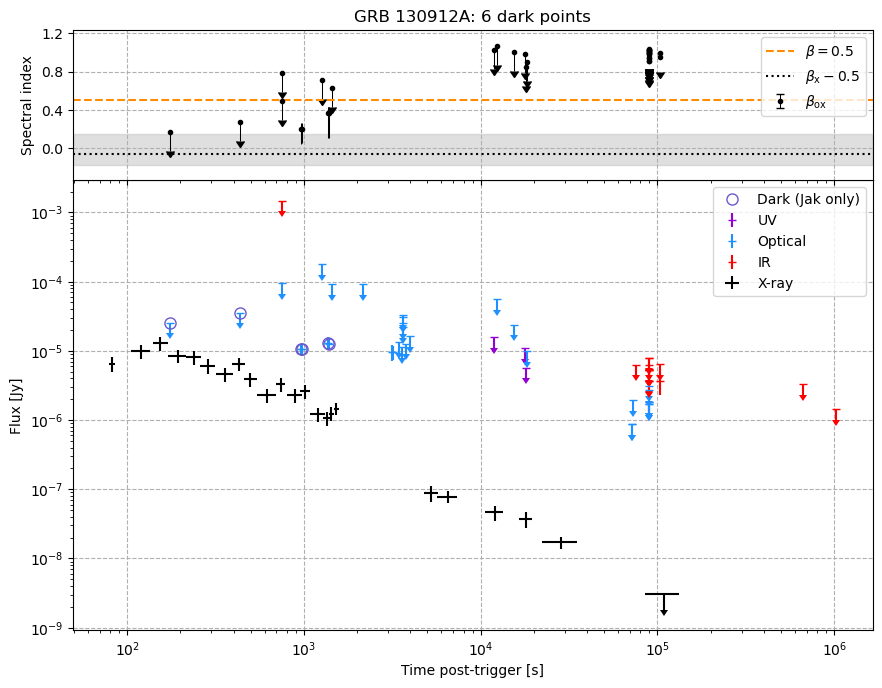

GRB       t_o       dt%  \
2535  130912A     174.0  0.097581   
2536  130912A     436.0  0.014383   
2538  130912A     756.0  0.021285   
2540  130912A     756.0  0.021285   
2543  130912A     960.0  0.055932   
2545  130912A     972.0  0.044131   
2547  130912A    1260.0  0.048603   
2552  130912A    1368.0  0.018486   
2556  130912A    1380.0  0.027420   
2561  130912A    1440.0  0.006277   
2563  130912A   11843.0  0.016180   
2564  130912A   12312.0  0.022781   
2565  130912A   15518.0  0.138390   
2566  130912A   17835.5  0.009715   
2567  130912A   18099.0  0.004916   
2568  130912A   18273.5  0.014604   
2569  130912A   89280.0  0.180952   
2570  130912A   89280.0  0.180952   
2571  130912A   89280.0  0.180952   
2572  130912A   89280.0  0.180952   
2573  130912A   89280.0  0.180952   
2574  130912A   89280.0  0.180952   
2575  130912A   89442.0  0.179466   
2576  130912A   89442.0  0.179466   
2577  130912A   89442.0  0.179466   
2578  130912A   89442.0  0.179466   
2579  130912A   89442.0  0.179466   
2580  130912A   89442.0  0.179466   
2581  130912A   89856.0  0.175668   
2582  130912A   89856.0  0.175668   
2583  130912A   89856.0  0.175668   
2584  130912A  103680.0  0.048848   
2585  130912A  103680.0  0.048848   

                                             B_ox_w_err                  B_x  \
2535   0.17469806075059513 (+0.04296237884195829, -inf)  0.44 (+0.21, -0.11)   
2536   0.27710995138531946 (+0.05124674465275889, -inf)  0.44 (+0.21, -0.11)   
2538     0.498403604536854 (+0.07107055889575084, -inf)  0.44 (+0.21, -0.11)   
2540    0.7910022730423077 (+0.09062556916625857, -inf)  0.44 (+0.21, -0.11)   
2543  0.20673641485801725 (+0.061087462688075155, -0...  0.44 (+0.21, -0.11)   
2545  0.20607087206569014 (+0.05833002401703142, -0....  0.44 (+0.21, -0.11)   
2547     0.7125898447058443 (+0.0949311375006642, -inf)  0.44 (+0.21, -0.11)   
2552  0.36902922012024353 (+0.0646362100262244, -0.2...  0.44 (+0.21, -0.11)   
2556  0.3660680269309475 (+0.06461608223225399, -0.2...  0.44 (+0.21, -0.11)   
2561    0.6331371850569513 (+0.08372954775774044, -inf)  0.44 (+0.21, -0.11)   
2563    1.0262458751785455 (+0.15592848487092512, -inf)  0.44 (+0.21, -0.11)   
2564    1.0726813334922514 (+0.13952511163954928, -inf)  0.44 (+0.21, -0.11)   
2565    1.0080624898441168 (+0.15905519977008806, -inf)  0.44 (+0.21, -0.11)   
2566    0.9868826724602745 (+0.14892229377503743, -inf)  0.44 (+0.21, -0.11)   
2567    0.8500057740964203 (+0.12627298568899908, -inf)  0.44 (+0.21, -0.11)   
2568    0.8998651238423977 (+0.12730931322520947, -inf)  0.44 (+0.21, -0.11)   
2569                            0.943795038246798 ± inf  0.44 (+0.21, -0.11)   
2570                           0.9071824200824065 ± inf  0.44 (+0.21, -0.11)   
2571                           0.9997913382877329 ± inf  0.44 (+0.21, -0.11)   
2572                            1.033748349035115 ± inf  0.44 (+0.21, -0.11)   
2573                           1.0006212504628436 ± inf  0.44 (+0.21, -0.11)   
2574                           1.0174941064907135 ± inf  0.44 (+0.21, -0.11)   
2575                           0.9478678456711476 ± inf  0.44 (+0.21, -0.11)   
2576                            0.910581913979418 ± inf  0.44 (+0.21, -0.11)   
2577                           0.9973131927875805 ± inf  0.44 (+0.21, -0.11)   
2578                           1.0279997349045287 ± inf  0.44 (+0.21, -0.11)   
2579                             1.00003721354338 ± inf  0.44 (+0.21, -0.11)   
2580                           1.0203789973484438 ± inf  0.44 (+0.21, -0.11)   
2581                           1.0283035393026794 ± inf  0.44 (+0.21, -0.11)   
2582                            0.975438200435569 ± inf  0.44 (+0.21, -0.11)   
2583                            1.024730150773578 ± inf  0.44 (+0.21, -0.11)   
2584      0.949950105198353 (+inf, -0.6103666594625996)  0.44 (+0.21, -0.11)   
2585                           0.9922238075116937 ± inf  0.44 (+0.21, -0.11)   

          α Jak_dark vdH_dark 

3 0 1


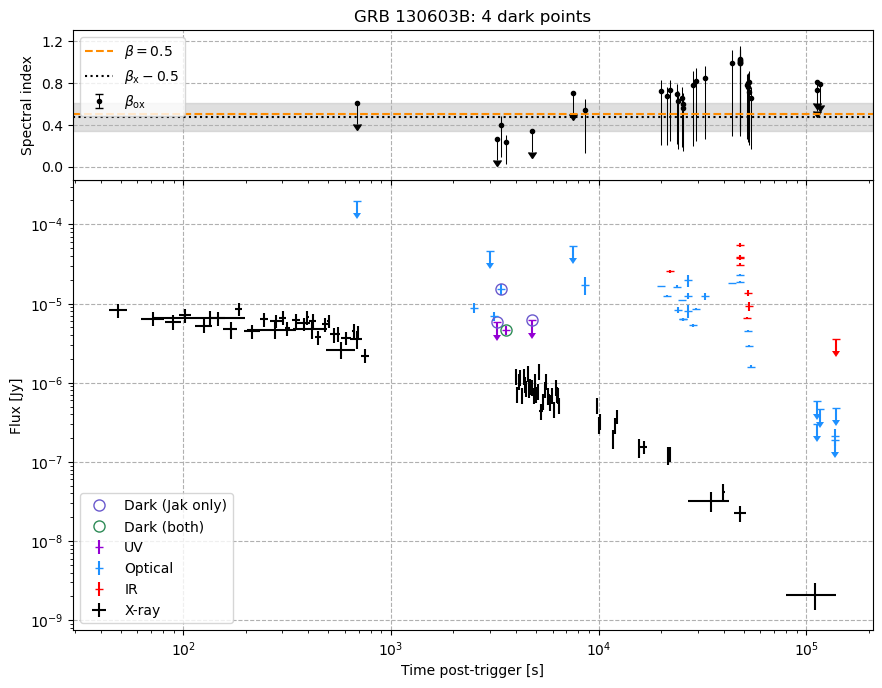

GRB       t_o       dt%  \
2591  130603B     684.0  0.002010   
2594  130603B    3228.0  0.192008   
2595  130603B    3371.0  0.156214   
2599  130603B    3567.5  0.107029   
2617  130603B    4778.5  0.003995   
2631  130603B    7560.0  0.166473   
2632  130603B    8640.0  0.122872   
2635  130603B   19966.0  0.071671   
2637  130603B   21240.0  0.012436   
2640  130603B   21960.0  0.000325   
2642  130603B   23760.0  0.081616   
2644  130603B   24120.0  0.098004   
2646  130603B   25200.0  0.147168   
2648  130603B   25560.0  0.163556   
2650  130603B   25560.0  0.163556   
2651  130603B   28440.0  0.182735   
2652  130603B   29520.0  0.151699   
2653  130603B   32400.0  0.068938   
2656  130603B   43920.0  0.086440   
2657  130603B   48222.0  0.003044   
2658  130603B   48222.0  0.003044   
2659  130603B   48222.0  0.003044   
2660  130603B   48222.0  0.003044   
2661  130603B   48222.0  0.003044   
2662  130603B   48222.0  0.003044   
2663  130603B   51840.0  0.078301   
2664  130603B   52200.0  0.085789   
2665  130603B   52560.0  0.093277   
2666  130603B   52920.0  0.100765   
2667  130603B   53280.0  0.108254   
2668  130603B   54000.0  0.123230   
2669  130603B  112320.0  0.022837   
2670  130603B  112320.0  0.022837   
2671  130603B  115920.0  0.055620   

                                             B_ox_w_err                  B_x  \
2591    0.6078781263385069 (+0.08355372447295904, -inf)  0.97 (+0.14, -0.13)   
2594   0.26394949664177414 (+0.09270423714248009, -inf)  0.97 (+0.14, -0.13)   
2595  0.3960732673214488 (+0.09202276246160318, -0.3...  0.97 (+0.14, -0.13)   
2599  0.23472142341616253 (+0.07196853096636335, -0....  0.97 (+0.14, -0.13)   
2617    0.3388014195293753 (+0.06297704697217059, -inf)  0.97 (+0.14, -0.13)   
2631    0.6998160746654591 (+0.11489984391839136, -inf)  0.97 (+0.14, -0.13)   
2632  0.5438911622301633 (+0.10182022839295, -0.4111...  0.97 (+0.14, -0.13)   
2635  0.7240281151065281 (+0.10125926241914775, -0.5...  0.97 (+0.14, -0.13)   
2637  0.6749244162748006 (+0.09023153270581252, -0.4...  0.97 (+0.14, -0.13)   
2640  0.733617343661548 (+0.08992005192332252, -0.48...  0.97 (+0.14, -0.13)   
2642  0.6962934580612733 (+0.09519952753985106, -0.4...  0.97 (+0.14, -0.13)   
2644  0.6307979253794036 (+0.09579595077918603, -0.4...  0.97 (+0.14, -0.13)   
2646  0.6563200783582868 (+0.10504443316761983, -0.4...  0.97 (+0.14, -0.13)   
2648  0.5597621866874678 (+0.09917280626187328, -0.3...  0.97 (+0.14, -0.13)   
2650  0.5988969569354411 (+0.10659137357029777, -0.4...  0.97 (+0.14, -0.13)   
2651  0.7848700359066813 (+0.13057452516789403, -0.5...  0.97 (+0.14, -0.13)   
2652  0.8170568987176035 (+0.12290305777781196, -0.5...  0.97 (+0.14, -0.13)   
2653  0.8495881373526624 (+0.11232269034674307, -0.5...  0.97 (+0.14, -0.13)   
2656  0.9882600946421588 (+0.1305096009476505, -0.69...  0.97 (+0.14, -0.13)   
2657  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2658  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2659  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2660  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2661  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2662  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   
2663  0.78517069178922 (+0.10104090058829607, -0.521...  0.97 (+0.14, -0.13)   
2664  0.7981488637810475 (+0.09484883820105608, -0.4...  0.97 (+0.14, -0.13)   
2665  0.75729687839666 (+0.10305064034430474, -0.519...  0.97 (+0.14, -0.13)   
2666  0.8066982658750247 (+0.10501251124397502, -0.5...  0.97 (+0.14, -0.13)   
2667  0.7163490752273707 (+0.10392007083467034, -0.5...  0.97 (+0.14, -0.13)   
2668  0.655956846421642 (+0.10396813995947965, -0.48...  0.97 (+0.14, -0.13)   
2669    0.7341276574976692 (+0.10296883918066316, -inf)  0.97 (+0.14, -0.13)   
2670    0.8064711787908835 (+0.10743470387894533, -inf)  0.97 (+0.14, -0.1

0 0 1


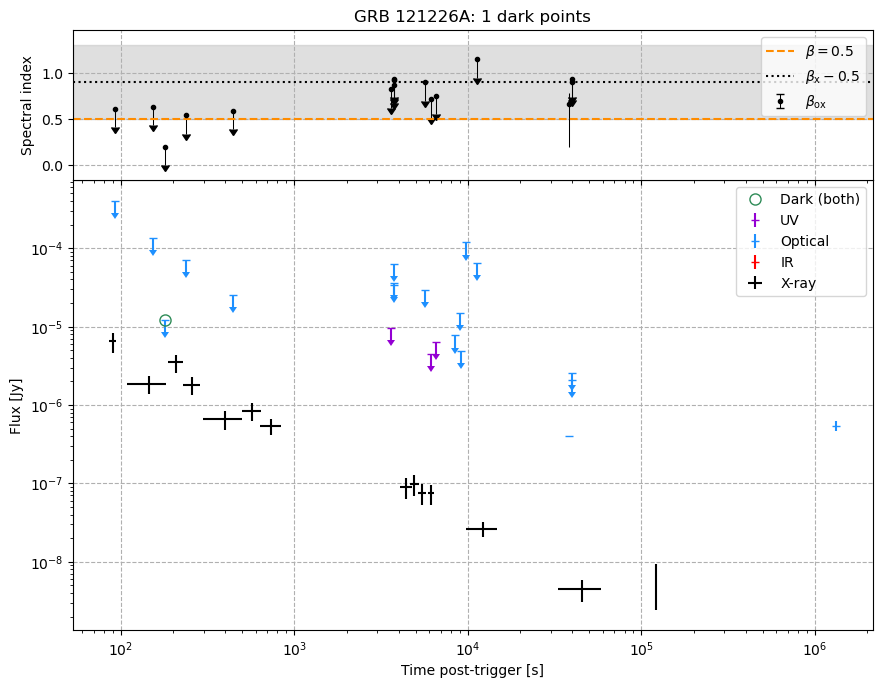

GRB        t_o       dt%  \
2674  121226A     92.800  0.030875   
2675  121226A    153.000  0.046626   
2676  121226A    179.000  0.134643   
2678  121226A    236.500  0.080764   
2679  121226A    441.500  0.104418   
2680  121226A   3621.000  0.175880   
2681  121226A   3743.712  0.147952   
2682  121226A   3743.712  0.147952   
2683  121226A   3743.712  0.147952   
2685  121226A   5681.000  0.038000   
2688  121226A   6146.000  0.004162   
2690  121226A   6543.000  0.069026   
2691  121226A  11301.120  0.077224   
2692  121226A  38520.000  0.153678   
2693  121226A  39906.000  0.123226   
2694  121226A  39960.000  0.122040   

                                             B_ox_w_err        B_x     α  \
2674    0.6088156090616437 (+0.08634601238084468, -inf)  1.4 ± 0.4  1.04   
2675    0.6303637742096536 (+0.08768682196571949, -inf)  1.4 ± 0.4  1.04   
2676   0.19939931994173682 (+0.07480697875377806, -inf)  1.4 ± 0.4  1.04   
2678    0.5374465578628711 (+0.08352019371841622, -inf)  1.4 ± 0.4  1.04   
2679     0.5902808936152806 (+0.1000999711816809, -inf)  1.4 ± 0.4  1.04   
2680      0.819561402244027 (+0.1494082939073408, -inf)  1.4 ± 0.4  1.04   
2681    0.9206772890969991 (+0.14040353908743852, -inf)  1.4 ± 0.4  1.04   
2682     0.8689430854563214 (+0.1300066480569974, -inf)  1.4 ± 0.4  1.04   
2683    0.9331795411056737 (+0.13347299830470952, -inf)  1.4 ± 0.4  1.04   
2685    0.8995901556082243 (+0.12195093387344962, -inf)  1.4 ± 0.4  1.04   
2688    0.7141985260686586 (+0.11486873541557231, -inf)  1.4 ± 0.4  1.04   
2690    0.7499126691477578 (+0.11973299743054248, -inf)  1.4 ± 0.4  1.04   
2691     1.1494055243936507 (+0.1475280687028564, -inf)  1.4 ± 0.4  1.04   
2692  0.6666602519593108 (+0.11410189504339434, -0.4...  1.4 ± 0.4  1.04   
2693     0.9354663179429547 (+0.1339511477807303, -inf)  1.4 ± 0.4  1.04   
2694     0.9035027849596424 (+0.1301357925455047, -inf)  1.4 ± 0.4  1.04   

     Jak_dark vdH_dark  
2674    False    False  
2675    False    False  
2676     True     True  
2678    False    False  
2679    False    False  
2680    False    False  
2681    False    False  
2682    False    False  
2683    False    False  
2685    False    False  
2688    False    False  
2690    False    False  
2691    False    False  
2692    False    False  
2693    False    False  
2694    False    False

2 0 1


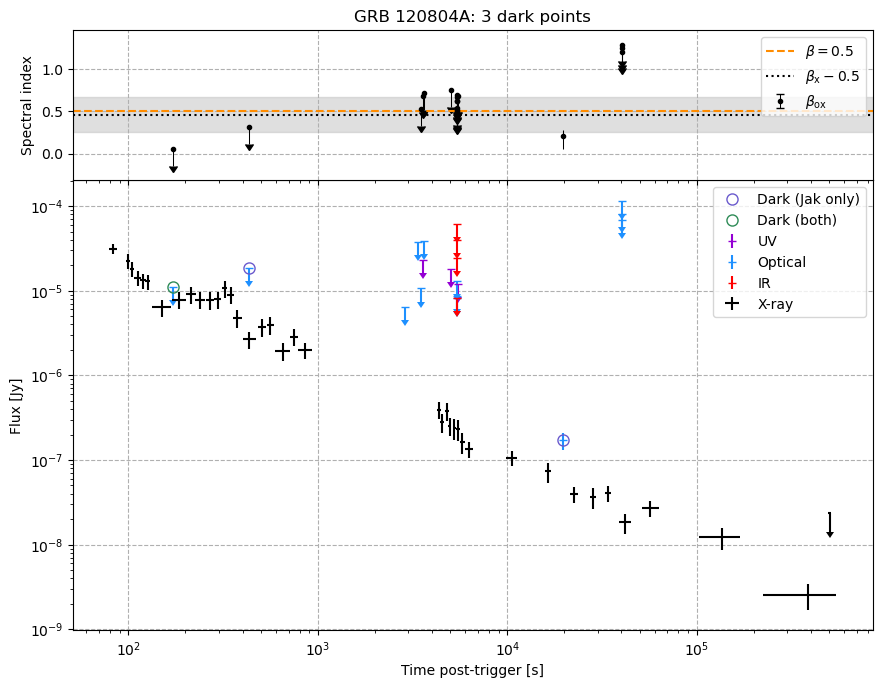

GRB       t_o       dt%  \
2696  120804A    172.00  0.074672   
2699  120804A    435.00  0.000324   
2701  120804A   3501.00  0.193322   
2702  120804A   3588.00  0.173276   
2703  120804A   3636.00  0.162216   
2708  120804A   5054.50  0.016340   
2717  120804A   5400.00  0.020125   
2724  120804A   5400.00  0.020125   
2731  120804A   5400.00  0.020125   
2738  120804A   5400.00  0.020125   
2745  120804A   5400.00  0.020125   
2752  120804A   5400.00  0.020125   
2759  120804A   5400.00  0.020125   
2765  120804A   5464.00  0.008512   
2768  120804A  19800.00  0.123502   
2770  120804A  40249.44  0.043178   
2772  120804A  40249.44  0.043178   
2774  120804A  40249.44  0.043178   

                                             B_ox_w_err                 B_x  \
2696  0.05628116489174747 (+0.049977210728545204, -inf)  0.96 (+0.21, -0.2)   
2699   0.31298462658694176 (+0.05647329959621704, -inf)  0.96 (+0.21, -0.2)   
2701     0.532231975641372 (+0.11610754227675377, -inf)  0.96 (+0.21, -0.2)   
2702     0.6874287498907186 (+0.1283596778443477, -inf)  0.96 (+0.21, -0.2)   
2703    0.7149064339965683 (+0.12208306764084416, -inf)  0.96 (+0.21, -0.2)   
2708    0.7542519044996243 (+0.11814123922088558, -inf)  0.96 (+0.21, -0.2)   
2717     0.6279922299632165 (+0.0915233617193176, -inf)  0.96 (+0.21, -0.2)   
2724     0.5365316167903782 (+0.0777822415319965, -inf)  0.96 (+0.21, -0.2)   
2731    0.5120406906452821 (+0.07291625911560846, -inf)  0.96 (+0.21, -0.2)   
2738     0.501814866425329 (+0.07031722615543273, -inf)  0.96 (+0.21, -0.2)   
2745     0.626452389793607 (+0.07921926873258009, -inf)  0.96 (+0.21, -0.2)   
2752    0.6670276253969813 (+0.08014899505568897, -inf)  0.96 (+0.21, -0.2)   
2759    0.6974654555429578 (+0.08022019242947577, -inf)  0.96 (+0.21, -0.2)   
2765    0.6876323434424885 (+0.10979195808699499, -inf)  0.96 (+0.21, -0.2)   
2768  0.20771521169885515 (+0.07555282701288185, -0....  0.96 (+0.21, -0.2)   
2770    1.2915571486591046 (+0.17087078001922076, -inf)  0.96 (+0.21, -0.2)   
2772     1.2083984399538599 (+0.1532991349541685, -inf)  0.96 (+0.21, -0.2)   
2774      1.25023728503006 (+0.15391740187753122, -inf)  0.96 (+0.21, -0.2)   

          α Jak_dark vdH_dark  
2696  1.095     True     True  
2699  1.095     True    False  
2701  1.095    False    False  
2702  1.095    False    False  
2703  1.095    False    False  
2708  1.095    False    False  
2717  1.095    False    False  
2724  1.095    False    False  
2731  1.095    False    False  
2738  1.095    False    False  
2745  1.095    False    False  
2752  1.095    False    False  
2759  1.095    False    False  
2765  1.095    False    False  
2768  1.095     True    False  
2770  1.095    False    False  
2772  1.095    False    False  
2774  1.095    False    False

1 0 0


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


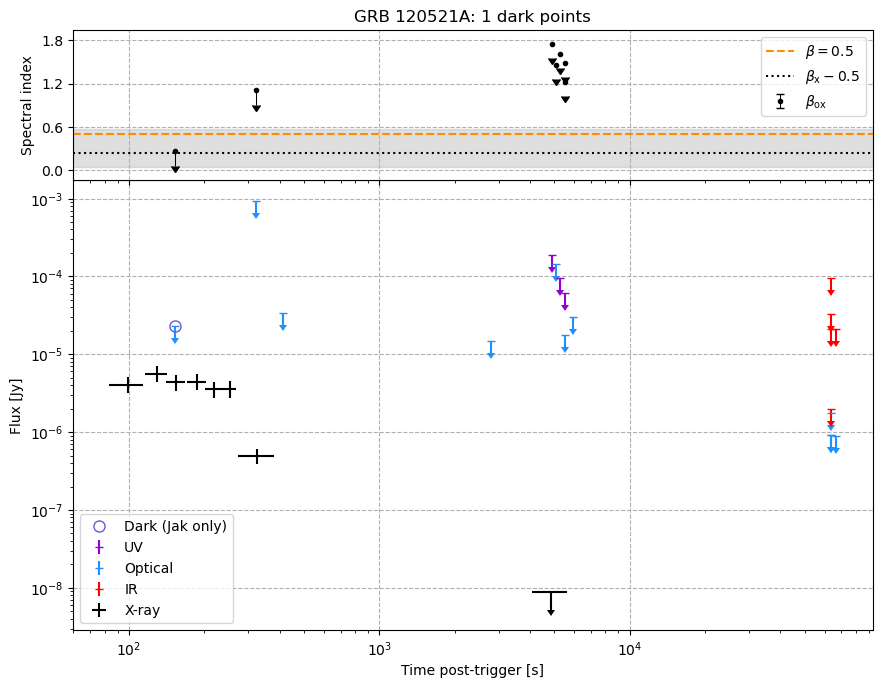

GRB     t_o       dt%  \
2777  120521A   152.0  0.012795   
2779  120521A   321.0  0.013864   
2780  120521A  4879.0  0.006462   
2781  120521A  5083.5  0.048647   
2782  120521A  5288.0  0.090832   
2783  120521A  5494.0  0.133327   
2784  120521A  5532.0  0.141166   

                                           B_ox_w_err                  B_x  \
2777  0.2651610920387164 (+0.05125032743714506, -inf)  0.74 (+0.33, -0.19)   
2779  1.1111432242080963 (+0.13879044173992963, -inf)  0.74 (+0.33, -0.19)   
2780                         1.7568717774256508 ± inf  0.74 (+0.33, -0.19)   
2781                         1.4646922793488397 ± inf  0.74 (+0.33, -0.19)   
2782                         1.6182471864659689 ± inf  0.74 (+0.33, -0.19)   
2783                          1.492644526512864 ± inf  0.74 (+0.33, -0.19)   
2784                          1.229591418162971 ± inf  0.74 (+0.33, -0.19)   

         α Jak_dark vdH_dark  
2777  1.81     True    False  
2779  1.81    False    False  
2780  1.81    False    False  
2781  1.81    False    False  
2782  1.81    False    False  
2783  1.81    False    False  
2784  1.81    False    False

0 0 2


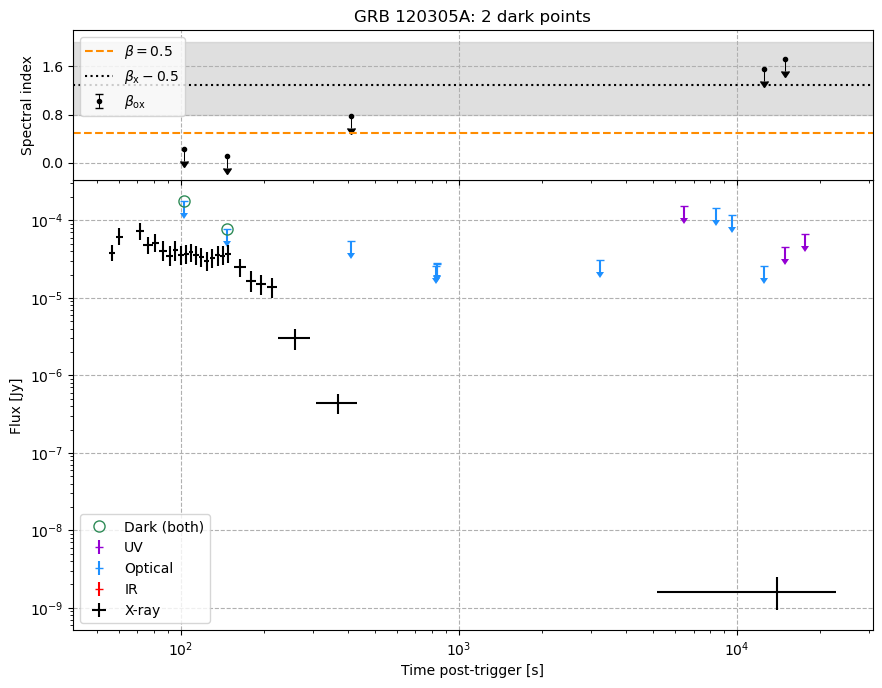

GRB      t_o       dt%  \
2789  120305A    102.6  0.021263   
2798  120305A    146.5  0.013328   
2801  120305A    409.0  0.106261   
2802  120305A  12591.0  0.101245   
2803  120305A  14927.5  0.065536   

                                            B_ox_w_err               B_x    α  \
2789  0.23434243239078842 (+0.04827035871211284, -inf)  1.8 (+0.7, -0.5)  1.0   
2798  0.11611174953625322 (+0.04256203635582089, -inf)  1.8 (+0.7, -0.5)  1.0   
2801   0.7777194093992553 (+0.12128596935904017, -inf)  1.8 (+0.7, -0.5)  1.0   
2802    1.5609192566850651 (+0.2227260987460595, -inf)  1.8 (+0.7, -0.5)  1.0   
2803     1.730362545660643 (+0.2528787778542496, -inf)  1.8 (+0.7, -0.5)  1.0   

     Jak_dark vdH_dark  
2789     True     True  
2798     True     True  
2801    False    False  
2802    False    False  
2803    False    False

2 0 0


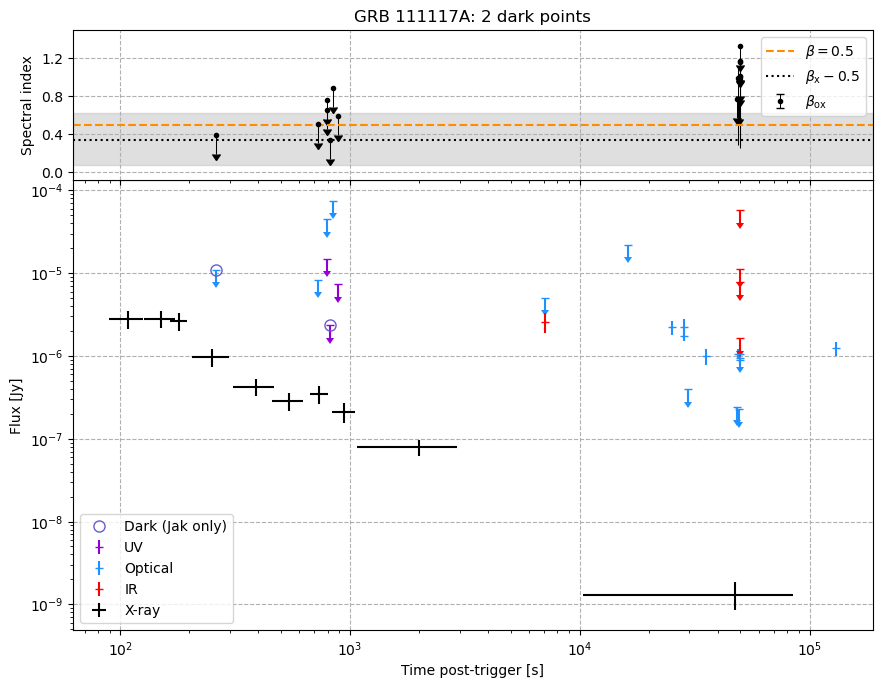

GRB         t_o       dt%  \
2849  111117A    262.0000  0.043833   
2850  111117A    726.0000  0.011143   
2851  111117A    791.5000  0.078072   
2853  111117A    792.5000  0.079434   
2855  111117A    818.0000  0.114167   
2858  111117A    842.0000  0.108830   
2859  111117A    891.5000  0.056439   
2860  111117A  48427.0272  0.019914   
2861  111117A  48600.0000  0.023557   
2862  111117A  49320.0000  0.038721   
2863  111117A  49680.0000  0.046303   
2864  111117A  49680.0000  0.046303   
2865  111117A  49680.0000  0.046303   
2866  111117A  49680.0000  0.046303   
2867  111117A  49680.0000  0.046303   
2868  111117A  49680.0000  0.046303   
2869  111117A  49680.0000  0.046303   

                                             B_ox_w_err                  B_x  \
2849     0.3905048990778049 (+0.0692247526003332, -inf)  0.84 (+0.28, -0.26)   
2850    0.5123333528530377 (+0.07889517860359917, -inf)  0.84 (+0.28, -0.26)   
2851    0.7584226620514276 (+0.11274327040569913, -inf)  0.84 (+0.28, -0.26)   
2853     0.654043512805722 (+0.11130801242033611, -inf)  0.84 (+0.28, -0.26)   
2855     0.33558064651446956 (+0.088064428185012, -inf)  0.84 (+0.28, -0.26)   
2858    0.8865554280444614 (+0.13051412702572085, -inf)  0.84 (+0.28, -0.26)   
2859    0.5982173751247403 (+0.09913765716462393, -inf)  0.84 (+0.28, -0.26)   
2860    0.7724911503331385 (+0.10737959862035301, -inf)  0.84 (+0.28, -0.26)   
2861  0.9922774667210409 (+0.13359302378170204, -0.7...  0.84 (+0.28, -0.26)   
2862     0.762365918849189 (+0.10758602998764742, -inf)  0.84 (+0.28, -0.26)   
2863  1.0198633849735832 (+0.14484047092617952, -0.7...  0.84 (+0.28, -0.26)   
2864  0.969391386510134 (+0.13320127519690458, -0.68...  0.84 (+0.28, -0.26)   
2865    0.9597635168705687 (+0.12635691815407876, -inf)  0.84 (+0.28, -0.26)   
2866    1.0012303955636905 (+0.12797065567643348, -inf)  0.84 (+0.28, -0.26)   
2867     1.1671196520108384 (+0.1396585112439341, -inf)  0.84 (+0.28, -0.26)   
2868    1.1703401836734726 (+0.13494938312352536, -inf)  0.84 (+0.28, -0.26)   
2869     1.3362725942971405 (+0.1464441935591579, -inf)  0.84 (+0.28, -0.26)   

         α Jak_dark vdH_dark  
2849  1.27     True    False  
2850  1.27    False    False  
2851  1.27    False    False  
2853  1.27    False    False  
2855  1.27     True    False  
2858  1.27    False    False  
2859  1.27    False    False  
2860  1.27    False    False  
2861  1.27    False    False  
2862  1.27    False    False  
2863  1.27    False    False  
2864  1.27    False    False  
2865  1.27    False    False  
2866  1.27    False    False  
2867  1.27    False    False  
2868  1.27    False    False  
2869  1.27    False    False

0 0 1


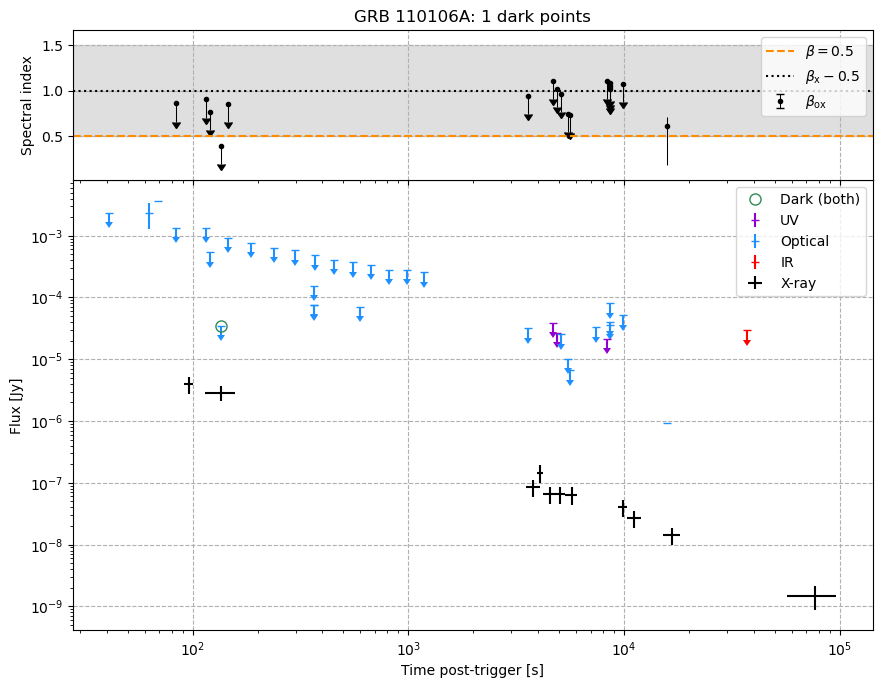

GRB        t_o       dt%  \
2911  110106A     84.000  0.122100   
2912  110106A    115.000  0.150313   
2913  110106A    120.000  0.113370   
2914  110106A    136.000  0.004847   
2915  110106A    146.000  0.078733   
2916  110106A   3605.000  0.050843   
2919  110106A   4710.500  0.038750   
2923  110106A   4915.500  0.029071   
2926  110106A   5120.500  0.011421   
2929  110106A   5527.872  0.033575   
2931  110106A   5652.000  0.011874   
2932  110106A   8317.500  0.158478   
2933  110106A   8584.704  0.131444   
2934  110106A   8584.704  0.131444   
2935  110106A   8584.704  0.131444   
2936  110106A   9866.500  0.001758   
2938  110106A  15876.000  0.048811   

                                             B_ox_w_err        B_x     α  \
2911    0.8593080495883408 (+0.12634664443018587, -inf)  1.5 ± 0.5  1.11   
2912    0.9035345136400693 (+0.13520827245097633, -inf)  1.5 ± 0.5  1.11   
2913    0.7696124028752046 (+0.11452894340993054, -inf)  1.5 ± 0.5  1.11   
2914    0.3955148107219521 (+0.06799658258436435, -inf)  1.5 ± 0.5  1.11   
2915    0.8493401222200034 (+0.11684943222248267, -inf)  1.5 ± 0.5  1.11   
2916    0.9391780818777056 (+0.13489929713373555, -inf)  1.5 ± 0.5  1.11   
2919    1.1105084963677918 (+0.16967385517973407, -inf)  1.5 ± 0.5  1.11   
2923    1.0142646162651325 (+0.15146128137271167, -inf)  1.5 ± 0.5  1.11   
2926    0.9614914061376749 (+0.13775315433323715, -inf)  1.5 ± 0.5  1.11   
2929    0.7456140577600381 (+0.10277377801243866, -inf)  1.5 ± 0.5  1.11   
2931    0.7369708077609889 (+0.10875178530093245, -inf)  1.5 ± 0.5  1.11   
2932    1.1064968854260988 (+0.18455971661089898, -inf)  1.5 ± 0.5  1.11   
2933      1.04626862051361 (+0.15374585570132585, -inf)  1.5 ± 0.5  1.11   
2934     1.013589174375667 (+0.14425501864699544, -inf)  1.5 ± 0.5  1.11   
2935    1.0863205719340059 (+0.14835635242498094, -inf)  1.5 ± 0.5  1.11   
2936     1.0767428033505129 (+0.1423776610053139, -inf)  1.5 ± 0.5  1.11   
2938  0.6147052041805736 (+0.08951424103372473, -0.4...  1.5 ± 0.5  1.11   

     Jak_dark vdH_dark  
2911    False    False  
2912    False    False  
2913    False    False  
2914     True     True  
2915    False    False  
2916    False    False  
2919    False    False  
2923    False    False  
2926    False    False  
2929    False    False  
2931    False    False  
2932    False    False  
2933    False    False  
2934    False    False  
2935    False    False  
2936    False    False  
2938    False    False

1 0 0


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


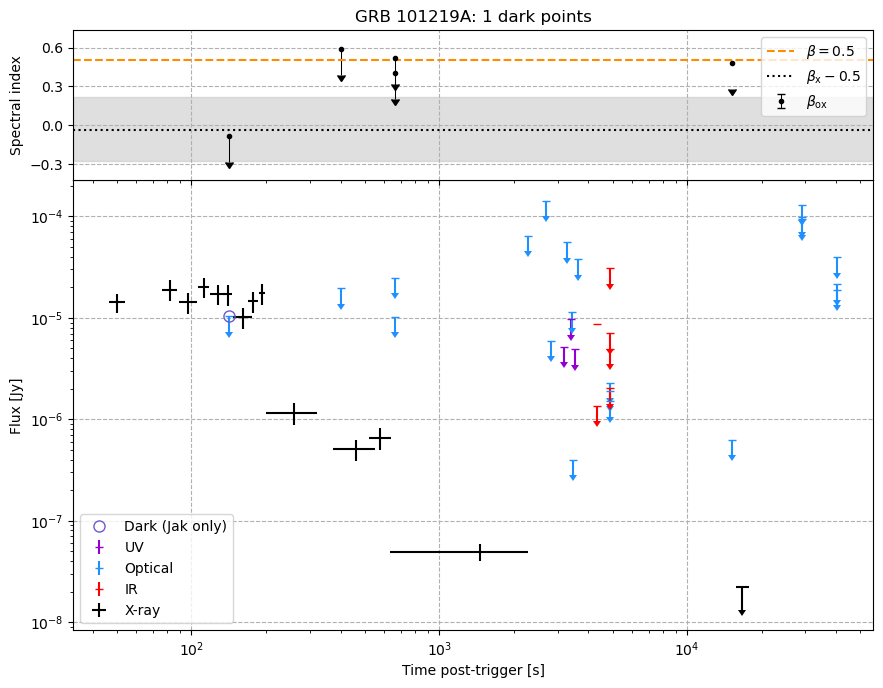

GRB      t_o       dt%  \
2940  101219A    142.0  0.013309   
2943  101219A    403.5  0.125461   
2944  101219A    666.0  0.149386   
2945  101219A    666.0  0.149386   
2946  101219A  15120.0  0.094377   

                                             B_ox_w_err                  B_x  \
2940  -0.08032539371266008 (+0.040495150670132395, -...  0.46 (+0.26, -0.24)   
2943     0.591046242916151 (+0.12275979249258792, -inf)  0.46 (+0.26, -0.24)   
2944   0.40475941311911723 (+0.11768598580283707, -inf)  0.46 (+0.26, -0.24)   
2945    0.5184465105342154 (+0.12281553305501818, -inf)  0.46 (+0.26, -0.24)   
2946                           0.4797443688796422 ± inf  0.46 (+0.26, -0.24)   

         α Jak_dark vdH_dark  
2940  1.67     True    False  
2943  1.67    False    False  
2944  1.67    False    False  
2945  1.67    False    False  
2946  1.67    False    False

1 0 0


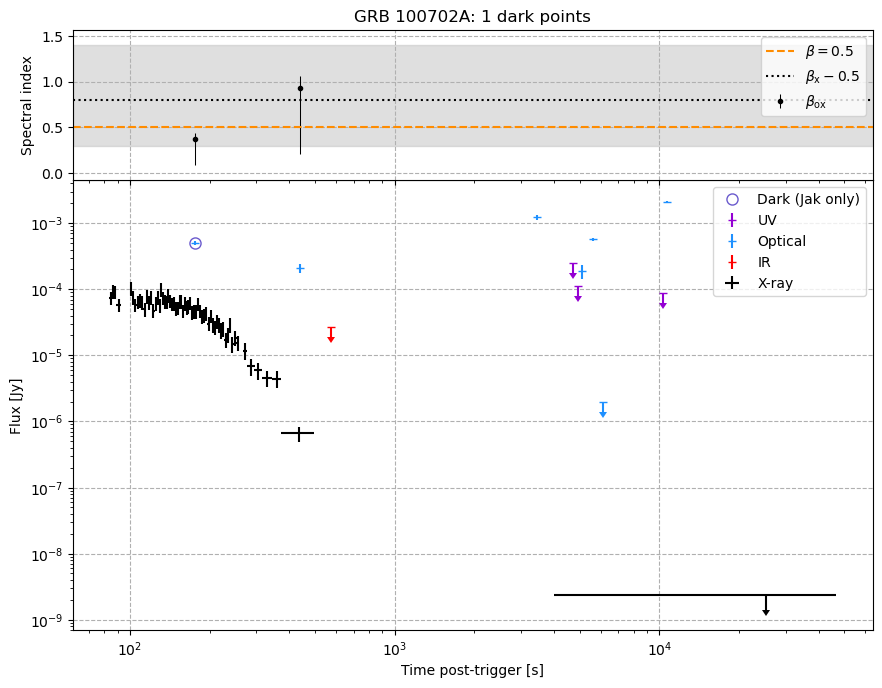

GRB    t_o       dt%  \
3017  100702A  176.0  0.004050   
3030  100702A  439.0  0.011283   

                                             B_ox_w_err               B_x  \
3017  0.3762568652979101 (+0.062115099329621296, -0....  1.3 (+0.6, -0.5)   
3030  0.9281497760085539 (+0.13338508778982908, -0.7...  1.3 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
3017  2.9     True    False  
3030  2.9    False    False

0 1 1


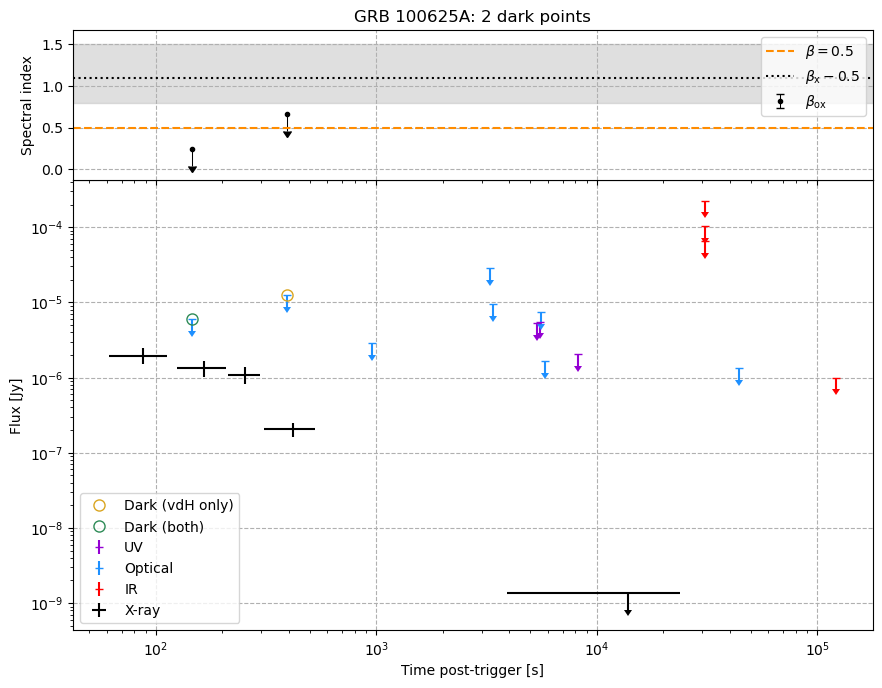

GRB    t_o       dt%  \
3031  100625A  146.5  0.118304   
3032  100625A  394.0  0.059538   

                                            B_ox_w_err               B_x  \
3031  0.23921578602800378 (+0.08643968662355281, -inf)  1.6 (+0.4, -0.3)   
3032    0.661307473055828 (+0.10092550933649871, -inf)  1.6 (+0.4, -0.3)   

         α Jak_dark vdH_dark  
3031  1.45     True     True  
3032  1.45    False     True

0 0 1


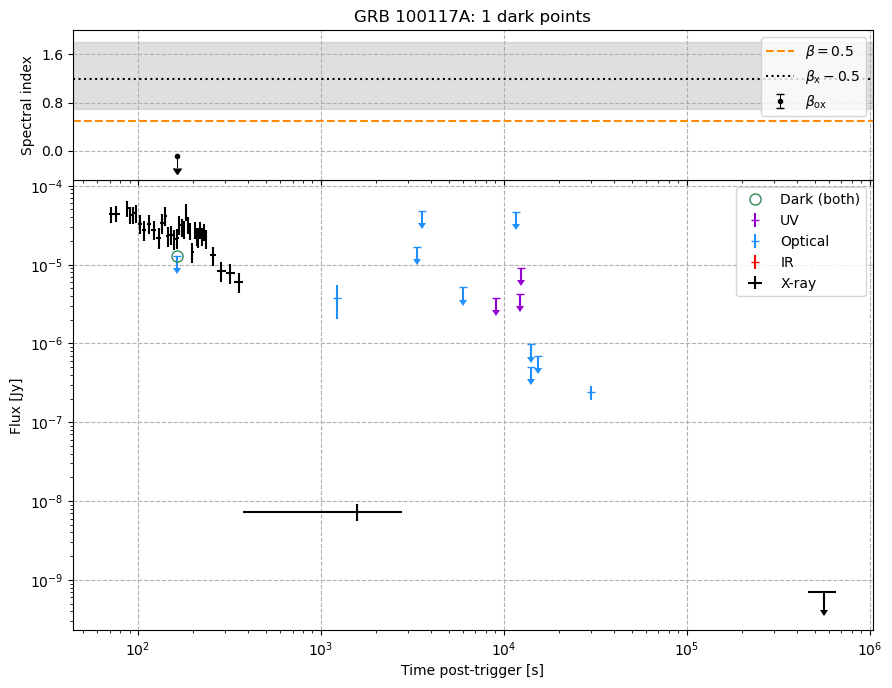

GRB    t_o       dt%  \
3041  100117A  163.5  0.003735   

                                             B_ox_w_err               B_x  \
3041  -0.08384044747938296 (+0.04582344545091656, -inf)  1.7 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
3041  1.0     True     True

0 0 1


C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in double_scalars
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
C:\Users\cgobat\Miniconda3\envs\gwu\lib\site-packages\matplotlib\axes\_axes.py:3601: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


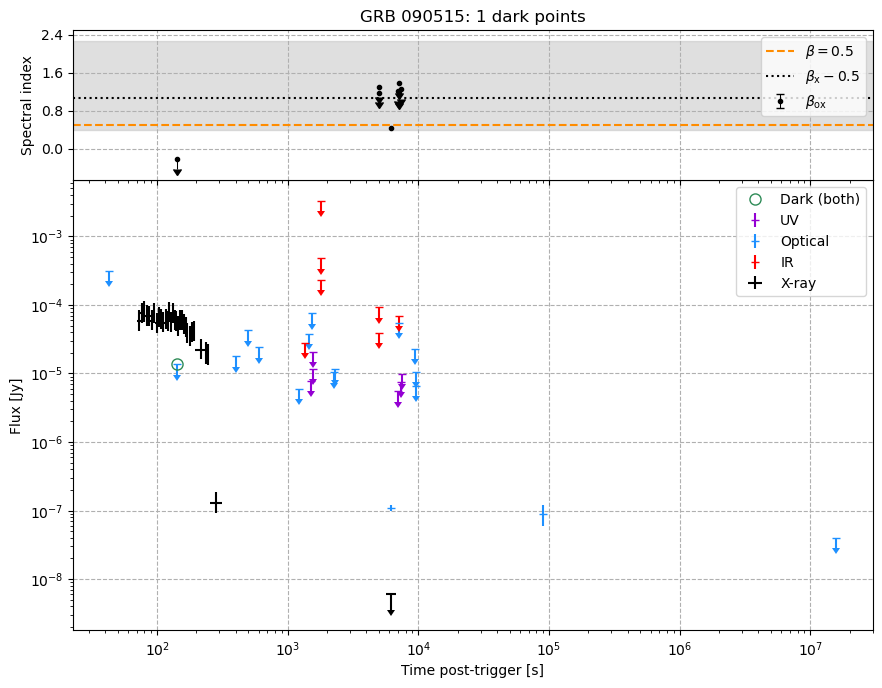

GRB     t_o       dt%  \
3063  090515   141.5  0.007089   
3070  090515  5040.0  0.187907   
3071  090515  5040.0  0.187907   
3072  090515  6120.0  0.013888   
3073  090515  6924.5  0.115741   
3074  090515  7129.0  0.148692   
3075  090515  7140.0  0.150464   
3076  090515  7333.5  0.181643   

                                             B_ox_w_err                  B_x  \
3063  -0.2287223009743839 (+0.054861877896981576, -inf)  1.57 (+1.19, -0.68)   
3070                            1.293431540632887 ± inf  1.57 (+1.19, -0.68)   
3071                            1.178400032404398 ± inf  1.57 (+1.19, -0.68)   
3072     0.4300818397269228 (+inf, -0.3098806896917142)  1.57 (+1.19, -0.68)   
3073                           1.2051310399812327 ± inf  1.57 (+1.19, -0.68)   
3074                           1.3767661920129626 ± inf  1.57 (+1.19, -0.68)   
3075                           1.1699398662176843 ± inf  1.57 (+1.19, -0.68)   
3076                           1.2445968746052147 ± inf  1.57 (+1.19, -0.68)   

         α Jak_dark vdH_dark  
3063  4.49     True     True  
3070  4.49    False    False  
3071  4.49    False    False  
3072  4.49    False    False  
3073  4.49    False    False  
3074  4.49    False    False  
3075  4.49    False    False  
3076  4.49    False    False

7 0 0


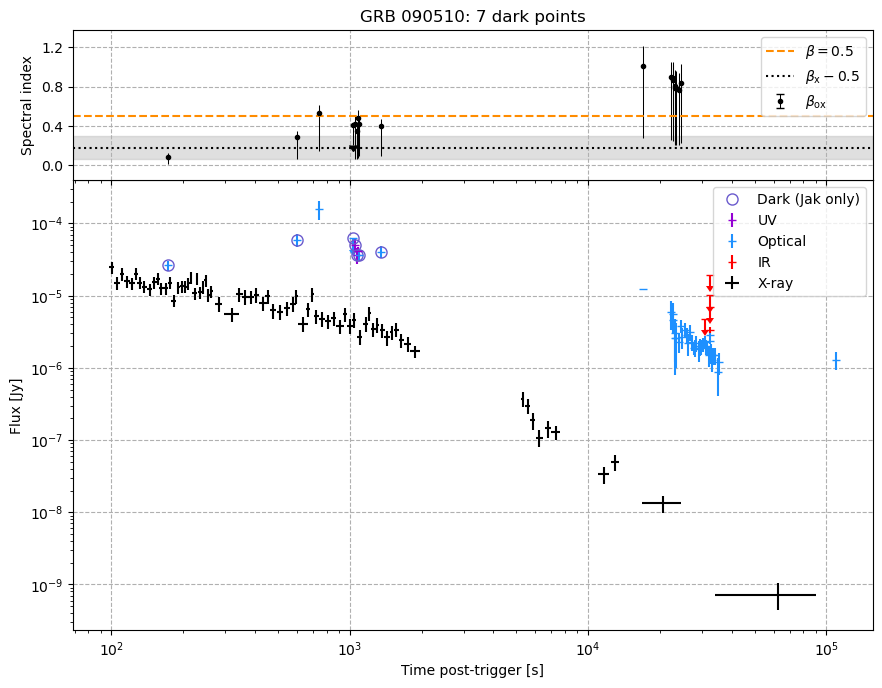

GRB      t_o       dt%  \
3082  090510    172.0  0.018360   
3091  090510    598.0  0.002051   
3100  090510    745.0  0.028477   
3107  090510   1033.0  0.011171   
3115  090510   1048.0  0.003188   
3124  090510   1069.5  0.023768   
3134  090510   1083.0  0.013953   
3143  090510   1094.5  0.003483   
3152  090510   1346.5  0.017940   
3157  090510  16920.0  0.182582   
3158  090510  22320.0  0.078296   
3159  090510  22680.0  0.095688   
3160  090510  22680.0  0.095688   
3161  090510  23040.0  0.113080   
3162  090510  23040.0  0.113080   
3163  090510  23400.0  0.130472   
3164  090510  24120.0  0.165255   
3165  090510  24480.0  0.182647   

                                             B_ox_w_err          B_x     α  \
3082  0.08784455192610077 (+0.04083739134265433, -0....  0.68 ± 0.12  0.66   
3091  0.2830830381506375 (+0.061043597051168914, -0....  0.68 ± 0.12  0.66   
3100  0.5286355783855248 (+0.08745686716508215, -0.3...  0.68 ± 0.12  0.66   
3107    0.4055768160779434 (+0.06336317724028344, -inf)  0.68 ± 0.12  0.66   
3115  0.4174284916801267 (+0.08014109114776327, -0.3...  0.68 ± 0.12  0.66   
3124  0.34726398313115825 (+0.07506029538187704, -0....  0.68 ± 0.12  0.66   
3134  0.47825224660054355 (+0.08570599257051385, -0....  0.68 ± 0.12  0.66   
3143  0.4205399973673835 (+0.07172437802329212, -0.3...  0.68 ± 0.12  0.66   
3152  0.3961574973703175 (+0.06958701930388769, -0.3...  0.68 ± 0.12  0.66   
3157  1.0097524933513828 (+0.20239001077715285, -0.7...  0.68 ± 0.12  2.14   
3158  0.9011947377451318 (+0.14996387322010746, -0.6...  0.68 ± 0.12  2.14   
3159  0.8908206311073994 (+0.15625128960035578, -0.6...  0.68 ± 0.12  2.14   
3160  0.8644152860935175 (+0.15015267634391702, -0.6...  0.68 ± 0.12  2.14   
3161  0.7801056827274128 (+0.17606986321294585, -0.5...  0.68 ± 0.12  2.14   
3162  0.8012517419542088 (+0.1699850622434121, -0.58...  0.68 ± 0.12  2.14   
3163  0.7801056827274128 (+0.17855276549395088, -0.5...  0.68 ± 0.12  2.14   
3164  0.7619886968428493 (+0.1802477891343109, -0.55...  0.68 ± 0.12  2.14   
3165  0.8361829902566151 (+0.19281818342770124, -0.6...  0.68 ± 0.12  2.14   

     Jak_dark vdH_dark  
3082     True    False  
3091     True    False  
3100    False    False  
3107     True    False  
3115     True    False  
3124     True    False  
3134    False    False  
3143     True    False  
3152     True    False  
3157    False    False  
3158    False    False  
3159    False    False  
3160    False    False  
3161    False    False  
3162    False    False  
3163    False    False  
3164    False    False  
3165    False    False

4 0 1


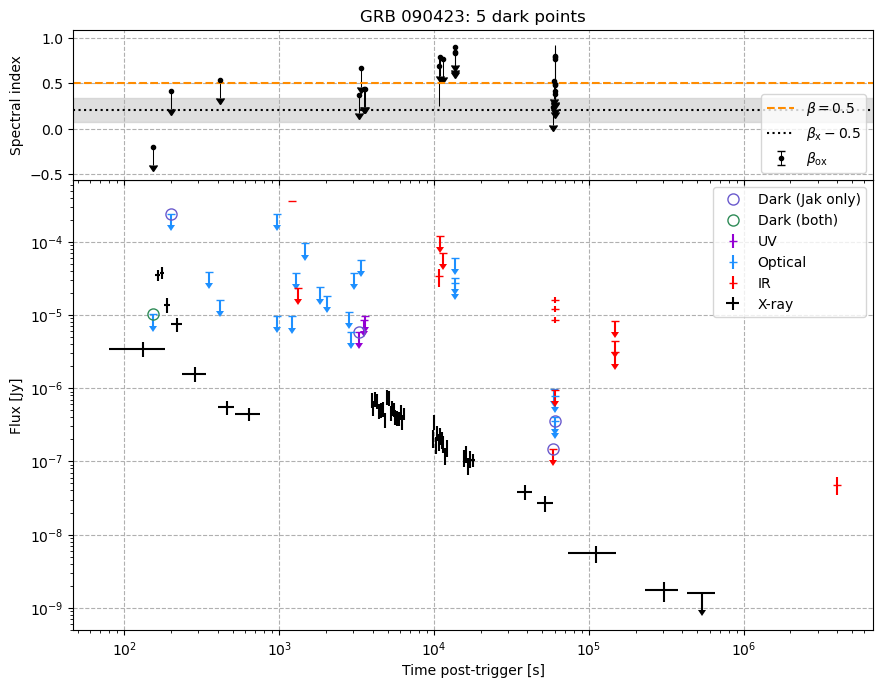

GRB        t_o       dt%  \
3283  090423    152.000  0.073001   
3287  090423    200.000  0.059277   
3289  090423    415.000  0.090313   
3290  090423   3276.000  0.171292   
3292  090423   3390.500  0.142327   
3295  090423   3505.500  0.113237   
3299  090423   3585.500  0.092999   
3308  090423  10693.728  0.006462   
3319  090423  10872.576  0.007603   
3331  090423  11351.232  0.007832   
3337  090423  13716.864  0.124212   
3344  090423  13716.864  0.124212   
3351  090423  13716.864  0.124212   
3355  090423  58500.000  0.118792   
3356  090423  59417.280  0.136334   
3357  090423  60120.000  0.149773   
3358  090423  60120.000  0.149773   
3359  090423  60120.000  0.149773   
3360  090423  60120.000  0.149773   
3361  090423  60120.000  0.149773   
3362  090423  60120.000  0.149773   
3363  090423  60120.000  0.149773   

                                             B_ox_w_err          B_x     α  \
3283  -0.19625502204644998 (+0.03786611839727725, -inf)  0.71 ± 0.13  0.00   
3287     0.4220631211100543 (+0.0610898281985447, -inf)  0.71 ± 0.13  0.00   
3289    0.5435660948662138 (+0.08139323197387692, -inf)  0.71 ± 0.13  0.00   
3290    0.3778416196377353 (+0.06813196395948531, -inf)  0.71 ± 0.13  0.00   
3292    0.6658786646168151 (+0.08989219777961938, -inf)  0.71 ± 0.13  0.00   
3295    0.4394081846359419 (+0.07459329130180321, -inf)  0.71 ± 0.13  0.00   
3299    0.4446744741666907 (+0.07297264310172949, -inf)  0.71 ± 0.13  0.00   
3308  0.6957393755851607 (+0.09282476413483007, -0.4...  0.71 ± 0.13  1.41   
3319    0.7854933071113882 (+0.08763641731540132, -inf)  0.71 ± 0.13  1.41   
3331    0.7728866554589707 (+0.08936460668675664, -inf)  0.71 ± 0.13  1.41   
3337     0.847739734882957 (+0.13587887920961053, -inf)  0.71 ± 0.13  1.41   
3344     0.830417564370326 (+0.12968172612757223, -inf)  0.71 ± 0.13  1.41   
3351    0.8975812153941012 (+0.13344324587886056, -inf)  0.71 ± 0.13  1.41   
3355    0.23958836645575843 (+0.0816700617834124, -inf)  0.71 ± 0.13  1.41   
3356    0.5271418944797194 (+0.10743597116444928, -inf)  0.71 ± 0.13  1.41   
3357    0.4187436832196045 (+0.10790819171185169, -inf)  0.71 ± 0.13  1.41   
3358    0.3816049476006451 (+0.10400469637947632, -inf)  0.71 ± 0.13  1.41   
3359    0.4857696275950172 (+0.10894871519902481, -inf)  0.71 ± 0.13  1.41   
3360     0.4991531886133853 (+0.1088290718132078, -inf)  0.71 ± 0.13  1.41   
3361  0.7729482930587027 (+0.1261568028602808, -0.50...  0.71 ± 0.13  1.41   
3362  0.7908384216645626 (+0.12492531993960605, -0.4...  0.71 ± 0.13  1.41   
3363  0.7974320408905083 (+0.12309694707090166, -0.4...  0.71 ± 0.13  1.41   

     Jak_dark vdH_dark  
3283     True     True  
3287     True    False  
3289    False    False  
3290     True    False  
3292    False    False  
3295    False    False  
3299    False    False  
3308    False    False  
3319    False    False  
3331    False    False  
3337    False    False  
3344    False    False  
3351    False    False  
3355     True    False  
3356    False    False  
3357    False    False  
3358     True    False  
3359    False    False  
3360    False    False  
3361    False    False  
3362    False    False  
3363    False    False

8 0 0


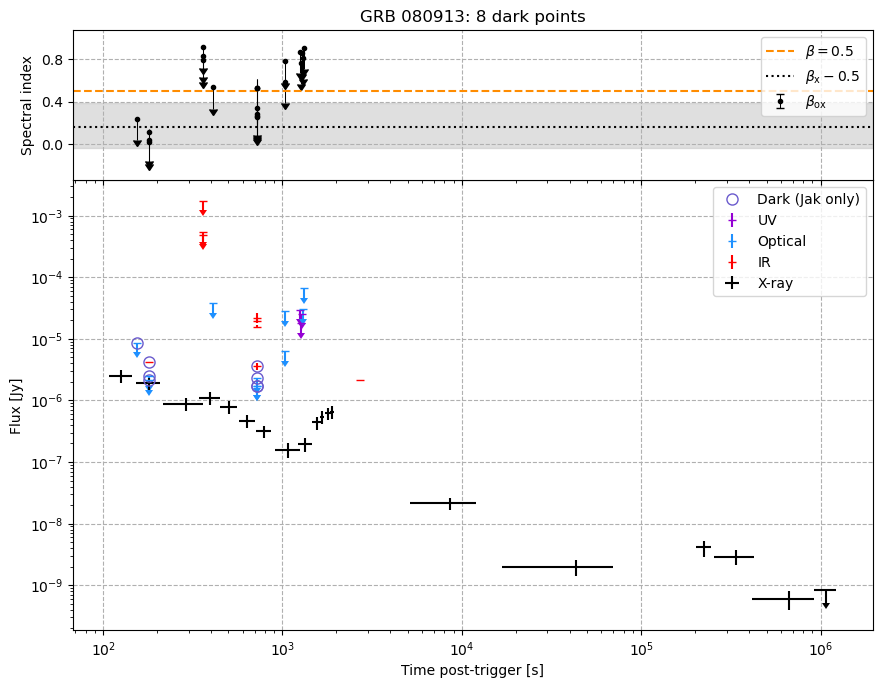

GRB     t_o       dt%  \
3397  080913   155.0  0.142334   
3398  080913   180.0  0.004001   
3399  080913   180.0  0.004001   
3400  080913   180.0  0.004001   
3401  080913   360.0  0.090916   
3402  080913   360.0  0.090916   
3403  080913   360.0  0.090916   
3404  080913   411.0  0.037871   
3407  080913   720.0  0.087132   
3409  080913   720.0  0.087132   
3411  080913   720.0  0.087132   
3413  080913   720.0  0.087132   
3415  080913   720.0  0.087132   
3417  080913   720.0  0.087132   
3419  080913   720.0  0.087132   
3420  080913  1034.5  0.042055   
3421  080913  1034.5  0.042055   
3423  080913  1249.0  0.068168   
3426  080913  1274.0  0.049517   
3429  080913  1277.0  0.047279   
3431  080913  1299.0  0.030865   
3433  080913  1324.0  0.012214   

                                             B_ox_w_err                 B_x  \
3397    0.2399314397193824 (+0.08439495698970664, -inf)  0.66 (+0.23, -0.2)   
3398  0.01605618847209473 (+0.034030454093975926, -inf)  0.66 (+0.23, -0.2)   
3399   0.03748108498254906 (+0.03320026502328484, -inf)  0.66 (+0.23, -0.2)   
3400  0.11163150427182805 (+0.03467104322158288, -0....  0.66 (+0.23, -0.2)   
3401    0.8340860037015736 (+0.10785842933373392, -inf)  0.66 (+0.23, -0.2)   
3402    0.7896194722319819 (+0.10051970738181493, -inf)  0.66 (+0.23, -0.2)   
3403    0.9205862265650239 (+0.10909538872767571, -inf)  0.66 (+0.23, -0.2)   
3404      0.53490837967778 (+0.07793681219762023, -inf)  0.66 (+0.23, -0.2)   
3407   0.26489000672688745 (+0.06617518208200583, -inf)  0.66 (+0.23, -0.2)   
3409    0.2529994851385232 (+0.06378663228882395, -inf)  0.66 (+0.23, -0.2)   
3411     0.284634977772599 (+0.06459595553754052, -inf)  0.66 (+0.23, -0.2)   
3413  0.3402391403389642 (+0.0701010792938108, -0.23...  0.66 (+0.23, -0.2)   
3415  0.5262222241705741 (+0.07976032687869382, -0.3...  0.66 (+0.23, -0.2)   
3417  0.5340339423580948 (+0.0787020286608472, -0.33...  0.66 (+0.23, -0.2)   
3419  0.5304888899837922 (+0.07960682218046862, -0.3...  0.66 (+0.23, -0.2)   
3420    0.5839763950759678 (+0.09002343165309114, -inf)  0.66 (+0.23, -0.2)   
3421    0.7813906865248299 (+0.10748809163580542, -inf)  0.66 (+0.23, -0.2)   
3423    0.8733635330354589 (+0.13838766940616562, -inf)  0.66 (+0.23, -0.2)   
3426    0.7629561167954357 (+0.11842174355956153, -inf)  0.66 (+0.23, -0.2)   
3429    0.8594025754558471 (+0.13604177854436672, -inf)  0.66 (+0.23, -0.2)   
3431    0.8116196567764709 (+0.11771554479040972, -inf)  0.66 (+0.23, -0.2)   
3433    0.9089272082940604 (+0.12471175608300691, -inf)  0.66 (+0.23, -0.2)   

        α Jak_dark vdH_dark  
3397  1.2     True    False  
3398  1.2     True    False  
3399  1.2     True    False  
3400  1.2     True    False  
3401  1.2    False    False  
3402  1.2    False    False  
3403  1.2    False    False  
3404  1.2    False    False  
3407  1.2     True    False  
3409  1.2     True    False  
3411  1.2     True    False  
3413  1.2     True    False  
3415  1.2    False    False  
3417  1.2    False    False  
3419  1.2    False    False  
3420  1.2    False    False  
3421  1.2    False    False  
3423  1.2    False    False  
3426  1.2    False    False  
3429  1.2    False    False  
3431  1.2    False    False  
3433  1.2    False    False

0 0 2


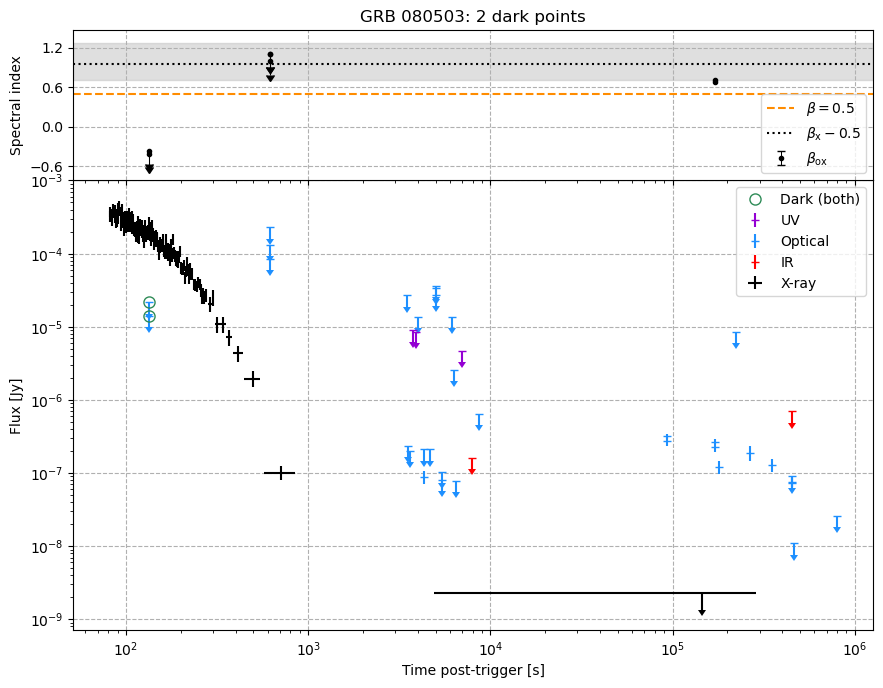

GRB       t_o       dt%  \
3462  080503     133.2  0.001207   
3518  080503     134.5  0.002226   
3547  080503     620.0  0.123748   
3548  080503     620.0  0.123748   
3549  080503     620.0  0.123748   
3550  080503  170640.0  0.176841   
3551  080503  170640.0  0.176841   

                                            B_ox_w_err                  B_x  \
3462  -0.41446458075626785 (+0.0604287156633898, -inf)  1.45 (+0.32, -0.24)   
3518  -0.3717373566638188 (+0.05574912379071332, -inf)  1.45 (+0.32, -0.24)   
3547   1.1050866413669602 (+0.43039424861514924, -inf)  1.45 (+0.32, -0.24)   
3548   0.9898254392685115 (+0.42398845549253483, -inf)  1.45 (+0.32, -0.24)   
3549     1.103017708565408 (+0.4268936581266706, -inf)  1.45 (+0.32, -0.24)   
3550    0.7063283846912259 (+inf, -0.7540846248150592)  1.45 (+0.32, -0.24)   
3551    0.6817994831780811 (+inf, -0.7425139963765917)  1.45 (+0.32, -0.24)   

         α Jak_dark vdH_dark  
3462  1.64     True     True  
3518  1.64     True     True  
3547  8.00    False    False  
3548  8.00    False    False  
3549  8.00    False    False  
3550  8.00    False    False  
3551  8.00    False    False

0 0 2


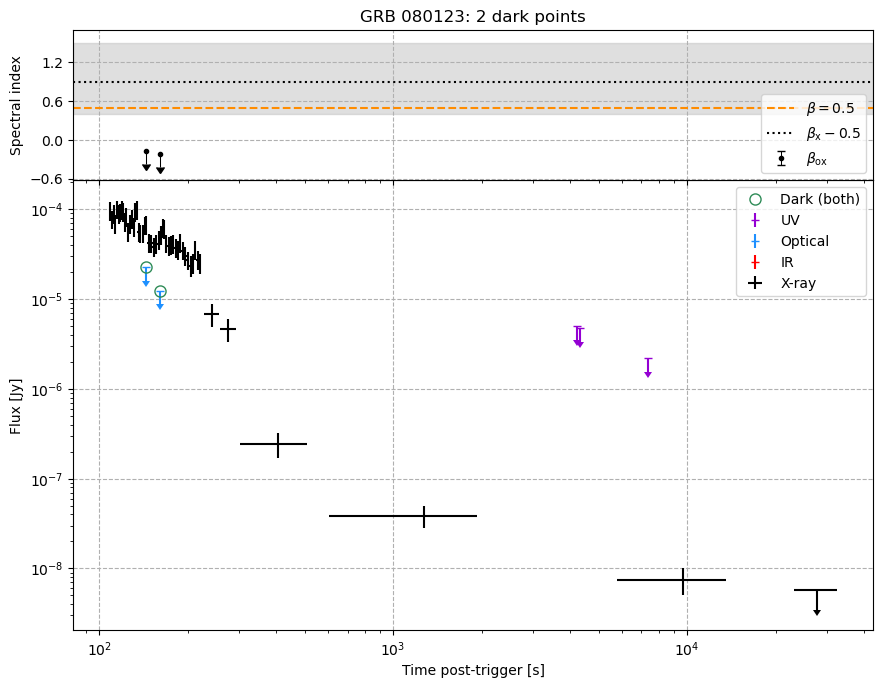

GRB    t_o       dt%  \
3565  080123  144.0  0.005923   
3588  080123  161.5  0.003585   

                                             B_ox_w_err               B_x  \
3565  -0.16940545058698822 (+0.04211980335327065, -inf)  1.4 (+0.6, -0.5)   
3588  -0.22627806369666828 (+0.04645418153007017, -inf)  1.4 (+0.6, -0.5)   

        α Jak_dark vdH_dark  
3565  2.2     True     True  
3588  2.2     True     True

1 0 0


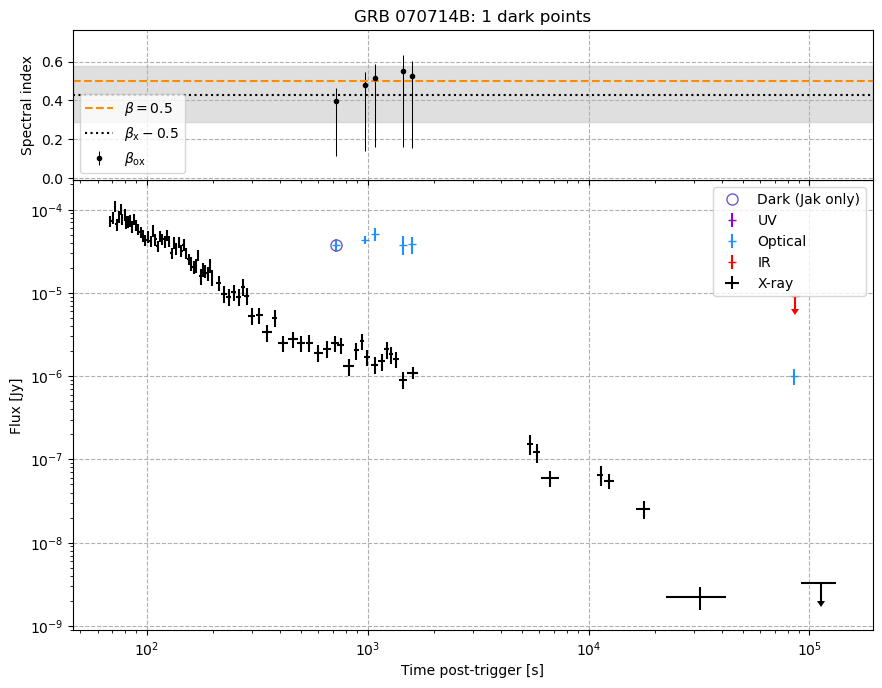

GRB     t_o       dt%  \
3625  070714B   720.0  0.012677   
3632  070714B   972.0  0.026857   
3637  070714B  1080.0  0.002530   
3644  070714B  1440.0  0.007071   
3648  070714B  1584.0  0.010861   

                                             B_ox_w_err                  B_x  \
3625  0.3991626238539481 (+0.06473473485990588, -0.2...  0.93 (+0.15, -0.14)   
3632  0.47821776821143014 (+0.06977052780202826, -0....  0.93 (+0.15, -0.14)   
3637  0.5160295816074629 (+0.07340671391827903, -0.3...  0.93 (+0.15, -0.14)   
3644  0.5527350413762803 (+0.08467823188812844, -0.3...  0.93 (+0.15, -0.14)   
3648  0.5246467021403641 (+0.07713257228976919, -0.3...  0.93 (+0.15, -0.14)   

         α Jak_dark vdH_dark  
3625  0.68     True    False  
3632  0.68    False    False  
3637  0.68    False    False  
3644  0.68    False    False  
3648  0.68    False    False

0 0 2


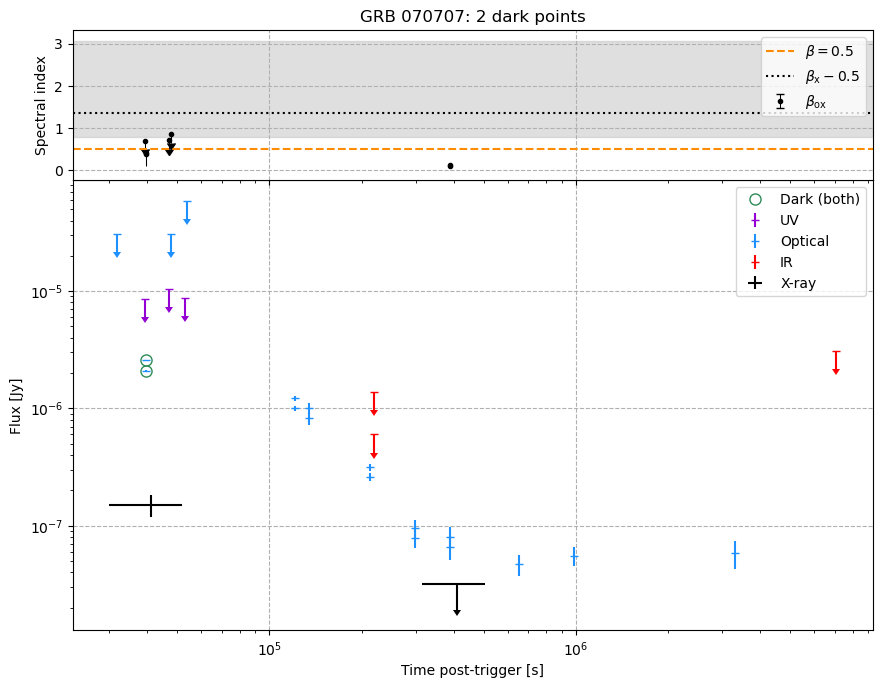

GRB         t_o       dt%  \
3649  070707   39328.000  0.040780   
3650  070707   39521.088  0.036071   
3651  070707   39600.000  0.034146   
3652  070707   47149.000  0.149976   
3653  070707   47905.000  0.168415   
3654  070707  388800.000  0.051707   
3655  070707  388907.136  0.051446   

                                             B_ox_w_err                  B_x  \
3649    0.7036409684769428 (+0.10918105703057798, -inf)  1.86 (+1.71, -0.57)   
3650  0.41689736741625993 (+0.0615635719850237, -0.2...  1.86 (+1.71, -0.57)   
3651  0.3870179453790122 (+0.05831681402895094, -0.2...  1.86 (+1.71, -0.57)   
3652    0.7162274538115445 (+0.12231699836875151, -inf)  1.86 (+1.71, -0.57)   
3653    0.8594059156485568 (+0.13746233272517053, -inf)  1.86 (+1.71, -0.57)   
3654   0.10616274934031909 (+inf, -0.08434067845047725)  1.86 (+1.71, -0.57)   
3655   0.13511853490535963 (+inf, -0.10167503741313387)  1.86 (+1.71, -0.57)   

        α Jak_dark vdH_dark  
3649  1.0    False    False  
3650  1.0     True     True  
3651  1.0     True     True  
3652  1.0    False    False  
3653  1.0    False    False  
3654  1.0    False    False  
3655  1.0    False    False

4 0 0


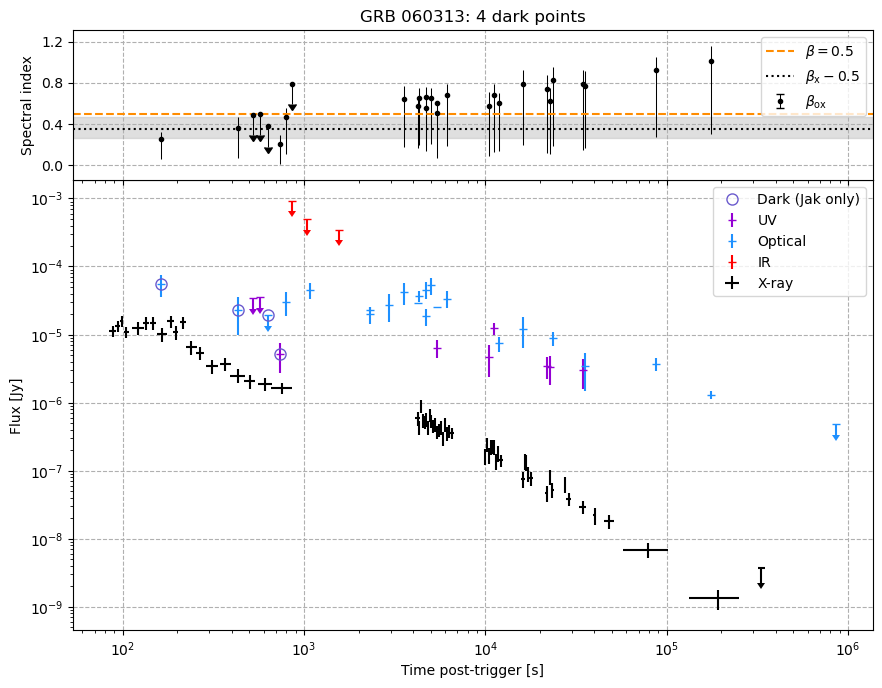

GRB       t_o       dt%  \
3680  060313     162.0  0.022188   
3684  060313     432.0  0.004432   
3686  060313     521.5  0.039860   
3689  060313     575.5  0.059823   
3690  060313     629.5  0.028395   
3692  060313     739.0  0.023547   
3693  060313     792.0  0.046483   
3694  060313     864.0  0.141617   
3695  060313    3570.0  0.156451   
3698  060313    4260.0  0.006588   
3710  060313    4320.0  0.002519   
3724  060313    4680.0  0.009227   
3739  060313    4680.0  0.009227   
3758  060313    5040.0  0.001225   
3775  060313    5400.0  0.002408   
3791  060313    5400.0  0.002408   
3806  060313    6120.0  0.005706   
3811  060313   10440.0  0.007365   
3823  060313   11160.0  0.002267   
3834  060313   11880.0  0.012105   
3836  060313   16200.0  0.003235   
3841  060313   21960.0  0.005735   
3845  060313   22680.0  0.000491   
3850  060313   23760.0  0.013823   
3854  060313   34560.0  0.004177   
3856  060313   35280.0  0.025098   
3858  060313   87120.0  0.098278   
3859  060313  174600.0  0.092153   

                                             B_ox_w_err  \
3680  0.25537158441562124 (+0.06979786317533948, -0....   
3684  0.3570767530886726 (+0.11049834993494675, -0.2...   
3686   0.48769492019673866 (+0.08230726076659017, -inf)   
3689    0.4931519663391611 (+0.08274795138981317, -inf)   
3690   0.37546685197672236 (+0.06330506308398082, -inf)   
3692  0.20120618337611967 (+0.09275371685417784, -0....   
3693  0.46341318236392615 (+0.09231653407481417, -0....   
3694    0.7924140850988121 (+0.10259382391279188, -inf)   
3695  0.6446507463465974 (+0.1206741797479412, -0.47...   
3698  0.5698665473911164 (+0.07679954767542656, -0.4...   
3710  0.6542278633692479 (+0.09044808446874764, -0.4...   
3724  0.6606015828774862 (+0.09634175060213641, -0.4...   
3739  0.5566236123299706 (+0.09112192469376035, -0.4...   
3758  0.6527827096004698 (+0.09224095420898909, -0.4...   
3775                    0.6041416629190014 (+nan, -nan)   
3791  0.5073076300428265 (+0.10038001451000375, -0.4...   
3806  0.6855677010146835 (+0.10132158983479143, -0.4...   
3811  0.5778200125615622 (+0.12752336981640147, -0.4...   
3823  0.6805572047926256 (+0.10928537929332284, -0.5...   
3834  0.5993256765074654 (+0.09899893548785473, -0.4...   
3836  0.7913537453321619 (+0.13255216643432124, -0.5...   
3841  0.743464669584619 (+0.13173942064149197, -0.62...   
3845  0.6263590963506426 (+0.1251026920070149, -0.51...   
3850  0.827272234050091 (+0.12340950888602387, -0.64...   
3854  0.7849654690490396 (+0.14023890099729938, -0.6...   
3856  0.7685654661777407 (+0.14143104196575867, -0.6...   
3858  0.9256875830068744 (+0.1292146557191775, -0.65...   
3859  1.0151510820356378 (+0.13914314180029091, -0.7...   

                        B_x    α Jak_dark vdH_dark  
3680  0.846 (+0.12, -0.087)  1.0     True    False  
3684  0.846 (+0.12, -0.087)  1.0     True    False  
3686  0.846 (+0.12, -0.087)  1.0    False    False  
3689  0.846 (+0.12, -0.087)  1.0    False    False  
3690  0.846 (+0.12, -0.087)  1.0     True    False  
3692  0.846 (+0.12, -0.087)  1.0     True    False  
3693  0.846 (+0.12, -0.087)  1.0    False    False  
3694  0.846 (+0.12, -0.087)  1.0    False    False  
3695  0.846 (+0.12, -0.087)  1.0    False    False  
3698  0.846 (+0.12, -0.087)  1.0    False    False  
3710  0.846 (+0.12, -0.087)  1.0    False    False  
3724  0.846 (+0.12, -0.087)  1.0    False    False  
3739  0.846 (+0.12, -0.087)  1.0    False    False  
3758  0.846 (+0.12, -0.087)  1.0    False    False  
3775  0.846 (+0.12, -0.087)  1.0    False    False  
3791  0.846 (+0.12, -0.087)  1.0    False    False  
3806  0.846 (+0.12, -0.087)  1.0    False    False  
3811  0.846 (+0.12, -0.087)  1.0    False    False  
3823  0.846 (+0.12, -0.087)  1.0    False    False  
3834  0.846 (+0.12, -0.087)  1.0    False    False  
3836  0.846 (+0.12, -0.087)  1.0    False    False  
3841  0.846 (+0.12, -0.087)  1.0    False    False  
3845  0.846 (+0.12, -0.087)  1.0 

1 0 6


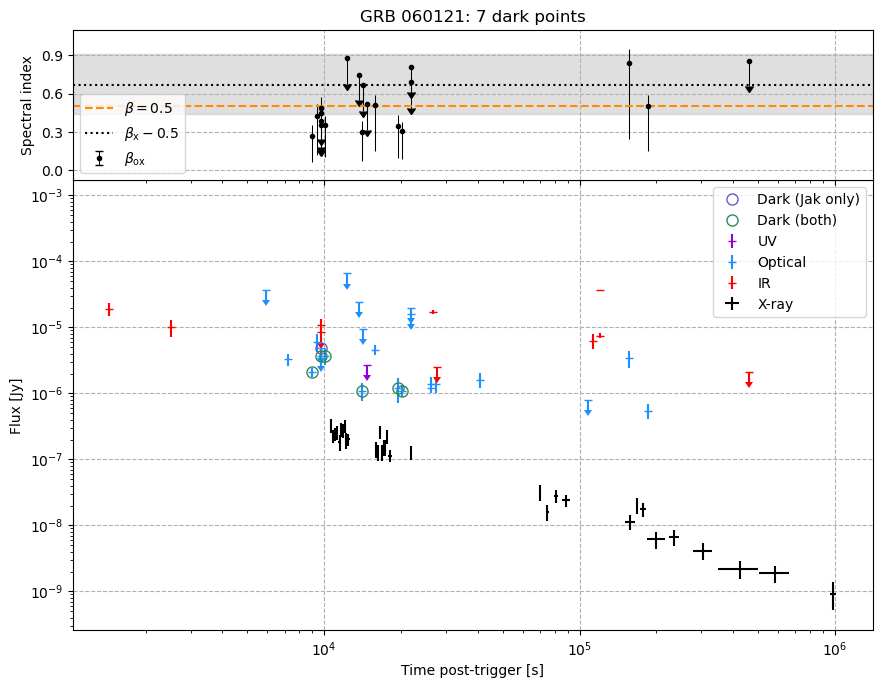

GRB       t_o       dt%  \
3860  060121    9000.0  0.157425   
3863  060121    9360.0  0.123723   
3869  060121    9720.0  0.090020   
3877  060121    9720.0  0.090020   
3885  060121    9720.0  0.090020   
3893  060121    9720.0  0.090020   
3901  060121   10080.0  0.056317   
3919  060121   12278.0  0.007990   
3926  060121   13680.5  0.099647   
3936  060121   14040.0  0.123561   
3945  060121   14240.0  0.111076   
3953  060121   14713.0  0.081550   
3961  060121   15840.0  0.011197   
3975  060121   19440.0  0.075842   
3982  060121   20160.0  0.075713   
3983  060121   21836.0  0.001128   
3984  060121   21960.0  0.006813   
3985  060121  156906.0  0.006968   
3990  060121  185400.0  0.045644   
3992  060121  460080.0  0.085020   

                                             B_ox_w_err                  B_x  \
3860  0.27149783096802343 (+0.08247250900487009, -0....  1.17 (+0.24, -0.23)   
3863  0.42808911485764395 (+0.09260667298003425, -0....  1.17 (+0.24, -0.23)   
3869   0.35803760216680375 (+0.06742669774850686, -inf)  1.17 (+0.24, -0.23)   
3877    0.3855022700594813 (+0.06812484175493841, -inf)  1.17 (+0.24, -0.23)   
3885    0.4453261255820076 (+0.07094370749352824, -inf)  1.17 (+0.24, -0.23)   
3893  0.48908632739746694 (+0.08235368722522932, -0....  1.17 (+0.24, -0.23)   
3901  0.3535077042933797 (+0.07124627609340599, -0.2...  1.17 (+0.24, -0.23)   
3919     0.8775203988518827 (+0.1168967139283292, -inf)  1.17 (+0.24, -0.23)   
3926    0.7496440828562636 (+0.11004637735640163, -inf)  1.17 (+0.24, -0.23)   
3936  0.2985555209527817 (+0.08611528914976126, -0.2...  1.17 (+0.24, -0.23)   
3945    0.6658659935964851 (+0.10775803998418679, -inf)  1.17 (+0.24, -0.23)   
3953    0.5158024669737835 (+0.09547740641367722, -inf)  1.17 (+0.24, -0.23)   
3961  0.5086105935735652 (+0.07835341437672705, -0.3...  1.17 (+0.24, -0.23)   
3975  0.34641101242275574 (+0.08515068021389786, -0....  1.17 (+0.24, -0.23)   
3982  0.3110520372331474 (+0.06748754502340887, -0.2...  1.17 (+0.24, -0.23)   
3983    0.8103670094780884 (+0.11533895223378804, -inf)  1.17 (+0.24, -0.23)   
3984    0.6879091107314499 (+0.08855806459837616, -inf)  1.17 (+0.24, -0.23)   
3985  0.838628101194818 (+0.11559405004116226, -0.59...  1.17 (+0.24, -0.23)   
3990  0.5062691302413981 (+0.08195604484876517, -0.3...  1.17 (+0.24, -0.23)   
3992    0.8578247024692394 (+0.10243200128260374, -inf)  1.17 (+0.24, -0.23)   

        α Jak_dark vdH_dark  
3860  1.0     True     True  
3863  1.0    False    False  
3869  1.0     True     True  
3877  1.0     True    False  
3885  1.0    False    False  
3893  1.0    False    False  
3901  1.0     True     True  
3919  1.0    False    False  
3926  1.0    False    False  
3936  1.0     True     True  
3945  1.0    False    False  
3953  1.0    False    False  
3961  1.0    False    False  
3975  1.0     True     True  
3982  1.0     True     True  
3983  1.0    False    False  
3984  1.0    False    False  
3985  1.0    False    False  
3990  1.0    False    False  
3992  1.0    False    False

In [4]:
for grb in close_times.loc[(close_times["Jak_dark"]|close_times["vdH_dark"]),"GRB"].unique():
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes((0,0,1,.75))
    
    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times.loc[(close_times["GRB"]==grb) & (close_times["vdH_dark"]|close_times["Jak_dark"])]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)
    
    subset = xrt_data.loc[xrt_data["GRB"]==grb].copy()
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    print(len(jak),len(vdh),len(both))
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
#     ax.axvline(11*60*60,linestyle="--",color="k",label="11 hr")
    ax.set(xscale="log",yscale="log",xlabel="Time post-trigger [s]",ylabel="Flux [Jy]")
    tmin,tmax = ax.get_xlim()
    ax.legend()
    ax.grid(linestyle="--")

    ax2 = fig.add_axes((0,.75,1,.25))
    matches = results[results["GRB"]==grb].copy()
    for t,sub in matches.groupby("t_o"):
        matches.drop(sub[sub["dt%"]!=sub["dt%"].min()].index,axis=0,inplace=True)
        
    ax2.errorbar(matches["t_o"],UncertaintyArray(matches[B_ox_name]).values,
                 yerr=[[e if np.isfinite(e) else 0.2 for e in UncertaintyArray(matches[B_ox_name]).minus],
                       UncertaintyArray(matches[B_ox_name]).plus],uplims=np.isinf(UncertaintyArray(matches[B_ox_name]).minus),
                 linestyle="",marker=".",color="k",elinewidth=0.75,label=r"$\beta_\mathrm{ox}$")
    ax2.axhline(0.5,color="darkorange",linestyle="--", label=r"$\beta=0.5$")

    B_x = a_u(*sGRBs.loc[sGRBs["GRB"]==grb,["Beta_X","Beta_X_pos","Beta_X_neg"]].values[0])
    ax2.axhline(B_x.value-0.5,color="k",linestyle=":",label=r"$\beta_\mathrm{x}-0.5$")
    ax2.fill_between([tmin,tmax],B_x.minimum-0.5,B_x.maximum-0.5,alpha=0.5,color="silver")
    ax2.legend()
    default_lolim,default_uplim = ax2.get_ylim()

    ax2.set(xscale="log",xlim=(tmin,tmax),ylim=(default_lolim-.1,default_uplim+.1),#xlabel="Time [s]",
            ylabel="Spectral index",xticklabels=[],title=f"GRB {grb}: {len(dark_points)} dark points")
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax2.grid(linestyle="--")
    
    fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()
    display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])

In [ ]:
def interp_xray_flux(grb,time):
    lightcurve = xrt_data[xrt_data["GRB"]==grb]
    time_series = [lightcurve.loc[i,"Time"] for i in lightcurve.index if np.isfinite(lightcurve.loc[i,"SpecFlux"].minus)]
    flux_series = [Fx.value for Fx in lightcurve["SpecFlux"] if np.isfinite(Fx.minus)]
    interp_func = interpolate.interp1d(time_series,flux_series)
    return interp_func(time)

# def interp_opt_flux(grb,time):

def interp_B_ox(optical_index):
    grb = all_optical.loc[optical_index,"GRB"]
    t_o = all_optical.loc[optical_index,"Time (s)"]
    F_o = all_optical.loc[optical_index,"Flux (Jy)"]
    print("B_x",results.loc[results["GRB"]==grb,"B_x"])
    print(grb,t_o,F_o)
    F_x = interp_xray_flux(grb,t_o)
    nu_o = 299792458/float(all_optical.loc[optical_index,"λ_eff"]/1e10)
    return -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)

def bpl(xvals,alphas,breaks):
    assert len(alphas)==len(breaks)+1, "There must be one more index than there are breaks"
    assert min(xvals)<min(breaks) and max(xvals)>max(breaks), "Breaks must be within domain"
    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)] # create a list of all the bounding x-values
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]
    
    all_y = []
    
    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals) # add this piece to the output
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0]) # scale the beginning of each piece to the end of the last so it is continuous
    
    return np.array([y for ychunk in all_y for y in ychunk]) # return flattened list

In [ ]:
for grb in all_optical[(all_optical["Magnitude"]>=23) & (all_optical["Time (s)"]>=1000) & (all_optical["GRB"].isin(xrt_data["GRB"]))]["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]
    of_interest = subset[(subset["Magnitude"]>=23) & (subset["Time (s)"]>=1000) & ~(subset["Time (s)"].isin(results.loc[results["GRB"]==grb,"t_o"]))]
    display(of_interest)
    display(results[(results["GRB"]==grb) & results["t_o"].isin(of_interest["Time (s)"])])

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
                marker="o",markersize=8,mfc="none",mec="slateblue",
                linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
                marker="o",markersize=8,mfc="none",mec="goldenrod",
                linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
                marker="o",markersize=8,mfc="none",mec="seagreen",
                linestyle="",label="Dark (both)")
        
    ax.plot(of_interest["Time (s)"],[flux.value for flux in of_interest["Flux (Jy)"]],"s",mec="green",mfc="none",ms=12)
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    plt.show()

## Population statistics

### Spectral index distributions

In [5]:
notvalid = lambda x : any((np.isinf(x), pd.isna(x)))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
oxlolims = [notvalid(v.plus) for v in darkest_times[B_ox_name]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.2 if notvalid(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.2 if notvalid(v.minus) else v.minus for v in darkest_times["B_x"]]
t_obs = darkest_times["t_o"].values

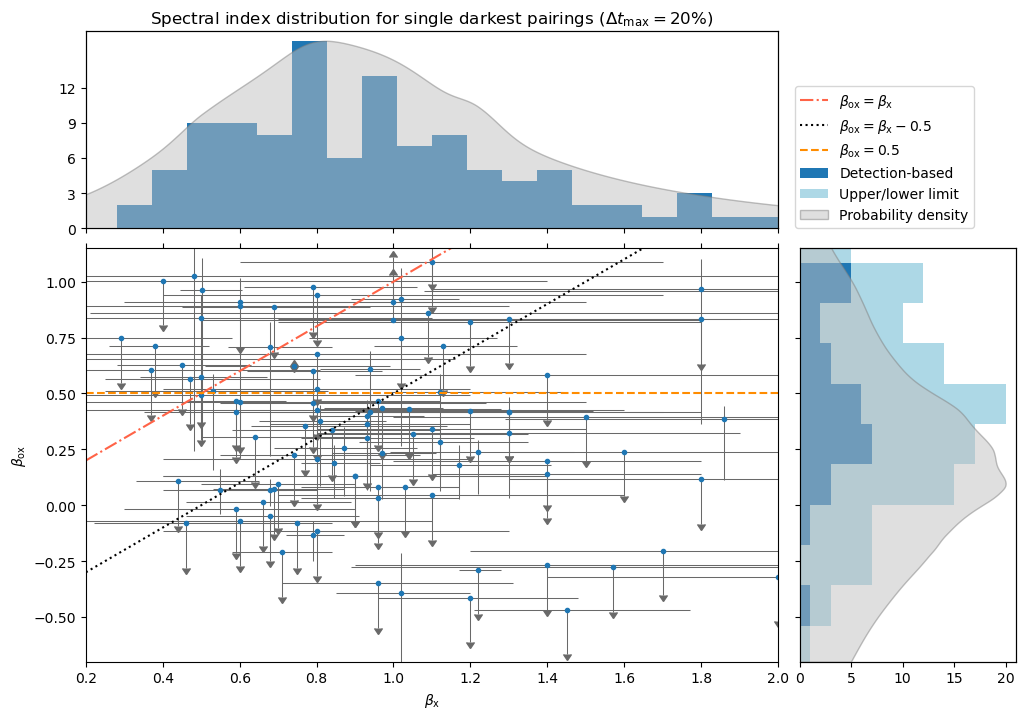

In [6]:
fig = plt.figure(figsize=(12,11))
grid = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], yticklabels=[])#, xticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[])#, yticklabels=[])

x = np.linspace(0.2,2,500)
y = np.linspace(-.7,1.15,500)
X,Y = np.meshgrid(x,y)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],
                 uplims=oxuplims,lolims=oxlolims,zorder=0,
                 linestyle="",marker=".",
                 ecolor="dimgrey",elinewidth=0.75,capthick=1)
# scatter = ax_main.scatter(b_x,b_ox,c=np.log10(t_obs),cmap="PuBu",vmin=-1,marker=".",zorder=1)
ax_main.plot(x,x,linestyle="-.",color="tomato",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.xaxis.set_ticks_position("both")

ax_kde_x = ax_top.twinx()
valid_bx = UncertaintyArray([entry for entry in darkest_times["B_x"] if pd.notna(entry.value)])
ax_kde_x.fill_between(x,valid_bx.pdf(x),facecolor="silver",edgecolor="grey",alpha=.5)
ax_kde_x.set_ylim(0,)
ax_kde_x.set(yticks=[])
ax_top.hist(b_x,22,orientation='vertical', color="C0")
ax_top.set(xlim=ax_main.get_xlim(),yticks=range(0,14,3))

ax_kde_y = ax_right.twiny()
valid_box = UncertaintyArray()
for i,row in darkest_times.iterrows():
    if np.isfinite(row[B_ox_name].minus):
        neg = row[B_ox_name].minus
    else:
        neg = 0.5
    if np.isfinite(row[B_ox_name].plus):
        pos = row[B_ox_name].plus
    else:
        pos = 0.5
    if np.isfinite(row[B_ox_name].value):
        valid_box.append(a_u(row[B_ox_name].value,pos,neg))
ax_kde_y.fill_betweenx(y,valid_box.pdf(y),alpha=.5,
                       facecolor="silver",edgecolor="grey",label="Probability density")
ax_kde_y.set_xlim(0,)
ax_kde_y.set(xticks=[])
ax_right.hist([[b.value for b in darkest_times[B_ox_name] if all(np.isfinite(b.items()))],
               [b.value for b in darkest_times[B_ox_name] if not all(np.isfinite(b.items()))]],
              19, orientation='horizontal', stacked=True, color=["C0","lightblue"],
              label=["Detection-based","Upper/lower limit"])
ax_right.set(ylim=(ax_main.get_ylim()))
ax_right.set_xlim(0,)

# Z_x = np.sum([bx.pdf(X) for bx in valid_bx],axis=0)
# Z_x /= np.sum(Z_x)
# Z_ox = np.sum([box.pdf(Y) for box in valid_box],axis=0)
# Z_ox /= np.sum(Z_ox)
# ax_main.contourf(X,Y,np.sqrt(Z_x**2+Z_ox**2),30,cmap="Greys",vmax=4e-5,vmin=0)

fig.legend(loc="lower left",bbox_to_anchor=(0.71,0.695))
# fig.colorbar(scatter,ax=ax_right,label=r"$\log_{10}(t_\mathrm{o}\ \mathrm{[s]})$")

ax_top.set_title(r"Spectral index distribution for single darkest pairings ($\Delta t_\mathrm{max}="+"{:.0%}$%)".format(max_dt))

plt.savefig("./products/beta_distributions.png",dpi=300,bbox_inches="tight")

plt.show()

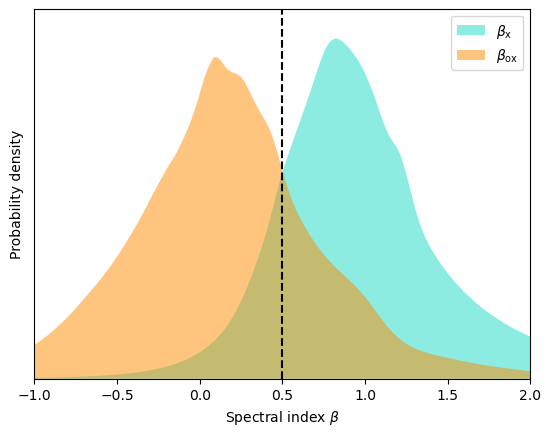

In [7]:
x = np.linspace(-1,2,500)
# for box in valid_bx:
#     plt.plot(x,box.pdf(x),"k-",linewidth=0.4)
#     if any(box.pdf(x)>6):
#         print(box)
# plt.yticks([])
# plt.ylim(0,15)
# plt.twinx()

plt.fill_between(x,valid_bx.pdf(x),fc="turquoise",alpha=.6,label=r"$\beta_\mathrm{x}$")
plt.fill_between(x,valid_box.pdf(x),fc="darkorange",alpha=.5,label=r"$\beta_\mathrm{ox}$")
plt.axvline(0.5,linestyle="--",color="k")
plt.legend()
plt.ylim(0,111)
plt.xlabel(r"Spectral index $\beta$")
plt.xlim(x.min(),x.max())
plt.yticks([])
plt.ylabel("Probability density")

plt.savefig("./products/beta_comparison.png",dpi=300,bbox_inches="tight")
plt.show()

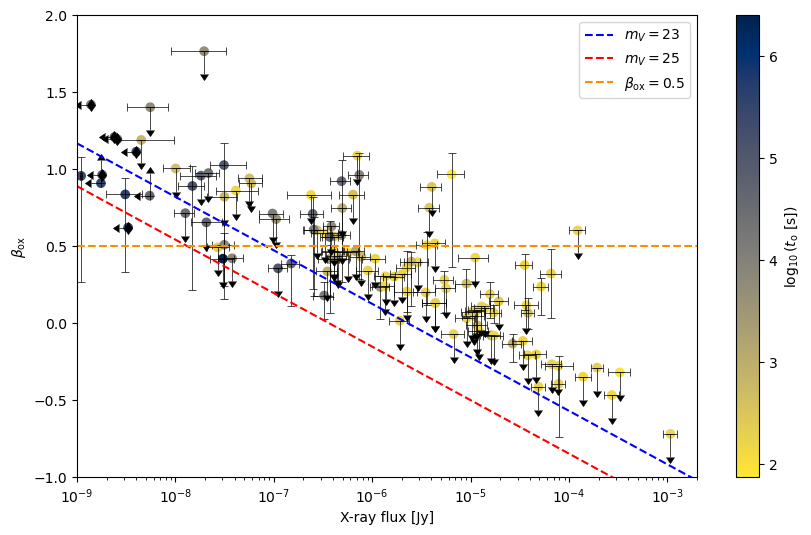

In [8]:
fig = plt.figure(figsize=(10,6))
b_ox = [b.value for b in darkest_times[B_ox_name]]
oxplus = [0.15 if notvalid(v.plus) else v.plus for v in darkest_times[B_ox_name]]
oxminus = [0.15 if notvalid(v.minus) else v.minus for v in darkest_times[B_ox_name]]
oxuplims = [notvalid(v.minus) for v in darkest_times[B_ox_name]]
Fx = [f.value for f in darkest_times["F_x"]]
Fxplus = [v.value*0.2 if notvalid(v.plus) else v.plus for v in darkest_times["F_x"]]
Fxminus = [v.value*0.2 if notvalid(v.minus) else v.minus for v in darkest_times["F_x"]]
Fxuplims = [notvalid(v.minus) for v in darkest_times["F_x"]]
plt.scatter(Fx,b_ox,c=np.log10(darkest_times["t_o"]),cmap="cividis_r")
plt.errorbar(Fx,b_ox,xerr=[Fxminus,Fxplus],yerr=[oxminus,oxplus],uplims=oxuplims,lolims=oxlolims,
             xuplims=Fxuplims,elinewidth=0.5,capsize=3,capthick=0.5,color="k",linestyle="",marker="")
plt.colorbar(label=r"$\log_{10}(t_\mathrm{o}\ \mathrm{[s]})$")
fx = np.linspace(1e-9,2e-3,10)
box_m23 = -np.log10(fx/(3631*10**(-23/2.5)))/np.log10(4.18794e17/5.539986e14)
box_m25 = -np.log10(fx/(3631*10**(-25/2.5)))/np.log10(4.18794e17/5.539986e14)
plt.plot(fx,box_m23,"b--",label="$m_V=23$")
plt.plot(fx,box_m25,"r--",label="$m_V=25$")
plt.axhline(0.5,linestyle="--",color="darkorange",label=r"$\beta_\mathrm{ox}=0.5$")
plt.xlim(fx.min(),fx.max())
plt.ylim(-1,2)
plt.legend()
plt.xscale("log")
plt.ylabel(r"$\beta_\mathrm{ox}$")
plt.xlabel("X-ray flux [Jy]")
plt.savefig("./products/Fx-Box.png",dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
dark11hrFx = UncertaintyArray()
notdark11hrFx = UncertaintyArray()
for grb in results["GRB"].unique():
    print(grb,end=" ")
    try:
        Fx11hr = interp_xray_flux(grb,11*60*60)
        print('success')
    except ValueError:
        try:
            lc = xrt_data[(xrt_data["GRB"]==grb) & np.isfinite(xrt_data["Fluxneg"])].copy().reset_index()
            last_time = a_u(*np.abs(lc.loc[np.argmin(np.abs(lc["Time"]-11*60*60)),["Time","Tpos","Tneg"]]))
            last_flux = a_u(*lc.loc[np.argmin(np.abs(lc["Time"]-11*60*60)),["Flux","Fluxpos","Fluxneg"]])
            alpha = get_temporalIndex(grb,last_time)
            dt = 11*60*60 - last_time
            A = last_flux/(last_time**-alpha)
            Fx11hr = A*(11*60*60)**-alpha
            print(last_flux,"->",Fx11hr)
        except:
            print("failed")
            continue
    if grb in dark["GRB"].tolist():
        dark11hrFx.append(Fx11hr)
    else:
        notdark11hrFx.append(Fx11hr)

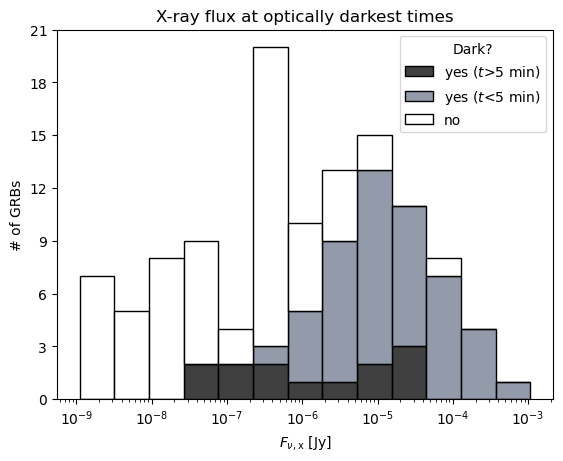

In [9]:
darkest_times["Fx"] = UncertaintyArray(darkest_times["F_x"]).values
darkest_times["dark"] = (darkest_times["vdH_dark"]|darkest_times["Jak_dark"])
for i,entry in darkest_times.iterrows():
    if entry["dark"]:
        if entry["t_o"]>300:
            darkest_times.loc[i,"dark"] = 2
        else:
            darkest_times.loc[i,"dark"] = 1
    else:
        darkest_times.loc[i,"dark"] = 0
sns.histplot(data=darkest_times,x="Fx",hue="dark",palette="bone_r",
             bins=13,log_scale=True,multiple="stack",edgecolor="k")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3))
plt.xlabel(r"$F_{\nu,\mathrm{x}}$ [Jy]")
plt.ylabel("# of GRBs")
plt.title("X-ray flux at optically darkest times")
plt.legend(labels=["yes ($t$>5 min)","yes ($t$<5 min)","no"],title="Dark?")
plt.savefig("./products/Fx_hist.png",dpi=300,bbox_inches="tight")
plt.show()

### Extinction/absorption analysis

In [10]:
from src.xrt import grb_list
sGRBs["N_H (intrinsic)"] = np.nan
sGRBs["N_H (intrinsic)"] = [a_u(nh) if pd.notna(nh) else np.nan for nh in sGRBs["N_H (intrinsic)"]]
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb,end=": ")
    if pd.notna(sGRBs.loc[i,"N_H (intrinsic)"]):
        print("already present")
        continue
    try:
        sGRBs.loc[i,"N_H (intrinsic)"],mode = get_columnDensity(grb,sGRBs)
        print(f"retrieved ({mode} mode)")
    except AssertionError:
        print("info doesn't exist")
    except ValueError:
        print("couldn't be parsed")
    except TypeError:
        print("trigger not found")

211227A: retrieved (PC mode)
211221A: retrieved (PC mode)
211207A: retrieved (PC mode)
211106A: retrieved (PC mode)
211023B: retrieved (PC mode)
210919A: retrieved (PC mode)
210726A: retrieved (PC mode)
210725B: retrieved (PC mode)
210708A: retrieved (PC mode)
210704A: retrieved (PC mode)
210618A: retrieved (PC mode)
210413B: info doesn't exist
210410A: retrieved (PC mode)
210323A: retrieved (PC mode)
210217A: retrieved (PC mode)
210119A: info doesn't exist
201221D: retrieved (PC mode)
201015A: retrieved (PC mode)
201006A: retrieved (PC mode)
200917A: retrieved (PC mode)
200907B: retrieved (PC mode)
200826A: retrieved (PC mode)
200729A: retrieved (PC mode)
200716C: retrieved (PC mode)
200623A: info doesn't exist
200522A: retrieved (PC mode)
200517A: retrieved (PC mode)
200512A: retrieved (PC mode)
200411A: retrieved (PC mode)
200409A: retrieved (PC mode)
200219A: retrieved (PC mode)
191031D: retrieved (PC mode)
190719C: retrieved (PC mode)
190627A: retrieved (PC mode)
190610A: info doe

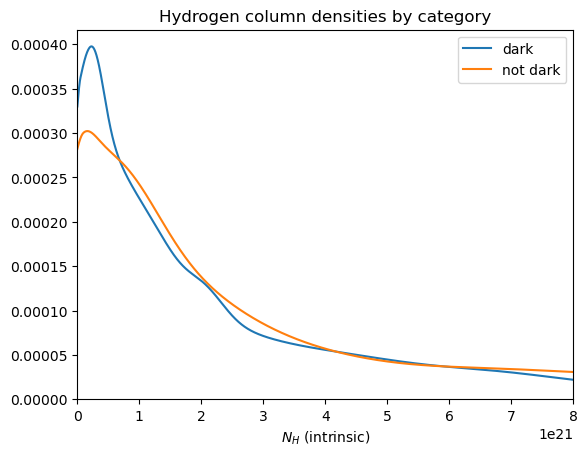

In [11]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# dark_nh = [v for v in dark_nh if v.value>0]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# notdark_nh = [v for v in notdark_nh if v.value>0]
max_x = 8e21
x = np.linspace(0,max_x,10000)
p_NH_dark = np.sum([nh.pdf(x) for nh in dark_nh],axis=0)
plt.plot(x,p_NH_dark/np.sum(p_NH_dark),label="dark")
p_NH_notdark = np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)
plt.plot(x,p_NH_notdark/np.sum(p_NH_notdark),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
# plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)
plt.show()

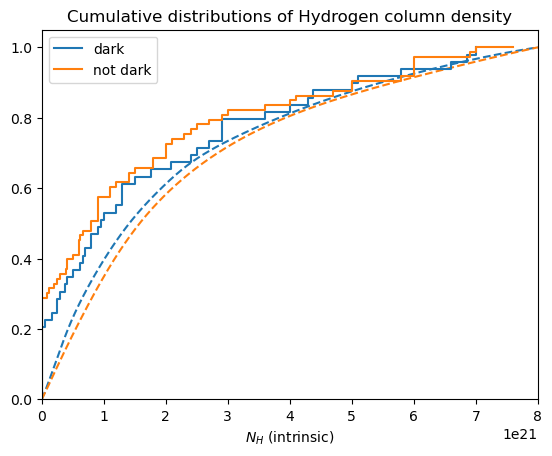

In [12]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark),color="tab:blue",linestyle="--")
plt.plot(x,np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark),color="tab:orange",linestyle="--")
x1 = np.sort([v.value for v  in dark_nh if v.value<max_x])
plt.step(x1, np.linspace(0, 1, len(x1)), where="pre", label="dark")
x2 = np.sort([v.value for v  in notdark_nh if v.value<max_x])
plt.step(x2, np.linspace(0, 1, len(x2)), where="pre", label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Cumulative distributions of Hydrogen column density")
plt.show()

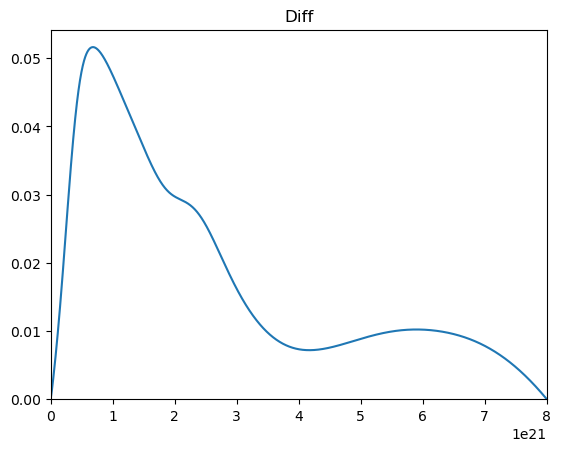

In [13]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark)-np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark))
plt.title("Diff")
plt.xlim(0,max_x)
plt.ylim(0,)
plt.show()

In [14]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"],
               sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"])

KstestResult(statistic=0.09937888198757763, pvalue=0.8401364721213)

In [ ]:
comparison_table = pd.DataFrame(columns=["GRB","nu_o","F_o","nu_x","F_x","B_x","B_ox","N_H","Dark"])

for i,row in darkest_times.iterrows():
    grb = row["GRB"]
    b_ox = row[B_ox_name]
    b_x = row["B_x"]
    t_o = row["t_o"]
    flag = row["vdH_dark"] or row["Jak_dark"]
    try:
        n_h = sGRBs.loc[sGRBs["GRB"]==grb,"N_H (intrinsic)"].values[0]
    except IndexError:
        continue
#     n_h = (a_u(n_h)+1)/1e21 - 1e-21
    if np.isfinite(b_ox.minus):
        neg = b_ox.minus
    else:
        neg = 1
    if np.isfinite(b_ox.plus):
        pos = b_ox.plus
    else:
        pos = 1
    if np.isfinite(b_ox.value) and np.isfinite(b_x.value):
        comparison_table = pd.concat([comparison_table, pd.DataFrame([{"GRB":grb,"t_o":t_o,"nu_o":row["nu_o"],"F_o":row["F_o"],
                                                                       "nu_x":row["nu_x"],"F_x":row["F_x"],"B_x":b_x,
                                                                       "B_ox":a_u(b_ox.value,pos,neg),
                                                                       "N_H":n_h,"Dark":flag}])], ignore_index=True)

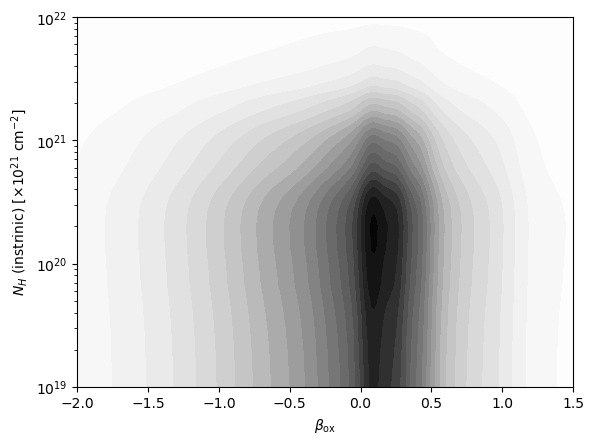

In [17]:
x,y = np.linspace(-2,1.5,250),np.linspace(0,10e21,150)
X,Y = np.meshgrid(x,y)
Z1 = np.sum([box.pdf(X) for box in comparison_table["B_ox"]],axis=0)
Z2 = np.sum([NH.pdf(Y) for NH in comparison_table["N_H"]],axis=0)
plt.contourf(X,Y,Z1*Z2,25,cmap="Greys")
plt.yscale("log")
plt.ylim(0.01e21,10e21)
plt.xlabel(r"$\beta_\mathrm{ox}$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
# plt.colorbar(label="Probability density")
plt.savefig("./products/B_ox-N_H.png",dpi=300,bbox_inches="tight",facecolor="white")

error term: $\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))$

error term: $\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}$

$$ \sigma_{m_\text{AB}} =  \sqrt{\left(\sigma_{\beta_x} \cdot \frac{-2.5}{\ln(10)}(\ln(\nu_o) - \ln(\nu_x))\right)^2 + \left(\sigma_{F_x} \cdot -\frac{2.5}{\ln(10)F_x}\right)^2} $$

In [18]:
E_x = log_mean(0.3,10)
nu_x = E_x*241797944177033445
# nu_x = a_u(nu_x,10-nu_x,nu_x-0.3)
ABmag = lambda flux : -2.5*np.log10(flux/3631) # flux in Jy -> AB magnitude

for i,row in comparison_table.iterrows():
    A_Bx = row["F_x"]/(nu_x**-row["B_x"])
    A_Bx05 = row["F_x"]/(nu_x**-(row["B_x"]-0.5))
    optflux_BoxBx = A_Bx*nu_o**-row["B_x"]
    optflux_BoxBx05 = A_Bx05*nu_o**-(row["B_x"]-0.5)
    
    obs_mag = ABmag(row["F_o"])
    
    m_plus = np.sqrt((row["B_x"].minus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                     (row["F_x"].plus*-2.5/np.log(10)/row["F_x"].value)**2)
    m_minus = np.sqrt((row["B_x"].plus*-2.5/np.log(10) * (np.log(row["nu_o"])-np.log(row["nu_x"].value)))**2 + \
                      (row["F_x"].minus*-2.5/np.log(10)/row["F_x"].value)**2)
    
    unext_mag = a_u(ABmag(optflux_BoxBx),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x)"] = Av
    
    unext_mag = a_u(ABmag(optflux_BoxBx05),m_plus,m_minus)
    Av = obs_mag - unext_mag
    if np.isinf(Av.minus):
        Av.minus = 10
    comparison_table.loc[i,"Av (B_ox=B_x-0.5)"] = Av
    
    print(obs_mag,unext_mag,obs_mag-unext_mag,sep=" | ")

19.95395419855796 (+0.0, -inf) | 6.062096841311777 (+4.409696364338757, -5.1400268078517035) | 13.891857357246181 (+5.1400268078517035, -inf)
21.330252307550786 (+0.0, -inf) | 20.533718422620147 (+2.0001625391873272, -2.1354039560365004) | 0.7965338849306391 (+2.1354039560365004, -inf)
20.001333246396705 (+0.0, -inf) | 20.659466403356493 (+1.5203445500312893, -1.5816710436171058) | -0.6581331569597886 (+1.5816710436171058, -inf)
23.64141753622078 (+0.0, -inf) | 31.19345162964709 (+2.9110496146347193, -7.2540756207436505) | -7.552034093426311 (+7.2540756207436505, -inf)
20.144378009658872 ± 0.10999999999999997 | 17.293620205189047 (+1.4575396446155708, -1.5920348787963094) | 2.8507578044698256 (+1.5958305221119127, -1.461684581442277)
21.638220806745878 (+0.0, -inf) | 25.150086193163045 (+7.620177764359282, -22.56625074765676) | -3.511865386417167 (+22.56625074765676, -inf)
24.356148314792897 (+0.0, -inf) | 22.071352853233243 (+2.2315865077033634, -2.377364690086526) | 2.284795461559653

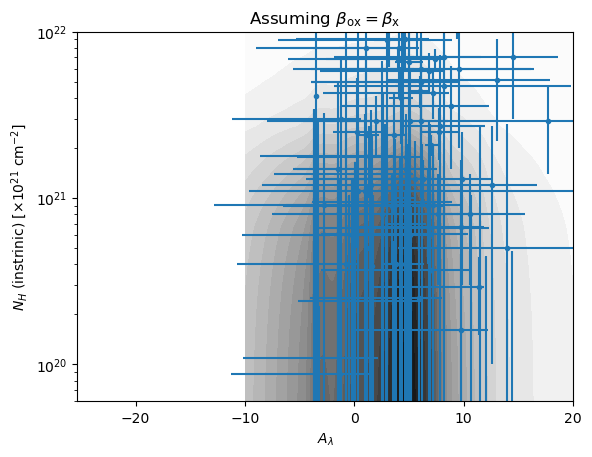

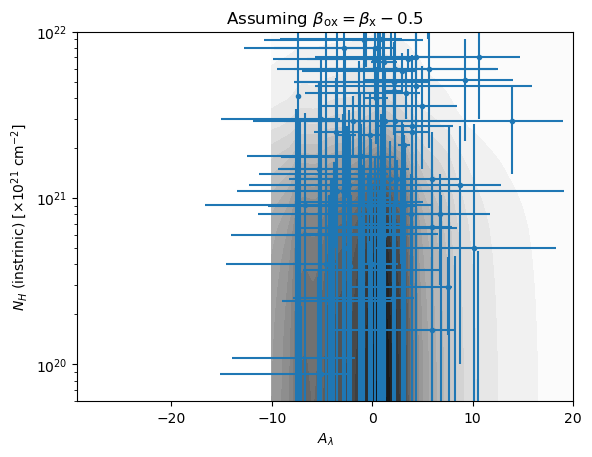

In [19]:
x,y = np.linspace(-10,20,250),np.linspace(0,10e22,150)
X,Y = np.meshgrid(x,y)
NH = UncertaintyArray(comparison_table["N_H"])
Av = UncertaintyArray(comparison_table["Av (B_ox=B_x)"])
Z1 = Av.pdf(X)
Z2 = NH.pdf(Y)
plt.contourf(X,Y,Z1*Z2,25,cmap="binary")
plt.errorbar(Av.values,NH.values,xerr=(Av.minus,Av.plus),yerr=[NH.minus,NH.plus],marker=".",linestyle="")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}$")
plt.show()

Av = UncertaintyArray(comparison_table["Av (B_ox=B_x-0.5)"])
Z1 = Av.pdf(X)
Z2 = NH.pdf(Y)
plt.contourf(X,Y,Z1*Z2,25,cmap="binary")
plt.errorbar(Av.values,NH.values,xerr=(Av.minus,Av.plus),yerr=[NH.minus,NH.plus],marker=".",linestyle="")
plt.yscale("log")
plt.ylim(0.06e21,10e21)
plt.xlabel(r"$A_\lambda$")
plt.ylabel(r"$N_H$ (instrinic) [$\times10^{21}$ cm$^{-2}$]")
plt.title(r"Assuming $\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
plt.show()

(-10.0, 20.0)

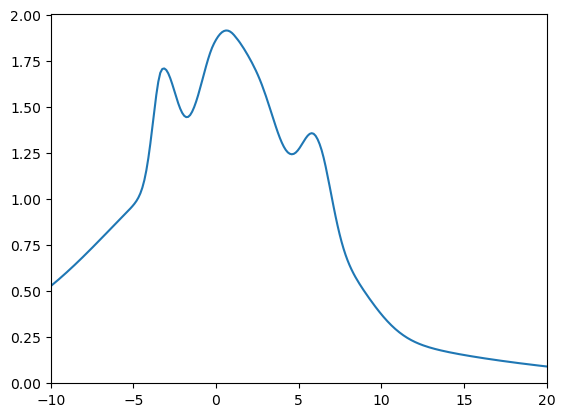

In [20]:
Z = np.sum([row["Av (B_ox=B_x)"].pdf(x) for i,row in comparison_table.iterrows() if (all(np.isfinite(row["Av (B_ox=B_x)"].items())) and row["t_o"]>1000)],axis=0)
plt.plot(x,Z)
plt.xlim(x.min(),x.max())

### Observation depth over time

150301A


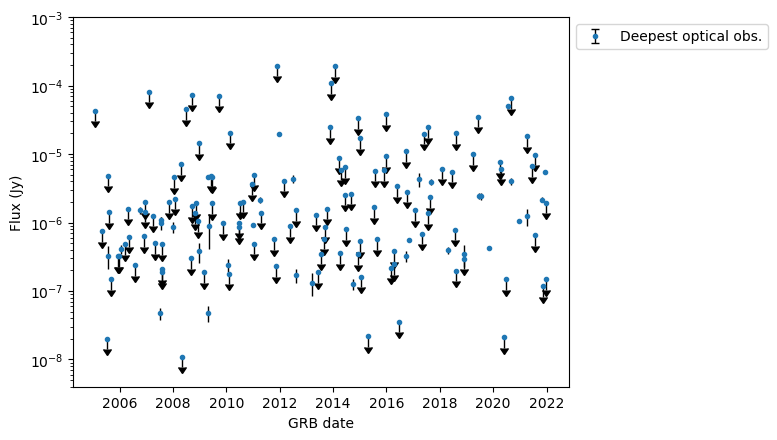

In [21]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if deepest_obs>1e-1:
        print(grb)
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest optical obs.",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylim(4e-9,1e-3)
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_flux_over_time.png",bbox_inches="tight",dpi=300)

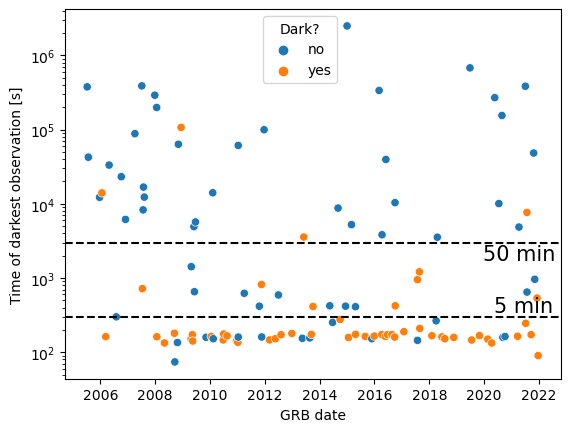

In [22]:
fig,ax = plt.subplots()
datestamps = []
darkest_t = []
cs = []

for grb,data in results.groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
#     data = data[data["t_o"]>500]
    try:
        datestamps.append(mm+"/"+dd+"/20"+yy)
        point = data.loc[data[B_ox_name]==data[B_ox_name].min(),:]
        darkest_t.append(float(point["t_o"]))
        if all(point["Jak_dark"]) or all(point["vdH_dark"]):
            cs.append("yes")
        else:
            cs.append("no")
    except:
        continue

datestamps = pd.to_datetime(datestamps)
sns.scatterplot(x="Date",y="Time",hue="Dark?",palette="tab10",
                data=pd.DataFrame(zip(datestamps,darkest_t,cs),
                                  columns=["Date","Time","Dark?"]))
plt.axhline(300,linestyle="--",color="k")
plt.text(18400,350,"5 min",size=15)
plt.axhline(3000,linestyle="--",color="k")
plt.text(18250,1750,"50 min",size=15)
plt.xlabel("GRB date")
plt.ylabel("Time of darkest observation [s]")
# plt.rcParams['legend.title_fontsize'] = 14
plt.legend(title="Dark?",loc="upper center",bbox_to_anchor=(.475,1))
plt.yscale("log")
# plt.ylim(4e2,4e6)
plt.savefig("./products/darkest_time_over_time.png",dpi=300,bbox_inches="tight")
plt.show()

### Time distributions of dark vs. not dark observation pairs

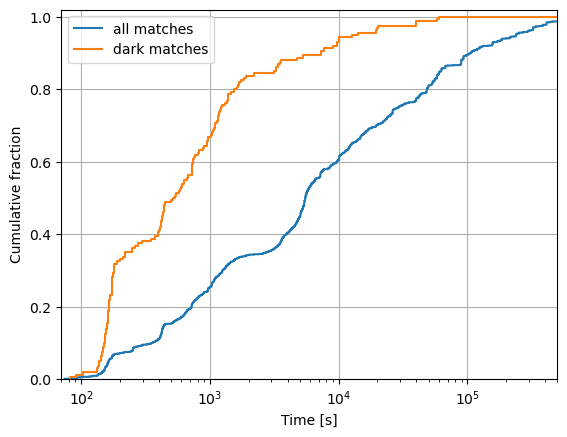

In [23]:
plt.step(close_times["t_o"].sort_values(ascending=True),np.linspace(0,1,len(close_times)),label="all matches")
plt.step(close_times.loc[close_times["vdH_dark"]|close_times["Jak_dark"],"t_o"].sort_values(ascending=True),np.linspace(0,1,sum(close_times["vdH_dark"]|close_times["Jak_dark"])),label="dark matches")
plt.legend()
plt.xscale("log")
plt.xlim(70,5e5)
plt.ylim(0,1.02)
plt.ylabel("Cumulative fraction")
plt.xlabel("Time [s]")
plt.grid()

KstestResult(statistic=0.5817694548259672, pvalue=4.105670696171176e-44)

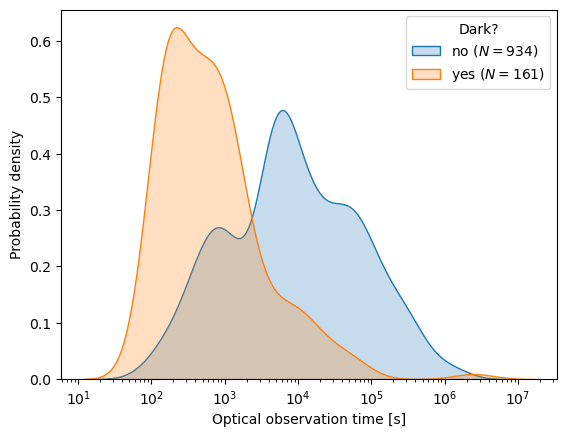

In [24]:
sns.kdeplot(data=close_times[~(close_times["vdH_dark"]|close_times["Jak_dark"])],x="t_o",
            fill=True,log_scale=True,bw_adjust=1.1,
            label="no ($N=%d$)"%sum(~(close_times["vdH_dark"]|close_times["Jak_dark"])))
sns.kdeplot(data=close_times[close_times["vdH_dark"]|close_times["Jak_dark"]],x="t_o",
            fill=True,log_scale=True,bw_adjust=1.1,
            label="yes ($N=%d$)"%sum(close_times["vdH_dark"]|close_times["Jak_dark"]))
plt.legend(title="Dark?")
plt.xlabel("Optical observation time [s]")
plt.ylabel("Probability density")
plt.savefig("./products/t_o_dist_split.png",dpi=300,bbox_inches="tight")
stats.ks_2samp(close_times.loc[(close_times["vdH_dark"]|close_times["Jak_dark"]), "t_o"],
               close_times.loc[~(close_times["vdH_dark"]|close_times["Jak_dark"]), "t_o"],)

### $T_{90}$ sample

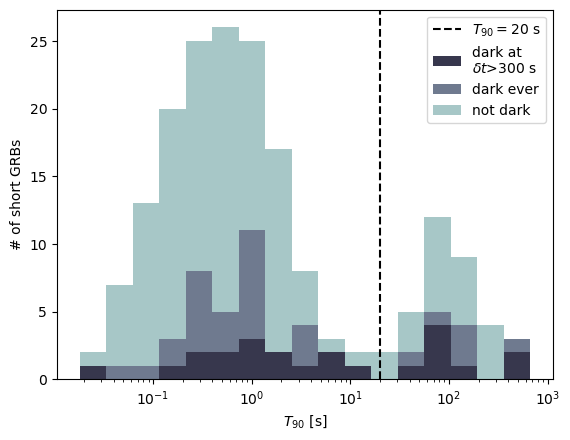

In [25]:
ee_cut = 20
early_cut = 300
for i,row in sGRBs.iterrows():
    grb = row["GRB"].strip()
    if grb in dark_matches["GRB"].values:
        if len(sdl:= dark_matches[(dark_matches["GRB"]==grb) & (dark_matches["t_o"]>=early_cut)]):
            sGRBs.loc[i,"flag"] = "short+dark+late"
        else:
            sGRBs.loc[i,"flag"] = "short+dark"
    else:
        sGRBs.loc[i,"flag"] = "short"

plt.axvline(ee_cut,linestyle="--",color="k")
sns.histplot(data=sGRBs.sort_values(by="flag"),x="T90",hue="flag",log_scale=True,multiple="stack",bins=17,palette="bone_r",alpha=1.,
             element="step",fill=True,edgecolor="none")
# plt.xticks(ticks=range(-2,4), labels=["$10^{%d}$"%int(i) for i in range(-2,4)])
plt.xlabel("$T_{90}$ [s]")
plt.ylabel("# of short GRBs")
plt.legend(labels=["$T_{90}=20$ s",f"dark at\n$\delta t$>{early_cut} s","dark ever","not dark"])
plt.savefig("./products/T90hist.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

In [26]:
ee_cut = 20
split_20s = [len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]>ee_cut)]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]>ee_cut)]),
             len(sGRBs.loc[sGRBs["T90"]>ee_cut]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]<=ee_cut)]),
             len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]<=ee_cut)]),
             len(sGRBs.loc[sGRBs["T90"]<=ee_cut])]
ee_cut = 2
split_2s = [len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]>ee_cut)]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]>ee_cut)]),
            len(sGRBs.loc[sGRBs["T90"]>ee_cut]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches.loc[dark_matches["t_o"]>=early_cut,"GRB"]) & (sGRBs["T90"]<=ee_cut)]),
            len(sGRBs.loc[sGRBs["GRB"].isin(dark_matches["GRB"]) & (sGRBs["T90"]<=ee_cut)]),
            len(sGRBs.loc[sGRBs["T90"]<=ee_cut])]
print(pd.DataFrame(np.array(split_20s+split_2s).reshape(3,4,order="F"),columns=["T90>20","T90<=20","T90>2","T90<=2"],index=["dark/late","dark","short"]).style.to_latex())

\begin{tabular}{lrrrr}
 & T90>20 & T90<=20 & T90>2 & T90<=2 \\
dark/late & 8 & 15 & 12 & 11 \\
dark & 14 & 39 & 21 & 32 \\
short & 33 & 150 & 54 & 129 \\
\end{tabular}



### Numbers

6.705882352941177 ± 0.540728715025007 short bursts per year
3.2941176470588234 ± 0.4436206802646575 dark short bursts per year


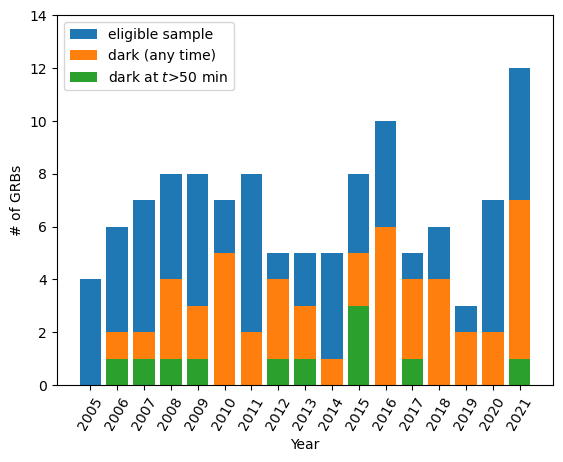

In [27]:
from src.utilities import addYear
addYear(sGRBs)
addYear(close_times)
addYear(all_optical)
addYear(results)
addYear(dark_matches)

dark_year_counts = {}
darklate_counts = {}
all_year_counts = {}

for year in range(2005,2022):
    sample = dark_matches[dark_matches["Year"]==year]
    dark_year_counts[str(year)] = len(sample["GRB"].unique())
        
for year in range(2005,2022):
    sample = results[results["Year"]==year]
    all_year_counts[str(year)] = len(sample["GRB"].unique())

for year in range(2005,2022):
    sample = dark_matches[(dark_matches["Year"]==year) & (dark_matches["t_o"]>50*60)]
    darklate_counts[str(year)] = len(sample["GRB"].unique())

plt.bar(all_year_counts.keys(),all_year_counts.values(),label="eligible sample")
plt.bar(dark_year_counts.keys(),dark_year_counts.values(),label="dark (any time)")
plt.bar(darklate_counts.keys(),darklate_counts.values(),label="dark at $t$>50 min")
plt.xlabel("Year")
plt.ylabel("# of GRBs")
plt.legend()
plt.xticks(rotation=60)
plt.ylim(0,14)
print(np.mean(list(all_year_counts.values())),"±",stats.sem(list(all_year_counts.values())),"short bursts per year")
print(np.mean(list(dark_year_counts.values())),"±",stats.sem(list(dark_year_counts.values())),"dark short bursts per year")
plt.savefig("./products/numbers.png",dpi=300,bbox_inches="tight")
plt.show()

In [28]:
close_times["time class"] = ["early" if t<300 else "mid" if (t>=300 and t<3000) else "late" if t>=3000 \
                             else None for t in close_times["t_o"]]
ct = pd.crosstab(close_times["time class"],close_times["Jak_dark"]|close_times["vdH_dark"],
                 rownames=["time"],colnames=["dark"])
display(ct)
chisq,p,dof,E = stats.chi2_contingency(ct)
chisq,p,dof

dark   False  True 
time               
early     41     61
late     680     26
mid      213     74

(261.900636057823, 1.3458587319625926e-57, 2)

In [29]:
conf = np.zeros((5,5))
tables = (sGRBs,xrt_data,all_optical,results,dark_matches)
names = ["main","xray","optical","matched","dark"]
for grb in sGRBs["GRB"].tolist():
    for i in range(5):
        for j in range(5):
            if j>i:
                conf[i,j] = np.nan
            elif grb in tables[i].GRB.tolist() and grb in tables[j].GRB.tolist():
                conf[i,j] += 1
conf 

array([[195.,  nan,  nan,  nan,  nan],
       [165., 165.,  nan,  nan,  nan],
       [168., 148., 168.,  nan,  nan],
       [111., 111., 111., 111.,  nan],
       [ 56.,  56.,  56.,  56.,  56.]])

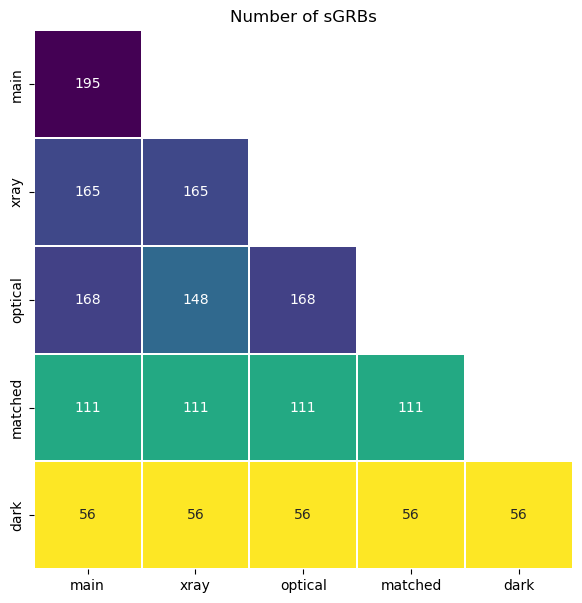

In [30]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=conf,annot=True,fmt="g",
            cmap="viridis_r",cbar=False,
            xticklabels=names,
            yticklabels=names,
            square=True,linewidths=0.1,ax=ax)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
plt.title("Number of sGRBs")
plt.show()

### Violin plots

(10, 10000000.0)

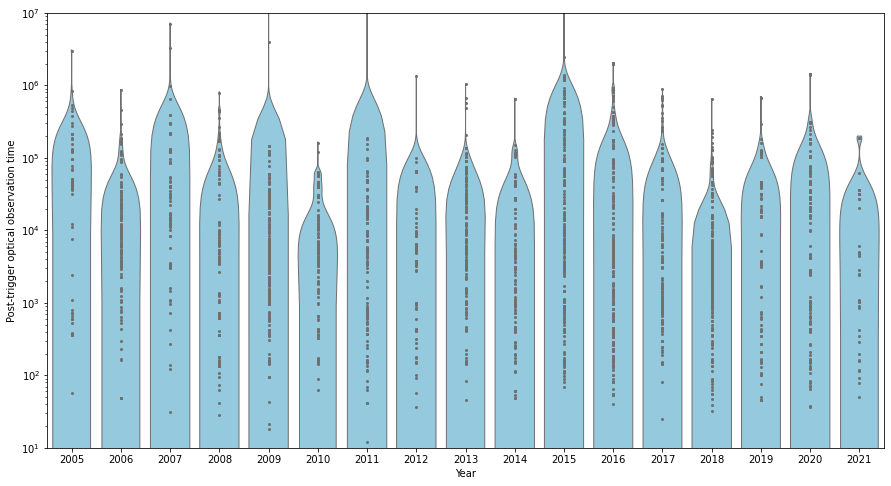

In [599]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="Time (s)",data=all_optical,linewidth=1,color="skyblue",
               scale="width",cut=.5,inner="point",ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
plt.ylim(10,1e7)

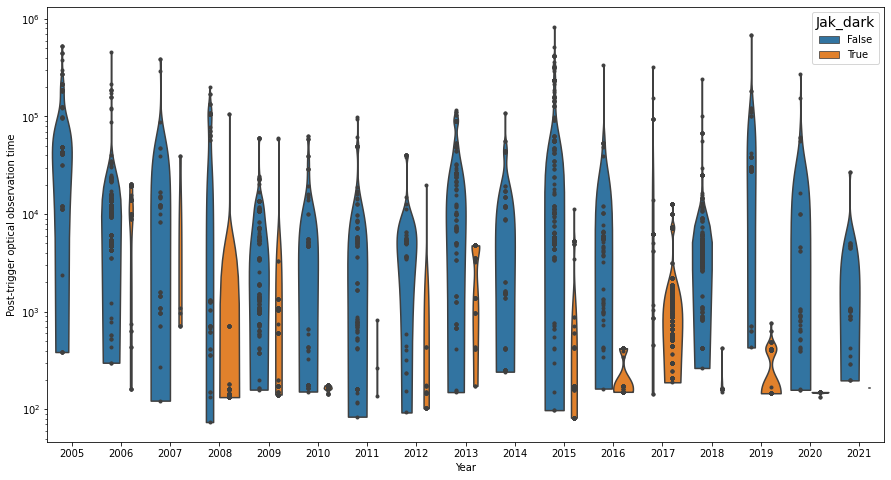

In [35]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="t_o",data=results[(results["t_o"]<1e6) & (results["Year"]>2004)],
               scale="count",inner="point",cut=0,hue="Jak_dark",split=False,ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
#plt.ylim(1,1e5)

## Optical spectra

In [48]:
for grb,data in results.groupby("GRB"):
    done = []
    for t_o in data["t_o"].unique():
        tmatch = data[np.abs(data["t_o"]-t_o)/t_o < 0.1].copy()
        for to,obs in tmatch.groupby("t_o"):
            tmatch.drop(tmatch[tmatch["dt%"]!=tmatch["dt%"].min()].index,axis=0,inplace=True)
        if t_o not in done and len(tmatch["nu_o"].unique()) > 2:
                print(grb,t_o)
                display(tmatch)
                done += tmatch["t_o"].unique().tolist()

060121 9000.0


GRB     t_o       dt%          nu_o  \
3490  060121  9720.0  0.116364  4.863784e+14   
3491  060121  9720.0  0.116364  4.863784e+14   
3492  060121  9720.0  0.116364  4.863784e+14   
3493  060121  9720.0  0.116364  4.863784e+14   
3494  060121  9720.0  0.116364  4.863784e+14   
3500  060121  9720.0  0.116364  3.916501e+14   
3501  060121  9720.0  0.116364  3.916501e+14   
3502  060121  9720.0  0.116364  3.916501e+14   
3503  060121  9720.0  0.116364  3.916501e+14   
3504  060121  9720.0  0.116364  3.916501e+14   
3510  060121  9720.0  0.116364  2.935631e+14   
3511  060121  9720.0  0.116364  2.935631e+14   
3512  060121  9720.0  0.116364  2.935631e+14   
3513  060121  9720.0  0.116364  2.935631e+14   
3514  060121  9720.0  0.116364  2.935631e+14   
3520  060121  9720.0  0.116364  3.372244e+14   
3521  060121  9720.0  0.116364  3.372244e+14   
3522  060121  9720.0  0.116364  3.372244e+14   
3523  060121  9720.0  0.116364  3.372244e+14   
3524  060121  9720.0  0.116364  3.372244e+14   

                                      F_o  \
3490  3.7239072180869405e-06 (+0.0, -inf)   
3491  3.7239072180869405e-06 (+0.0, -inf)   
3492  3.7239072180869405e-06 (+0.0, -inf)   
3493  3.7239072180869405e-06 (+0.0, -inf)   
3494  3.7239072180869405e-06 (+0.0, -inf)   
3500   4.873884834658412e-06 (+0.0, -inf)   
3501   4.873884834658412e-06 (+0.0, -inf)   
3502   4.873884834658412e-06 (+0.0, -inf)   
3503   4.873884834658412e-06 (+0.0, -inf)   
3504   4.873884834658412e-06 (+0.0, -inf)   
3510   8.410891167436347e-06 (+0.0, -inf)   
3511   8.410891167436347e-06 (+0.0, -inf)   
3512   8.410891167436347e-06 (+0.0, -inf)   
3513   8.410891167436347e-06 (+0.0, -inf)   
3514   8.410891167436347e-06 (+0.0, -inf)   
3520                   1.08e-05 ± 2.5e-06   
3521                   1.08e-05 ± 2.5e-06   
3522                   1.08e-05 ± 2.5e-06   
3523                   1.08e-05 ± 2.5e-06   
3524                   1.08e-05 ± 2.5e-06   

                                                   nu_x  \
3490  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3491  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3492  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3493  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3494  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3500  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3501  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3502  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3503  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3504  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3510  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3511  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3512  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3513  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3514  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3520  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3521  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3522  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3523  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3524  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
3490                                6.1e-07 ± 1.4e-07   
3491                                4.2e-07 ± 9.5e-08   
3492  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3493                 4.6999999999999995e-07 ± 1.1e-07   
3494                 3.4000000000000003e-07 ± 8.7e-07   
3500                                6.1e-07 ± 1.4e-07   
3501                                4.2e-07 ± 9.5e-08   
3502  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3503                 4.6999999999999995e-07 ± 1.1e-07   
3504                 3.4000000000000003e-07 ± 8.7e-07   
3510                                6.1e-07 ± 1.4e-07   
3511                                4.2e-07 ± 9.5e-08   
3512  4.5000000000000003e-07 ± 1.0000000000000001e-07   
3513            

080503 620.0


GRB    t_o       dt%          nu_o  \
3168  080503  620.0  0.123748  6.361576e+14   
3169  080503  620.0  0.123748  4.626870e+14   
3170  080503  620.0  0.123748  3.821188e+14   

                                      F_o  \
3168  0.00013164354645135812 (+0.0, -inf)   
3169   8.539105490522088e-05 (+0.0, -inf)   
3170  0.00022789739450369243 (+0.0, -inf)   

                                                   nu_x  \
3168  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3169  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3170  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                              F_x  \
3168  1.0110433739701649e-07 ± 2.297938039451e-08   
3169  1.0110433739701649e-07 ± 2.297938039451e-08   
3170  1.0110433739701649e-07 ± 2.297938039451e-08   

                                                 B_ox    α  \
3168  1.1050866413669602 (+0.14467013193440337, -inf)  8.0   
3169  0.9898254392685115 (+0.12432396480109532, -inf)  8.0   
3170   1.103017708565408 (+0.13389709922806223, -inf)  8.0   

                                           B_ox_w_err  \
3168  1.1050866413669602 (+0.43039424861514924, -inf)   
3169  0.9898254392685115 (+0.42398845549253483, -inf)   
3170    1.103017708565408 (+0.4268936581266706, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
3168  1.4500000000000002 (+0.32, -0.24)    False    False  2008  
3169  1.4500000000000002 (+0.32, -0.24)    False    False  2008  
3170  1.4500000000000002 (+0.32, -0.24)    False    False  2008

080913 180.0


GRB    t_o       dt%          nu_o  \
3019  080913  180.0  0.004001  4.916258e+14   
3020  080913  180.0  0.004001  3.942179e+14   
3021  080913  180.0  0.004001  3.357390e+14   

                                     F_o  \
3019  2.121749687386341e-06 (+0.0, -inf)   
3020  2.472131557899378e-06 (+0.0, -inf)   
3021         4.219450020502084e-06 ± 0.0   

                                                   nu_x  \
3019  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3020  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3021  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
3019  1.903896944943868e-06 ± 4.415637365634573e-07   
3020  1.903896944943868e-06 ± 4.415637365634573e-07   
3021  1.903896944943868e-06 ± 4.415637365634573e-07   

                                                   B_ox    α  \
3019  0.01605618847209473 (+0.033966781132171324, -inf)  1.2   
3020   0.03748108498254906 (+0.03313499678972337, -inf)  1.2   
3021  0.11163150427182805 (+0.03460854883856727, -0....  1.2   

                                             B_ox_w_err  \
3019   0.01605618847209473 (+0.03403045409397591, -inf)   
3020   0.03748108498254906 (+0.03320026502328483, -inf)   
3021  0.11163150427182805 (+0.034671043221582876, -0...   

                                   B_x Jak_dark vdH_dark  Year  
3019  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3020  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3021  0.6599999999999999 (+0.23, -0.2)     True    False  2008

080913 360.0


GRB    t_o       dt%          nu_o  \
3022  080913  360.0  0.090916  2.455797e+14   
3023  080913  360.0  0.090916  1.838814e+14   
3024  080913  360.0  0.090916  1.369818e+14   

                                      F_o  \
3022   0.0005394043662051895 (+0.0, -inf)   
3023  0.00048688466512590166 (+0.0, -inf)   
3024   0.0017573716758739568 (+0.0, -inf)   

                                                   nu_x  \
3022  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3023  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3024  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
3022  1.0871714979756532e-06 ± 2.577277212404609e-07   
3023  1.0871714979756532e-06 ± 2.577277212404609e-07   
3024  1.0871714979756532e-06 ± 2.577277212404609e-07   

                                                 B_ox    α  \
3022  0.8340860037015736 (+0.09786142192508118, -inf)  1.2   
3023  0.7896194722319819 (+0.08970857648510752, -inf)  1.2   
3024  0.9205862265650239 (+0.09922308685231154, -inf)  1.2   

                                           B_ox_w_err  \
3022  0.8340860037015736 (+0.10785842933373392, -inf)   
3023  0.7896194722319819 (+0.10051970738181493, -inf)   
3024  0.9205862265650239 (+0.10909538872767571, -inf)   

                                   B_x Jak_dark vdH_dark  Year  
3022  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3023  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3024  0.6599999999999999 (+0.23, -0.2)    False    False  2008

080913 720.0


GRB    t_o       dt%          nu_o  \
3028  080913  720.0  0.087132  6.655414e+14   
3030  080913  720.0  0.087132  4.916258e+14   
3032  080913  720.0  0.087132  3.942179e+14   
3034  080913  720.0  0.087132  3.357390e+14   
3036  080913  720.0  0.087132  2.447983e+14   
3038  080913  720.0  0.087132  1.835816e+14   
3040  080913  720.0  0.087132  1.391121e+14   

                                                  F_o  \
3028              1.7379058652234989e-06 (+0.0, -inf)   
3030              1.7379058652234989e-06 (+0.0, -inf)   
3032               2.291006117807585e-06 (+0.0, -inf)   
3034     3.5647267811055704e-06 ± 4.9248520480622e-07   
3036   1.5849889868640448e-05 ± 8.758972832910923e-07   
3038  1.9589630703524253e-05 ± 1.6238444988669629e-06   
3040  2.2081381896430282e-05 ± 4.2709179061440324e-06   

                                                   nu_x  \
3028  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3030  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3032  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3034  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3036  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3038  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3040  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
3028  3.1524048793554437e-07 ± 7.501152180985261e-08   
3030  3.1524048793554437e-07 ± 7.501152180985261e-08   
3032  3.1524048793554437e-07 ± 7.501152180985261e-08   
3034  3.1524048793554437e-07 ± 7.501152180985261e-08   
3036  3.1524048793554437e-07 ± 7.501152180985261e-08   
3038  3.1524048793554437e-07 ± 7.501152180985261e-08   
3040  3.1524048793554437e-07 ± 7.501152180985261e-08   

                                                   B_ox    α  \
3028   0.26489000672688745 (+0.04983506698980007, -inf)  1.2   
3030    0.2529994851385232 (+0.04661666694478352, -inf)  1.2   
3032    0.284634977772599 (+0.047718095625235796, -inf)  1.2   
3034  0.3402391403389642 (+0.05494124585817459, -0.2...  1.2   
3036  0.5262222241705741 (+0.06682880308734643, -0.3...  1.2   
3038  0.5340339423580948 (+0.06556209647062891, -0.3...  1.2   
3040  0.5304888899837922 (+0.06664551984915405, -0.3...  1.2   

                                             B_ox_w_err  \
3028   0.26489000672688745 (+0.06617518208200589, -inf)   
3030      0.2529994851385232 (+0.063786632288824, -inf)   
3032     0.284634977772599 (+0.06459595553754059, -inf)   
3034  0.3402391403389642 (+0.07010107929381086, -0.2...   
3036  0.5262222241705741 (+0.07976032687869387, -0.3...   
3038  0.5340339423580948 (+0.07870202866084726, -0.3...   
3040  0.5304888899837922 (+0.07960682218046868, -0.3...   

                                   B_x Jak_dark vdH_dark  Year  
3028  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3030  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3032  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3034  0.6599999999999999 (+0.23, -0.2)     True    False  2008  
3036  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3038  0.6599999999999999 (+0.23, -0.2)    False    False  2008  
3040  0.6599999999999999 (+0.23, -0.2)    False    False  2008

090423 13716.864000000001


GRB        t_o       dt%          nu_o  \
2986  090423  13716.864  0.124212  6.361576e+14   
2993  090423  13716.864  0.124212  4.626870e+14   
3000  090423  13716.864  0.124212  3.821188e+14   

                                      F_o  \
2986  2.7524086323556257e-05 (+0.0, -inf)   
2993   3.204197770117918e-05 (+0.0, -inf)   
3000   6.010115310236266e-05 (+0.0, -inf)   

                                                   nu_x  \
2986  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2993  4.1880632448032506e+17 (+1.9991731172900093e+1...   
3000  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2986  1.123057848924482e-07 ± 2.9678819485253674e-08   
2993  1.123057848924482e-07 ± 2.9678819485253674e-08   
3000  1.123057848924482e-07 ± 2.9678819485253674e-08   

                                                B_ox     α  \
2986  0.847739734882957 (+0.11542435421285616, -inf)  1.41   
2993   0.830417564370326 (+0.1080604544762866, -inf)  1.41   
3000  0.8975812153941012 (+0.1125469306595297, -inf)  1.41   

                                           B_ox_w_err          B_x Jak_dark  \
2986   0.847739734882957 (+0.13587887920961053, -inf)  0.71 ± 0.13    False   
2993   0.830417564370326 (+0.12968172612757223, -inf)  0.71 ± 0.13    False   
3000  0.8975812153941012 (+0.13344324587886056, -inf)  0.71 ± 0.13    False   

     vdH_dark  Year  
2986    False  2009  
2993    False  2009  
3000    False  2009

090426 376.704


GRB      t_o       dt%          nu_o  \
2817  090426  376.704  0.088658  6.361576e+14   
2819  090426  376.704  0.088658  4.626870e+14   
2821  090426  376.704  0.088658  3.821188e+14   

                                                F_o  \
2817  0.0002900574494604127 ± 2.137222269566145e-05   
2819   0.0004541036146342407 ± 3.34595908394085e-05   
2821    0.0006495271153159908 ± 5.9823658128881e-05   

                                                   nu_x  \
2817  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2819  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2821  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2817  1.9067051798127283e-06 ± 4.2987684486984494e-07   
2819  1.9067051798127283e-06 ± 4.2987684486984494e-07   
2821  1.9067051798127283e-06 ± 4.2987684486984494e-07   

                                                   B_ox     α  \
2817  0.7742559346880049 (+0.10515512911583419, -0.5...  0.94   
2819  0.8038862677674623 (+0.10362029645527401, -0.5...  0.94   
2821  0.8330486864883209 (+0.10433901938502343, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2817  0.7742559346880049 (+0.11072563169201569, -0.5...  0.96 (+0.16, -0.15)   
2819  0.8038862677674623 (+0.10926907234760906, -0.5...  0.96 (+0.16, -0.15)   
2821  0.8330486864883209 (+0.1099508767607446, -0.57...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2817    False    False  2009  
2819    False    False  2009  
2821    False    False  2009

090426 964.224


GRB       t_o       dt%          nu_o  \
2846  090426  1035.072  0.014465  6.361576e+14   
2849  090426  1035.072  0.014465  4.626870e+14   
2852  090426  1035.072  0.014465  3.821188e+14   

                                                 F_o  \
2846  6.523550426659195e-05 ± 1.8626077157617312e-05   
2849  8.187568733739936e-05 ± 2.0360779611307614e-05   
2852  0.00017889462245997354 ± 4.283968945288582e-05   

                                                   nu_x  \
2846  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2849  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2852  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
2846  5.478940951090471e-07 ± 1.262003838027628e-07   
2849  5.478940951090471e-07 ± 1.262003838027628e-07   
2852  5.478940951090471e-07 ± 1.262003838027628e-07   

                                                   B_ox     α  \
2846  0.7365000297957721 (+0.10950500635973141, -0.5...  0.94   
2849  0.7354277515246661 (+0.10221589606917719, -0.5...  0.94   
2852  0.8269913854324535 (+0.1085776081541656, -0.56...  0.94   

                                             B_ox_w_err                  B_x  \
2846  0.7365000297957721 (+0.109661844571703, -0.544...  0.96 (+0.16, -0.15)   
2849  0.7354277515246661 (+0.10238390081574526, -0.5...  0.96 (+0.16, -0.15)   
2852  0.8269913854324535 (+0.10873578403406607, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2846    False    False  2009  
2849    False    False  2009  
2852    False    False  2009

090426 5040.0


GRB       t_o       dt%          nu_o  \
2899  090426  5480.352  0.020503  6.361576e+14   
2902  090426  5480.352  0.020503  4.626870e+14   
2905  090426  5480.352  0.020503  3.821188e+14   

                                                 F_o  \
2899   2.6211026155413417e-05 ± 9.17367395082486e-06   
2902  4.2968971527745086e-05 ± 8.706694770494286e-06   
2905    6.14606693826714e-05 ± 1.981257895763646e-05   

                                                   nu_x  \
2899  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2902  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2905  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2899  1.3680813654310403e-07 ± 3.642941631008612e-08   
2902  1.3680813654310403e-07 ± 3.642941631008612e-08   
2905  1.3680813654310403e-07 ± 3.642941631008612e-08   

                                                   B_ox     α  \
2899  0.8097973394603906 (+0.12340032416090582, -0.5...  0.94   
2902  0.8445297429445892 (+0.11369727557595544, -0.5...  0.94   
2905  0.8725812324595142 (+0.11910155347210366, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2899  0.8097973394603906 (+0.1236781658597461, -0.59...  0.96 (+0.16, -0.15)   
2902  0.8445297429445892 (+0.11399876833022794, -0.5...  0.96 (+0.16, -0.15)   
2905  0.8725812324595142 (+0.11938939964202264, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2899    False    False  2009  
2902    False    False  2009  
2905    False    False  2009

090426 5760.0


GRB       t_o       dt%          nu_o  \
2899  090426  5480.352  0.020503  6.361576e+14   
2902  090426  5480.352  0.020503  4.626870e+14   
2905  090426  5480.352  0.020503  3.821188e+14   

                                                 F_o  \
2899   2.6211026155413417e-05 ± 9.17367395082486e-06   
2902  4.2968971527745086e-05 ± 8.706694770494286e-06   
2905    6.14606693826714e-05 ± 1.981257895763646e-05   

                                                   nu_x  \
2899  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2902  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2905  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2899  1.3680813654310403e-07 ± 3.642941631008612e-08   
2902  1.3680813654310403e-07 ± 3.642941631008612e-08   
2905  1.3680813654310403e-07 ± 3.642941631008612e-08   

                                                   B_ox     α  \
2899  0.8097973394603906 (+0.12340032416090582, -0.5...  0.94   
2902  0.8445297429445892 (+0.11369727557595544, -0.5...  0.94   
2905  0.8725812324595142 (+0.11910155347210366, -0.5...  0.94   

                                             B_ox_w_err                  B_x  \
2899  0.8097973394603906 (+0.1236781658597461, -0.59...  0.96 (+0.16, -0.15)   
2902  0.8445297429445892 (+0.11399876833022794, -0.5...  0.96 (+0.16, -0.15)   
2905  0.8725812324595142 (+0.11938939964202264, -0.5...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2899    False    False  2009  
2902    False    False  2009  
2905    False    False  2009

090426 7200.0


GRB     t_o      dt%          nu_o  \
2914  090426  7200.0  0.04132  3.757363e+14   
2918  090426  7200.0  0.04132  4.673887e+14   
2922  090426  7200.0  0.04132  5.505123e+14   
2926  090426  7200.0  0.04132  4.163784e+14   

                                                F_o  \
2914  7.949221981227501e-05 ± 4.392902408370009e-06   
2918  2.893310868754059e-05 ± 5.329675580632599e-07   
2922  1.5630692105522657e-05 ± 5.75855978165699e-07   
2926                             2.46e-05 ± 3.9e-06   

                                                   nu_x  \
2914  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2918  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2922  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2926  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2914  8.770752409196573e-08 ± 2.3297121213128358e-08   
2918  8.770752409196573e-08 ± 2.3297121213128358e-08   
2922  8.770752409196573e-08 ± 2.3297121213128358e-08   
2926  8.770752409196573e-08 ± 2.3297121213128358e-08   

                                                   B_ox     α  \
2914  0.9705157538514715 (+0.12069646347029996, -0.6...  0.94   
2918  0.8530055786032785 (+0.11085890313044564, -0.6...  0.94   
2922  0.7812388003580433 (+0.10538116392544472, -0.5...  0.94   
2926  0.815279884549556 (+0.10724219591114781, -0.56...  0.94   

                                             B_ox_w_err                  B_x  \
2914  0.9705157538514715 (+0.12182302526321022, -0.6...  0.96 (+0.16, -0.15)   
2918  0.8530055786032785 (+0.1120843860371677, -0.60...  0.96 (+0.16, -0.15)   
2922  0.7812388003580433 (+0.10666959688835781, -0.5...  0.96 (+0.16, -0.15)   
2926  0.815279884549556 (+0.10850853318466853, -0.56...  0.96 (+0.16, -0.15)   

     Jak_dark vdH_dark  Year  
2914    False    False  2009  
2918    False    False  2009  
2922    False    False  2009  
2926    False    False  2009

110106A 8317.5


GRB       t_o       dt%          nu_o  \
2582  110106A  8584.704  0.131444  6.361576e+14   
2583  110106A  8584.704  0.131444  4.626870e+14   
2584  110106A  8584.704  0.131444  3.821188e+14   

                                      F_o  \
2582   3.610102623089009e-05 (+0.0, -inf)   
2583  4.0324665023164604e-05 (+0.0, -inf)   
2584   8.144767535214837e-05 (+0.0, -inf)   

                                                   nu_x  \
2582  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2583  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2584  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2582  4.0613023643797727e-08 ± 1.2711438854735009e-08   
2583  4.0613023643797727e-08 ± 1.2711438854735009e-08   
2584  4.0613023643797727e-08 ± 1.2711438854735009e-08   

                                                 B_ox     α  \
2582     1.04626862051361 (+0.1417520858924979, -inf)  1.11   
2583   1.013589174375667 (+0.13139777819425336, -inf)  1.11   
2584  1.0863205719340059 (+0.13588772208844457, -inf)  1.11   

                                           B_ox_w_err        B_x Jak_dark  \
2582    1.04626862051361 (+0.15374585570132585, -inf)  1.5 ± 0.5    False   
2583   1.013589174375667 (+0.14425501864699544, -inf)  1.5 ± 0.5    False   
2584  1.0863205719340059 (+0.14835635242498094, -inf)  1.5 ± 0.5    False   

     vdH_dark  Year  
2582    False  2011  
2583    False  2011  
2584    False  2011

120804A 40249.439999999995


GRB       t_o       dt%          nu_o  \
2419  120804A  40249.44  0.043178  6.361576e+14   
2421  120804A  40249.44  0.043178  4.626870e+14   
2423  120804A  40249.44  0.043178  3.821188e+14   

                                      F_o  \
2419   8.022147818660016e-05 (+0.0, -inf)   
2421    6.87078586326926e-05 (+0.0, -inf)   
2423  0.00011603611367984676 (+0.0, -inf)   

                                                   nu_x  \
2419  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2421  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2423  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2419  1.8369754505165708e-08 ± 4.956214647375757e-09   
2421  1.8369754505165708e-08 ± 4.956214647375757e-09   
2423  1.8369754505165708e-08 ± 4.956214647375757e-09   

                                                 B_ox      α  \
2419  1.2915571486591046 (+0.16968414926932468, -inf)  1.095   
2421  1.2083984399538599 (+0.15197536585438406, -inf)  1.095   
2423    1.25023728503006 (+0.15259899622738995, -inf)  1.095   

                                           B_ox_w_err                 B_x  \
2419  1.2915571486591046 (+0.17087078001922076, -inf)  0.96 (+0.21, -0.2)   
2421   1.2083984399538599 (+0.1532991349541685, -inf)  0.96 (+0.21, -0.2)   
2423    1.25023728503006 (+0.15391740187753122, -inf)  0.96 (+0.21, -0.2)   

     Jak_dark vdH_dark  Year  
2419    False    False  2012  
2421    False    False  2012  
2423    False    False  2012

121226A 3621.0


GRB       t_o       dt%          nu_o  \
2330  121226A  3743.712  0.147952  6.361576e+14   
2331  121226A  3743.712  0.147952  4.626870e+14   
2332  121226A  3743.712  0.147952  3.821188e+14   

                                     F_o  \
2330   3.57096118716993e-05 (+0.0, -inf)   
2331  3.366124705196544e-05 (+0.0, -inf)   
2332  6.231557414690432e-05 (+0.0, -inf)   

                                                   nu_x  \
2330  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2331  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2332  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
2330  9.076190564751554e-08 ± 2.680644949568071e-08   
2331  9.076190564751554e-08 ± 2.680644949568071e-08   
2332  9.076190564751554e-08 ± 2.680644949568071e-08   

                                                 B_ox     α  \
2330  0.9206772890969991 (+0.12581455551490522, -inf)  1.04   
2331  0.8689430854563214 (+0.11409591197826185, -inf)  1.04   
2332  0.9331795411056737 (+0.11803046160879098, -inf)  1.04   

                                           B_ox_w_err        B_x Jak_dark  \
2330  0.9206772890969991 (+0.14040353908743852, -inf)  1.4 ± 0.4    False   
2331   0.8689430854563214 (+0.1300066480569974, -inf)  1.4 ± 0.4    False   
2332  0.9331795411056737 (+0.13347299830470952, -inf)  1.4 ± 0.4    False   

     vdH_dark  Year  
2330    False  2012  
2331    False  2012  
2332    False  2012

130603B 43920.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 51840.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52200.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52560.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 52920.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130603B 53280.0


GRB      t_o       dt%          nu_o  \
2306  130603B  48222.0  0.003044  4.875221e+14   
2307  130603B  48222.0  0.003044  3.980626e+14   
2308  130603B  48222.0  0.003044  3.411380e+14   
2309  130603B  48222.0  0.003044  2.947018e+14   
2310  130603B  48222.0  0.003044  2.411140e+14   
2311  130603B  48222.0  0.003044  1.860597e+14   

                                                  F_o  \
2306   1.8467041630481676e-05 ± 5.102632172405707e-07   
2307   2.3198105676394787e-05 ± 6.409873477940062e-07   
2308  3.0929821070392294e-05 ± 1.4243708985131687e-06   
2309   3.909311382994146e-05 ± 1.8003044228708514e-06   
2310    3.782193109767061e-05 ± 2.090117153609863e-06   
2311    5.543684432520371e-05 ± 3.063553232300295e-06   

                                                   nu_x  \
2306  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2307  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2308  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2309  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2310  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2311  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                  F_x  \
2306  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2307  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2308  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2309  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2310  2.2546776018122463e-08 ± 5.2193438980126646e-09   
2311  2.2546776018122463e-08 ± 5.2193438980126646e-09   

                                                   B_ox    α  \
2306  0.9929427727910082 (+0.12629745964193007, -0.7...  1.0   
2307  0.9967923134119577 (+0.12305813134006764, -0.6...  1.0   
2308  1.015606535995575 (+0.12260394563943981, -0.68...  1.0   
2309  1.027401035754334 (+0.12142665308775755, -0.67...  1.0   
2310  0.9953294612075222 (+0.11481140363912007, -0.6...  1.0   
2311  1.0114406539775094 (+0.11261521113185216, -0.6...  1.0   

                                             B_ox_w_err                  B_x  \
2306  0.9929427727910082 (+0.12630435934017228, -0.7...  0.97 (+0.14, -0.13)   
2307  0.9967923134119577 (+0.12306521265262474, -0.6...  0.97 (+0.14, -0.13)   
2308  1.015606535995575 (+0.12261105318316584, -0.68...  0.97 (+0.14, -0.13)   
2309  1.027401035754334 (+0.1214338295386464, -0.676...  0.97 (+0.14, -0.13)   
2310  0.9953294612075222 (+0.11481899355904215, -0.6...  0.97 (+0.14, -0.13)   
2311  1.0114406539775094 (+0.11262294905834268, -0.6...  0.97 (+0.14, -0.13)   

     Jak_dark vdH_dark  Year  
2306    False    False  2013  
2307    False    False  2013  
2308    False    False  2013  
2309    False    False  2013  
2310    False    False  2013  
2311    False    False  2013

130912A 89280.0


GRB      t_o       dt%          nu_o  \
2232  130912A  89856.0  0.175668  4.875220e+14   
2233  130912A  89856.0  0.175668  3.980624e+14   
2234  130912A  89856.0  0.175668  2.411140e+14   

                                      F_o  \
2232  3.1421092304797613e-06 (+0.0, -inf)   
2233  2.6791310634162193e-06 (+0.0, -inf)   
2234   6.310598339633804e-06 (+0.0, -inf)   

                                                   nu_x  \
2232  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2233  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2234  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                    F_x  \
2232  3.0210587457260483e-09 (+2.1184929337295118e-1...   
2233  3.0210587457260483e-09 (+2.1184929337295118e-1...   
2234  3.0210587457260483e-09 (+2.1184929337295118e-1...   

                          B_ox      α                B_ox_w_err  \
2232  1.0283035393026794 ± inf  1.463  1.0283035393026794 ± inf   
2233   0.975438200435569 ± inf  1.463   0.975438200435569 ± inf   
2234  1.0247301507735775 ± inf  1.463  1.0247301507735775 ± inf   

                      B_x Jak_dark vdH_dark  Year  
2232  0.44 (+0.21, -0.11)    False    False  2013  
2233  0.44 (+0.21, -0.11)    False    False  2013  
2234  0.44 (+0.21, -0.11)    False    False  2013

131004A 10080.0


GRB      t_o       dt%          nu_o  \
2206  131004A  10080.0  0.106765  6.284957e+14   
2207  131004A  10080.0  0.106765  4.819814e+14   
2208  131004A  10080.0  0.106765  3.929128e+14   
2209  131004A  10080.0  0.106765  3.283598e+14   
2210  131004A  10080.0  0.106765  2.417681e+14   
2211  131004A  10080.0  0.106765  1.946704e+14   
2212  131004A  10080.0  0.106765  1.375195e+14   

                                  F_o  \
2206                  6e-06 ± 5.8e-07   
2207  9.6e-06 ± 9.300000000000001e-07   
2208               1.31e-05 ± 1.3e-06   
2209                1.4e-05 ± 1.4e-06   
2210               4.65e-05 ± 7.4e-06   
2211                3.4e-05 ± 6.9e-06   
2212            4.73e-05 (+0.0, -inf)   

                                                   nu_x  \
2206  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2207  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2208  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2209  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2210  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2211  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2212  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                               F_x  \
2206  5.533402987039364e-08 ± 1.20894719455795e-08   
2207  5.533402987039364e-08 ± 1.20894719455795e-08   
2208  5.533402987039364e-08 ± 1.20894719455795e-08   
2209  5.533402987039364e-08 ± 1.20894719455795e-08   
2210  5.533402987039364e-08 ± 1.20894719455795e-08   
2211  5.533402987039364e-08 ± 1.20894719455795e-08   
2212  5.533402987039364e-08 ± 1.20894719455795e-08   

                                                   B_ox     α  \
2206  0.7207391325921417 (+0.09869380030764972, -0.5...  0.97   
2207  0.7619230866559398 (+0.09951743909293699, -0.5...  0.97   
2208  0.7841812637544955 (+0.09912251347310588, -0.5...  0.97   
2209  0.7737914573085923 (+0.09552414224588819, -0.5...  0.97   
2210  0.9029975352918039 (+0.10644184607012454, -0.5...  0.97   
2211  0.8367016326428296 (+0.09813041963779483, -0.5...  0.97   
2212    0.8416085610066762 (+0.09088795978958712, -inf)  0.97   

                                             B_ox_w_err  \
2206  0.7207391325921417 (+0.10754831142618532, -0.5...   
2207  0.7619230866559398 (+0.10830463404247265, -0.5...   
2208  0.7841812637544955 (+0.10794186281829474, -0.5...   
2209  0.7737914573085923 (+0.10464719214231304, -0.5...   
2210  0.9029975352918039 (+0.11469978058511528, -0.5...   
2211  0.8367016326428296 (+0.10703154829183407, -0.5...   
2212    0.8416085610066762 (+0.10043303393889437, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
2206  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2207  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2208  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2209  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2210  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2211  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2212  0.8700000000000001 (+0.19, -0.18)    False    False  2013

131004A 26280.0


GRB      t_o       dt%          nu_o  \
2213  131004A  26280.0  0.137647  4.804366e+14   
2214  131004A  26280.0  0.137647  3.893409e+14   
2215  131004A  26280.0  0.137647  3.414493e+14   
2216  131004A  26280.0  0.137647  2.991941e+14   
2217  131004A  26280.0  0.137647  2.398340e+14   
2218  131004A  26280.0  0.137647  1.833593e+14   

                                      F_o  \
2213  1.6000000000000001e-06 (+0.0, -inf)   
2214  1.8999999999999998e-06 (+0.0, -inf)   
2215  2.8999999999999998e-06 (+0.0, -inf)   
2216                 4.8e-06 (+0.0, -inf)   
2217  3.6000000000000003e-06 (+0.0, -inf)   
2218  3.6000000000000003e-06 (+0.0, -inf)   

                                                   nu_x  \
2213  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2214  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2215  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2216  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2217  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2218  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2213  1.3461365204079787e-08 ± 3.668771224659887e-09   
2214  1.3461365204079787e-08 ± 3.668771224659887e-09   
2215  1.3461365204079787e-08 ± 3.668771224659887e-09   
2216  1.3461365204079787e-08 ± 3.668771224659887e-09   
2217  1.3461365204079787e-08 ± 3.668771224659887e-09   
2218  1.3461365204079787e-08 ± 3.668771224659887e-09   

                                                 B_ox     α  \
2213  0.7057022934550411 (+0.09506946565438838, -inf)  0.97   
2214  0.7090663220232315 (+0.09256755710457222, -inf)  0.97   
2215  0.7554371348152612 (+0.09577679476287533, -inf)  0.97   
2216   0.8112216320773077 (+0.0999006085665724, -inf)  0.97   
2217  0.7486541103991339 (+0.09055630590672556, -inf)  0.97   
2218  0.7226623280122498 (+0.08487545141344487, -inf)  0.97   

                                           B_ox_w_err  \
2213  0.7057022934550411 (+0.10949723213252095, -inf)   
2214  0.7090663220232315 (+0.10733216280864039, -inf)   
2215  0.7554371348152612 (+0.11011192015364271, -inf)   
2216  0.8112216320773077 (+0.11371707056042098, -inf)   
2217  0.7486541103991339 (+0.10560248616554775, -inf)   
2218   0.7226623280122498 (+0.1007734230713053, -inf)   

                                    B_x Jak_dark vdH_dark  Year  
2213  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2214  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2215  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2216  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2217  0.8700000000000001 (+0.19, -0.18)    False    False  2013  
2218  0.8700000000000001 (+0.19, -0.18)    False    False  2013

150423A 23744.0


GRB      t_o     dt%          nu_o  \
2190  150423A  23744.0  0.1276  6.361576e+14   
2191  150423A  23744.0  0.1276  4.626870e+14   
2192  150423A  23744.0  0.1276  3.821188e+14   

                                      F_o  \
2190   6.913737897583929e-05 (+0.0, -inf)   
2191   7.340393024633758e-05 (+0.0, -inf)   
2192  0.00016553232097824908 (+0.0, -inf)   

                                                   nu_x  \
2190  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2191  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2192  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                    F_x  \
2190  7.925447418402119e-09 (+8.998109225522292e-10,...   
2191  7.925447418402119e-09 (+8.998109225522292e-10,...   
2192  7.925447418402119e-09 (+8.998109225522292e-10,...   

                          B_ox     α                B_ox_w_err  \
2190  1.3981767354801273 ± inf  0.92  1.3981767354801273 ± inf   
2191  1.3415837491713423 ± inf  0.92  1.3415837491713423 ± inf   
2192   1.421092822127607 ± inf  0.92   1.421092822127607 ± inf   

                      B_x Jak_dark vdH_dark  Year  
2190  0.47 (+0.34, -0.22)    False    False  2015  
2191  0.47 (+0.34, -0.22)    False    False  2015  
2192  0.47 (+0.34, -0.22)    False    False  2015

150424A 55440.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 57903.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 57929.0


GRB      t_o       dt%          nu_o  \
2101  150424A  55440.0  0.057977  6.655414e+14   
2103  150424A  55440.0  0.057977  4.916258e+14   
2105  150424A  55440.0  0.057977  3.942179e+14   
2107  150424A  55440.0  0.057977  3.357390e+14   
2109  150424A  55440.0  0.057977  2.447983e+14   
2111  150424A  55440.0  0.057977  1.835816e+14   

                                                  F_o  \
2101  6.9746984577075225e-06 ± 1.2847869357476723e-06   
2103    9.462975734507833e-06 ± 8.715722744656847e-07   
2105  1.0956722048534668e-05 ± 1.0091513942814043e-06   
2107   1.413519378047769e-05 ± 1.3018994594204034e-06   
2109  2.6165811647089637e-05 ± 1.2049801568935717e-05   
2111               4.084094283736099e-05 (+0.0, -inf)   

                                                   nu_x  \
2101  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2103  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2105  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2107  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2109  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2111  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2101  6.022038632469084e-08 ± 1.1598114030095341e-08   
2103  6.022038632469084e-08 ± 1.1598114030095341e-08   
2105  6.022038632469084e-08 ± 1.1598114030095341e-08   
2107  6.022038632469084e-08 ± 1.1598114030095341e-08   
2109  6.022038632469084e-08 ± 1.1598114030095341e-08   
2111  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2101  0.7373709318531413 (+0.10319804282843749, -0.5...  0.71   
2103  0.7494882217749413 (+0.0970913129478401, -0.53...  0.71   
2105  0.7467714233509162 (+0.09370977543552947, -0.5...  0.71   
2107  0.7656813627719891 (+0.09367547888250041, -0.5...  0.71   
2109  0.8159058209006729 (+0.11269114558657156, -0.5...  0.71   
2111    0.8431200300761091 (+0.09349282754330498, -inf)  0.71   

                                             B_ox_w_err                  B_x  \
2101  0.7373709318531413 (+0.10465099371308445, -0.5...  1.02 (+0.18, -0.17)   
2103  0.7494882217749413 (+0.0986342612455299, -0.53...  1.02 (+0.18, -0.17)   
2105  0.7467714233509162 (+0.09530748372343792, -0.5...  1.02 (+0.18, -0.17)   
2107  0.7656813627719891 (+0.09527376231356566, -0.5...  1.02 (+0.18, -0.17)   
2109  0.8159058209006729 (+0.11402319384726026, -0.5...  1.02 (+0.18, -0.17)   
2111    0.8431200300761091 (+0.09509418091323038, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2101    False    False  2015  
2103    False    False  2015  
2105    False    False  2015  
2107    False    False  2015  
2109    False    False  2015  
2111    False    False  2015

150424A 62645.0


GRB      t_o       dt%          nu_o  \
2112  150424A  57903.0  0.104979  6.655414e+14   
2113  150424A  57903.0  0.104979  4.916258e+14   
2114  150424A  57903.0  0.104979  3.942179e+14   
2115  150424A  57903.0  0.104979  3.357390e+14   

                                                 F_o  \
2112  8.700123872960009e-06 ± 3.2052440859326946e-07   
2113  9.908952041116072e-06 ± 2.7379446308480145e-07   
2114  1.0463588323448175e-05 ± 4.818660498559666e-07   
2115  1.1865929580408905e-05 ± 6.557355015927992e-07   

                                                   nu_x  \
2112  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2113  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2114  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2115  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2112  6.022038632469084e-08 ± 1.1598114030095341e-08   
2113  6.022038632469084e-08 ± 1.1598114030095341e-08   
2114  6.022038632469084e-08 ± 1.1598114030095341e-08   
2115  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2112  0.77167087871049 (+0.10352507301544123, -0.572...  0.71   
2113  0.7563132786183585 (+0.09701275987673134, -0.5...  0.71   
2114  0.740162642770765 (+0.09226131471893582, -0.50...  0.71   
2115  0.7411336495585102 (+0.09039204911568959, -0.4...  0.71   

                                             B_ox_w_err                  B_x  \
2112  0.77167087871049 (+0.10800428921280271, -0.573...  1.02 (+0.18, -0.17)   
2113  0.7563132786183585 (+0.10177898272438485, -0.5...  1.02 (+0.18, -0.17)   
2114  0.740162642770765 (+0.0972606597714452, -0.508...  1.02 (+0.18, -0.17)   
2115  0.7411336495585102 (+0.0954893098144684, -0.49...  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2112    False    False  2015  
2113    False    False  2015  
2114    False    False  2015  
2115    False    False  2015

150424A 62670.0


GRB      t_o       dt%          nu_o  \
2112  150424A  57903.0  0.104979  6.655414e+14   
2113  150424A  57903.0  0.104979  4.916258e+14   
2114  150424A  57903.0  0.104979  3.942179e+14   
2115  150424A  57903.0  0.104979  3.357390e+14   

                                                 F_o  \
2112  8.700123872960009e-06 ± 3.2052440859326946e-07   
2113  9.908952041116072e-06 ± 2.7379446308480145e-07   
2114  1.0463588323448175e-05 ± 4.818660498559666e-07   
2115  1.1865929580408905e-05 ± 6.557355015927992e-07   

                                                   nu_x  \
2112  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2113  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2114  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2115  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2112  6.022038632469084e-08 ± 1.1598114030095341e-08   
2113  6.022038632469084e-08 ± 1.1598114030095341e-08   
2114  6.022038632469084e-08 ± 1.1598114030095341e-08   
2115  6.022038632469084e-08 ± 1.1598114030095341e-08   

                                                   B_ox     α  \
2112  0.77167087871049 (+0.10352507301544123, -0.572...  0.71   
2113  0.7563132786183585 (+0.09701275987673134, -0.5...  0.71   
2114  0.740162642770765 (+0.09226131471893582, -0.50...  0.71   
2115  0.7411336495585102 (+0.09039204911568959, -0.4...  0.71   

                                             B_ox_w_err                  B_x  \
2112  0.77167087871049 (+0.10800428921280271, -0.573...  1.02 (+0.18, -0.17)   
2113  0.7563132786183585 (+0.10177898272438485, -0.5...  1.02 (+0.18, -0.17)   
2114  0.740162642770765 (+0.0972606597714452, -0.508...  1.02 (+0.18, -0.17)   
2115  0.7411336495585102 (+0.0954893098144684, -0.49...  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2112    False    False  2015  
2113    False    False  2015  
2114    False    False  2015  
2115    False    False  2015

150424A 358922.0


GRB       t_o       dt%          nu_o  \
2159  150424A  323218.0  0.091999  6.655414e+14   
2160  150424A  323218.0  0.091999  4.916258e+14   
2161  150424A  323218.0  0.091999  3.942179e+14   
2162  150424A  323218.0  0.091999  3.357390e+14   

                                                  F_o  \
2159               6.974698457707522e-07 (+0.0, -inf)   
2160  1.1169345534111158e-06 ± 2.2632164302302697e-07   
2161                9.11340445001294e-07 (+0.0, -inf)   
2162               1.175714208411714e-06 (+0.0, -inf)   

                                                   nu_x  \
2159  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2160  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2161  4.1880632448032506e+17 (+1.9991731172900093e+1...   
2162  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
2159  7.727141583217072e-09 ± 1.8932597148034286e-09   
2160  7.727141583217072e-09 ± 1.8932597148034286e-09   
2161  7.727141583217072e-09 ± 1.8932597148034286e-09   
2162  7.727141583217072e-09 ± 1.8932597148034286e-09   

                                                   B_ox    α  \
2159    0.6986851177600362 (+0.09731785613144299, -inf)  1.7   
2160  0.7371091614364739 (+0.10183198727936484, -0.5...  1.7   
2161    0.6845579052720978 (+0.08846246155111348, -inf)  1.7   
2162    0.7048691408117821 (+0.08863776839173597, -inf)  1.7   

                                             B_ox_w_err                  B_x  \
2159    0.6986851177600362 (+0.11701661743153524, -inf)  1.02 (+0.18, -0.17)   
2160  0.7371091614364739 (+0.12079684294865807, -0.5...  1.02 (+0.18, -0.17)   
2161    0.6845579052720978 (+0.10976215530309284, -inf)  1.02 (+0.18, -0.17)   
2162    0.7048691408117821 (+0.10990349229467218, -inf)  1.02 (+0.18, -0.17)   

     Jak_dark vdH_dark  Year  
2159    False    False  2015  
2160    False    False  2015  
2161    False    False  2015  
2162    False    False  2015

151229A 7533.0


GRB     t_o       dt%          nu_o  \
1859  151229A  7533.0  0.180161  6.361576e+14   
1860  151229A  7533.0  0.180161  4.626870e+14   
1861  151229A  7533.0  0.180161  3.821188e+14   

                                      F_o  \
1859    6.30540390306228e-05 (+0.0, -inf)   
1860    6.69451800359851e-05 (+0.0, -inf)   
1861  0.00013768378753624592 (+0.0, -inf)   

                                                   nu_x  \
1859  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1860  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1861  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
1859  4.736123211800908e-07 ± 8.778157168816966e-08   
1860  4.736123211800908e-07 ± 8.778157168816966e-08   
1861  4.736123211800908e-07 ± 8.778157168816966e-08   

                                                 B_ox     α  \
1859  0.7537089712252784 (+0.10018030925034736, -inf)  0.95   
1860   0.727255869015611 (+0.09242048348844828, -inf)  0.95   
1861  0.8103979885216062 (+0.09932170268480749, -inf)  0.95   

                                           B_ox_w_err  \
1859  0.7537089712252784 (+0.12127242262384737, -inf)   
1860   0.727255869015611 (+0.11494543007793026, -inf)   
1861  0.8103979885216062 (+0.12056411884043737, -inf)   

                            B_x Jak_dark vdH_dark  Year  
1859  1.0299999999999998 ± 0.14    False    False  2015  
1860  1.0299999999999998 ± 0.14    False    False  2015  
1861  1.0299999999999998 ± 0.14    False    False  2015

151229A 10172.735999999999


GRB        t_o       dt%          nu_o  \
1862  151229A  10172.736  0.025007  6.361576e+14   
1871  151229A  10172.736  0.025007  4.626870e+14   
1880  151229A  10172.736  0.025007  3.821188e+14   

                                      F_o  \
1862  0.00013173855978139992 (+0.0, -inf)   
1871  0.00012756141081554686 (+0.0, -inf)   
1880  0.00019901362229182237 (+0.0, -inf)   

                                                   nu_x  \
1862  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1871  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1880  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
1862  4.253495726958261e-07 ± 8.320895769825573e-08   
1871  4.253495726958261e-07 ± 8.320895769825573e-08   
1880  4.253495726958261e-07 ± 8.320895769825573e-08   

                                                 B_ox     α  \
1862  0.8838078505832655 (+0.11656290975133776, -inf)  0.95   
1871  0.8377419247366604 (+0.10571743899802104, -inf)  0.95   
1880  0.8783879825971102 (+0.10745622399838407, -inf)  0.95   

                                           B_ox_w_err  \
1862  0.8838078505832655 (+0.11700752605861213, -inf)   
1871   0.8377419247366604 (+0.1062074674067628, -inf)   
1880  0.8783879825971102 (+0.10793835880098036, -inf)   

                            B_x Jak_dark vdH_dark  Year  
1862  1.0299999999999998 ± 0.14    False    False  2015  
1871  1.0299999999999998 ± 0.14    False    False  2015  
1880  1.0299999999999998 ± 0.14    False    False  2015

161004A 53495.99999999999


GRB      t_o       dt%          nu_o  \
1698  161004A  53496.0  0.099868  4.875221e+14   
1699  161004A  53496.0  0.099868  3.980626e+14   
1700  161004A  53496.0  0.099868  3.411380e+14   
1701  161004A  53496.0  0.099868  2.947018e+14   
1702  161004A  53496.0  0.099868  2.411140e+14   
1703  161004A  53496.0  0.099868  1.860597e+14   

                                      F_o  \
1698  2.9489318786616675e-06 (+0.0, -inf)   
1699   2.804494990107334e-06 (+0.0, -inf)   
1700   5.363097996307342e-06 (+0.0, -inf)   
1701   8.728737605720916e-06 (+0.0, -inf)   
1702   1.292689962061584e-05 (+0.0, -inf)   
1703   7.033628000155832e-05 (+0.0, -inf)   

                                                   nu_x  \
1698  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1699  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1700  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1701  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1702  4.1880632448032506e+17 (+1.9991731172900093e+1...   
1703  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                 F_x  \
1698  1.5995456078685753e-08 ± 4.490507475321046e-09   
1699  1.5995456078685753e-08 ± 4.490507475321046e-09   
1700  1.5995456078685753e-08 ± 4.490507475321046e-09   
1701  1.5995456078685753e-08 ± 4.490507475321046e-09   
1702  1.5995456078685753e-08 ± 4.490507475321046e-09   
1703  1.5995456078685753e-08 ± 4.490507475321046e-09   

                                                 B_ox     α  \
1698  0.7722063755142828 (+0.10316134018516046, -inf)  1.04   
1699  0.7424924159741795 (+0.09693197690995502, -inf)  1.04   
1700  0.8175303308371378 (+0.10283092235584128, -inf)  1.04   
1701  0.8681495766736285 (+0.10610894885966543, -inf)  1.04   
1702  0.8974337890306233 (+0.10628529187288394, -inf)  1.04   
1703  1.0867513764461323 (+0.12190253465311864, -inf)  1.04   

                                           B_ox_w_err                  B_x  \
1698  0.7722063755142828 (+0.11176208336025191, -inf)  0.55 (+0.17, -0.15)   
1699  0.7424924159741795 (+0.10603918764257649, -inf)  0.55 (+0.17, -0.15)   
1700   0.8175303308371378 (+0.1114571655874065, -inf)  0.55 (+0.17, -0.15)   
1701  0.8681495766736285 (+0.11448847189271323, -inf)  0.55 (+0.17, -0.15)   
1702  0.8974337890306233 (+0.11465192731362879, -inf)  0.55 (+0.17, -0.15)   
1703  1.0867513764461323 (+0.12926224941211678, -inf)  0.55 (+0.17, -0.15)   

     Jak_dark vdH_dark  Year  
1698    False    False  2016  
1699    False    False  2016  
1700    False    False  2016  
1701    False    False  2016  
1702    False    False  2016  
1703    False    False  2016

170822A 93293.99999999999


GRB      t_o       dt%          nu_o  \
959  170822A  93294.0  0.178768  4.875221e+14   
960  170822A  93294.0  0.178768  3.980626e+14   
961  170822A  93294.0  0.178768  3.411380e+14   
962  170822A  93294.0  0.178768  2.947018e+14   
963  170822A  93294.0  0.178768  2.411140e+14   
964  170822A  93294.0  0.178768  1.860597e+14   

                                     F_o  \
959   2.334427674242859e-06 (+0.0, -inf)   
960   3.358532646916271e-06 (+0.0, -inf)   
961   7.112316880141708e-06 (+0.0, -inf)   
962  1.0107770620495257e-05 (+0.0, -inf)   
963  1.2491787151442068e-05 (+0.0, -inf)   
964  1.8369206165279882e-05 (+0.0, -inf)   

                                                  nu_x  \
959  4.1880632448032506e+17 (+1.9991731172900093e+1...   
960  4.1880632448032506e+17 (+1.9991731172900093e+1...   
961  4.1880632448032506e+17 (+1.9991731172900093e+1...   
962  4.1880632448032506e+17 (+1.9991731172900093e+1...   
963  4.1880632448032506e+17 (+1.9991731172900093e+1...   
964  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                               F_x  \
959  1.729297526366834e-08 ± 3.953638058409958e-09   
960  1.729297526366834e-08 ± 3.953638058409958e-09   
961  1.729297526366834e-08 ± 3.953638058409958e-09   
962  1.729297526366834e-08 ± 3.953638058409958e-09   
963  1.729297526366834e-08 ± 3.953638058409958e-09   
964  1.729297526366834e-08 ± 3.953638058409958e-09   

                                                B_ox    α  \
959  0.7260725864210473 (+0.09508461685954055, -inf)  1.0   
960   0.757191589780777 (+0.09577887894085084, -inf)  1.0   
961  0.8462515631805578 (+0.10348590597180561, -inf)  1.0   
962  0.8776117851423296 (+0.10480096829559372, -inf)  1.0   
963  0.8823887147736473 (+0.10248658692680146, -inf)  1.0   
964  0.9027132829564624 (+0.10112460648759986, -inf)  1.0   

                                          B_ox_w_err          B_x Jak_dark  \
959  0.7260725864210473 (+0.11892462596407666, -inf)  0.75 ± 0.09    False   
960   0.757191589780777 (+0.11948044169878212, -inf)  0.75 ± 0.09    False   
961  0.8462515631805578 (+0.12574305162582664, -inf)  0.75 ± 0.09    False   
962  0.8776117851423296 (+0.12682754138224062, -inf)  0.75 ± 0.09    False   
963  0.8823887147736473 (+0.12492190679490425, -inf)  0.75 ± 0.09    False   
964  0.9027132829564624 (+0.12380698015314741, -inf)  0.75 ± 0.09    False   

    vdH_dark  Year  
959    False  2017  
960    False  2017  
961    False  2017  
962    False  2017  
963    False  2017  
964    False  2017

180204A 25200.0


GRB      t_o       dt%          nu_o  \
767  180204A  25200.0  0.086293  6.361576e+14   
772  180204A  25200.0  0.086293  4.626870e+14   
777  180204A  25200.0  0.086293  3.821188e+14   

                                     F_o  \
767   0.0004923966883296141 (+nan, -nan)   
772  0.00048491966749258616 (+nan, -nan)   
777   0.0006650915560461025 (+nan, -nan)   

                                                  nu_x  \
767  4.1880632448032506e+17 (+1.9991731172900093e+1...   
772  4.1880632448032506e+17 (+1.9991731172900093e+1...   
777  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
767  7.248582543372897e-08 ± 1.9818552875489462e-08   
772  7.248582543372897e-08 ± 1.9818552875489462e-08   
777  7.248582543372897e-08 ± 1.9818552875489462e-08   

                                B_ox      α                       B_ox_w_err  \
767  1.3596352869760355 (+nan, -nan)  1.073  1.3596352869760355 (+nan, -nan)   
772  1.2938015684891093 (+nan, -nan)  1.073  1.2938015684891093 (+nan, -nan)   
777  1.3035755745867539 (+nan, -nan)  1.073  1.3035755745867539 (+nan, -nan)   

                    B_x Jak_dark vdH_dark  Year  
767  0.96 (+0.21, -0.2)    False    False  2018  
772  0.96 (+0.21, -0.2)    False    False  2018  
777  0.96 (+0.21, -0.2)    False    False  2018

180418A 67320.0


GRB      t_o       dt%          nu_o  \
729  180418A  67320.0  0.138084  6.655414e+14   
730  180418A  67320.0  0.138084  4.916258e+14   
731  180418A  67320.0  0.138084  3.942179e+14   
732  180418A  67320.0  0.138084  3.357390e+14   
733  180418A  67320.0  0.138084  2.447983e+14   
734  180418A  67320.0  0.138084  1.835816e+14   
735  180418A  67320.0  0.138084  1.391121e+14   

                                                 F_o  \
729  1.4055921121436194e-06 ± 1.8124374487810715e-07   
730  1.9173147268727545e-06 ± 2.2956857605110807e-07   
731   2.6378152869178307e-06 ± 5.101987092492198e-07   
732              2.4328654347904014e-06 (+0.0, -inf)   
733              1.2645293180240175e-05 (+0.0, -inf)   
734              1.9756776449012414e-05 (+0.0, -inf)   
735              0.00010827275082166477 (+0.0, -inf)   

                                                  nu_x  \
729  4.1880632448032506e+17 (+1.9991731172900093e+1...   
730  4.1880632448032506e+17 (+1.9991731172900093e+1...   
731  4.1880632448032506e+17 (+1.9991731172900093e+1...   
732  4.1880632448032506e+17 (+1.9991731172900093e+1...   
733  4.1880632448032506e+17 (+1.9991731172900093e+1...   
734  4.1880632448032506e+17 (+1.9991731172900093e+1...   
735  4.1880632448032506e+17 (+1.9991731172900093e+1...   

                                                F_x  \
729  1.7535901181815606e-08 ± 3.794815734192461e-09   
730  1.7535901181815606e-08 ± 3.794815734192461e-09   
731  1.7535901181815606e-08 ± 3.794815734192461e-09   
732  1.7535901181815606e-08 ± 3.794815734192461e-09   
733  1.7535901181815606e-08 ± 3.794815734192461e-09   
734  1.7535901181815606e-08 ± 3.794815734192461e-09   
735  1.7535901181815606e-08 ± 3.794815734192461e-09   

                                                  B_ox     α  \
729  0.6802577055179144 (+0.09548020324570128, -0.5...  0.87   
730  0.6957344594964158 (+0.09265976803145343, -0.4...  0.87   
731  0.7194702811444043 (+0.09485992124565655, -0.4...  0.87   
732    0.6919192860044737 (+0.08566464656069855, -inf)  0.87   
733    0.8839528976221664 (+0.10228066169757556, -inf)  0.87   
734    0.9087613921826473 (+0.10102292191439052, -inf)  0.87   
735     1.089673571522477 (+0.11559916114787812, -inf)  0.87   

                                            B_ox_w_err                  B_x  \
729  0.6802577055179144 (+0.10726095325736489, -0.5...  0.94 (+0.27, -0.25)   
730  0.6957344594964158 (+0.10475817626076234, -0.4...  0.94 (+0.27, -0.25)   
731  0.7194702811444043 (+0.10670917271055169, -0.4...  0.94 (+0.27, -0.25)   
732    0.6919192860044737 (+0.09862491851559418, -inf)  0.94 (+0.27, -0.25)   
733    0.8839528976221664 (+0.11335685528071116, -inf)  0.94 (+0.27, -0.25)   
734     0.9087613921826473 (+0.1122233203659526, -inf)  0.94 (+0.27, -0.25)   
735       1.089673571522477 (+0.125505413986534, -inf)  0.94 (+0.27, -0.25)   

    Jak_dark vdH_dark  Year  
729    False    False  2018  
730    False    False  2018  
731    False    False  2018  
732    False    False  2018  
733    False    False  2018  
734    False    False  2018  
735    False    False  2018

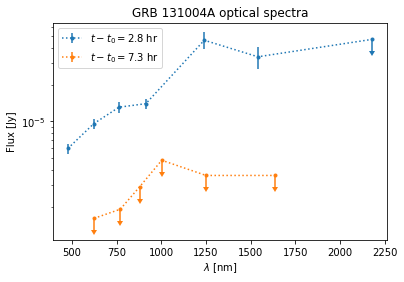

In [51]:
case = "131004A"
for time in [10080,26280]:#[55440,57903,323218]:
    data = results[(results["GRB"]==case) & (results["t_o"]==time)]
    lolims = [np.isinf(f.plus) for f in data["F_o"]]
    pos = [f.value*0.2 if np.isinf(f.plus) else f.plus for f in data["F_o"]]
    uplims = [np.isinf(f.minus) for f in data["F_o"]]
    neg = [f.value*0.2 if np.isinf(f.minus) else f.minus for f in data["F_o"]]
    val = [f.value for f in data["F_o"]]
    lam = 1e9*3e8/data["nu_o"]
    plt.errorbar(lam,val,yerr=(neg,pos),uplims=uplims,marker=".",linestyle=":",capthick=0,label=f"$t-t_0={time/3600:.1f}$ hr")
plt.legend()
plt.yscale("log")
plt.ylabel("Flux [Jy]")
plt.xlabel("$\lambda$ [nm]")
plt.title(f"GRB {case} optical spectra")
plt.savefig(f"./products/{case}_optspec.png",dpi=300,bbox_inches="tight")

## Illustrative example plot

In [31]:
pd.set_option('display.max_rows', 300)
c1 = [np.abs(B.value-0.5)<0.1 and all(np.isfinite(B.items())) for B in results[B_ox_name]]
c2 = [B.plus != B.minus for B in results["B_x"]]
truths = [c1[i] and c2[i] for i in range(len(results))]
results[truths]

GRB         t_o       dt%          nu_o  \
134   211023B     522.000  0.111783  8.514533e+14   
516   180618A     423.000  0.176039  8.514533e+14   
517   180618A     423.000  0.156016  8.514533e+14   
518   180618A     423.000  0.134894  8.514533e+14   
519   180618A     423.000  0.079489  8.514533e+14   
520   180618A     423.000  0.016343  8.514533e+14   
521   180618A     423.000  0.035403  8.514533e+14   
522   180618A     423.000  0.080343  8.514533e+14   
523   180618A     423.000  0.132041  8.514533e+14   
524   180618A     423.000  0.180374  8.514533e+14   
525   180618A     815.000  0.114644  7.715315e+14   
529   180618A     864.000  0.181660  6.897727e+14   
538   180618A    1001.000  0.189414  1.437350e+15   
540   180618A    1001.000  0.048888  1.437350e+15   
543   180618A    1074.000  0.020474  1.116903e+15   
649   180418A    3549.065  0.116439  1.334915e+15   
650   180418A    3549.065  0.066062  1.334915e+15   
651   180418A    3549.065  0.013341  1.334915e+15   
652   180418A    3549.065  0.034909  1.334915e+15   
653   180418A    3549.065  0.080625  1.334915e+15   
654   180418A    3549.065  0.130088  1.334915e+15   
655   180418A    3549.065  0.174810  1.334915e+15   
686   180418A    3754.115  0.180942  1.116903e+15   
687   180418A    3754.115  0.127654  1.116903e+15   
688   180418A    3754.115  0.071888  1.116903e+15   
689   180418A    3754.115  0.020850  1.116903e+15   
690   180418A    3754.115  0.027507  1.116903e+15   
691   180418A    3754.115  0.079828  1.116903e+15   
692   180418A    3754.115  0.127134  1.116903e+15   
693   180418A    3754.115  0.161466  1.116903e+15   
742   180418A    3958.720  0.189113  8.514533e+14   
744   180418A    3958.720  0.076487  8.514533e+14   
745   180418A    3958.720  0.025495  8.514533e+14   
747   180418A    3958.720  0.079562  8.514533e+14   
790   180418A    4370.020  0.188331  7.715315e+14   
791   180418A    4370.020  0.132042  7.715315e+14   
920   180418A  242784.000  0.017526  4.800781e+14   
1833  170728A     144.500  0.056595  7.715315e+14   
1834  170728A     144.500  0.142789  7.715315e+14   
1865  161004A     422.000  0.183353  8.514533e+14   
1875  161004A    6031.584  0.180378  4.673887e+14   
1876  161004A    6031.584  0.113015  4.673887e+14   
1967  160525B     163.000  0.170429  7.715315e+14   
2149  150424A    3490.500  0.194756  1.116903e+15   
2164  150424A    5269.000  0.111955  1.334915e+15   
2171  150424A    5269.000  0.105462  1.334915e+15   
2172  150424A    5269.000  0.166023  1.334915e+15   
2184  150424A    5371.000  0.166412  7.715315e+14   
2185  150424A    5371.000  0.133481  7.715315e+14   
2186  150424A    5371.000  0.101210  7.715315e+14   
2187  150424A    5371.000  0.068988  7.715315e+14   
2188  150424A    5371.000  0.036178  7.715315e+14   
2189  150424A    5371.000  0.003334  7.715315e+14   
2190  150424A    5371.000  0.022587  7.715315e+14   
2191  150424A    5371.000  0.049627  7.715315e+14   
2192  150424A    5371.000  0.088145  7.715315e+14   
2193  150424A    5371.000  0.149878  7.715315e+14   
2194  150424A    5371.000  0.187403  7.715315e+14   
2195  150424A    5604.000  0.182652  6.369361e+14   
2202  150424A    5604.000  0.048588  6.369361e+14   
2205  150424A    5616.000  0.185185  4.451341e+14   
2206  150424A    5616.000  0.151442  4.451341e+14   
2207  150424A    5616.000  0.117750  4.451341e+14   
2210  150424A    5616.000  0.021998  4.451341e+14   
2212  150424A    5616.000  0.046550  4.451341e+14   
2213  150424A    5616.000  0.111100  4.451341e+14   
2232  150424A    6396.000  0.194809  8.514533e+14   
2233  150424A    6396.000  0.163942  8.514533e+14   
2234  150424A    6396.000  0.131742  8.514533e+14   
2235  150424A    6396.000  0.085873  8.514533e+14   
2236  150424A    6396.000  0.012358  8.514533e+14   
2238  150424A    8481.000  0.155265  7.715315e+14   
2241  150424A   10563.000  0.052108  7.715315e+14   
2248  150424A   11320.000  0.106250  1.437350e+15   
2249  150424A   11320.000  0.069580

GRB                                                     180618A
t_o                                                       864.0
dt%                                                     0.18166
nu_o                                        689772696002300.875
F_o               0.0001503708480081596 ± 2.215946707484555e-05
nu_x          4.1880632448032506e+17 (+1.9991731172900093e+1...
F_x              3.6776658750166513e-06 ± 8.837871843211215e-07
B_ox          0.5790202965382417 (+0.08653698701715155, -0.4...
α                                                           1.0
B_ox_w_err    0.5790202965382417 (+0.11288843802922667, -0.4...
B_x                                         1.22 (+0.25, -0.23)
Jak_dark                                                  False
vdH_dark                                                  False
Year                                                       2018
Name: 529, dtype: object

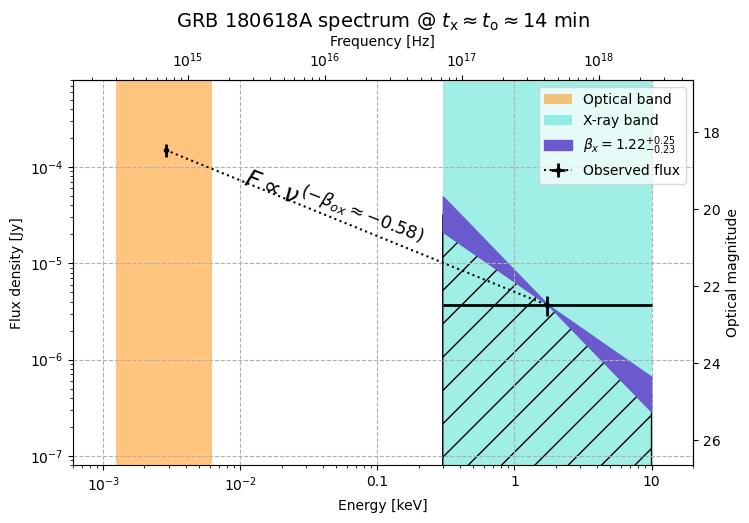

In [32]:
idx = 529
display(results.loc[idx,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
grb = results.loc[idx,"GRB"]
beta = results.loc[idx,"B_x"]
E_o = results.loc[idx,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[idx,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[idx,"F_o"]
F_x = results.loc[idx,"F_x"]
t_o = results.loc[idx,"t_o"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

fig,ax = plt.subplots(figsize=(8,5))

ax.fill_between([0.006199235,0.001239847],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
ax.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
ax.errorbar([E_o,E_x.value],[F_o.value,F_x.value],xerr=[(0,E_x.minus),(0,E_x.plus)],
             yerr=[(F_o.minus,F_x.minus),(F_o.plus,F_x.plus)],
             uplims=~np.isfinite((F_o.minus,F_x.minus)),capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
ax.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
ax.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
ax.text(1e-2,1.3e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-%.2f})}$" % results.loc[idx,B_ox_name].value,
         size=18,rotation=-21)

ax.legend(framealpha=0.75, loc="upper right")
ax.grid(linestyle="--")
ax.set_xlim(6e-4,20)
ax.set_ylim(8e-8,8e-4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([0.001,0.01,0.1,1,10])
ax.set_xticklabels(["$10^{-3}$","$10^{-2}$",0.1,1,10])
# ax.set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
ax_top = ax.secondary_xaxis("top",functions=((lambda keV:keV*Hz_per_keV),(lambda Hz:Hz/Hz_per_keV)))
ax_top.set_xlabel("Frequency [Hz]")
ax_right = ax.secondary_yaxis("right",functions=((lambda Jy:-2.5*np.log10(Jy/3631)),(lambda m:3631*10**(-m/2.5))))
ax_right.set_ylabel("Optical magnitude")
ax_right.set_yticks(range(18,27,2))
ax_right.set_yticklabels(["18","20","22","24","26"])
# ax_right.set_yscale("linear")
# ax_right.invert_yaxis()

ax.set_title(r"GRB {} spectrum".format(grb)+r" @ $t_\mathrm{x}\approx t_\mathrm{o}\approx %.0f$ min"%round(t_o/60),size=14)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux density [Jy]")
fig.savefig(f"./products/{grb}_spectrum.png",bbox_inches="tight",dpi=300)

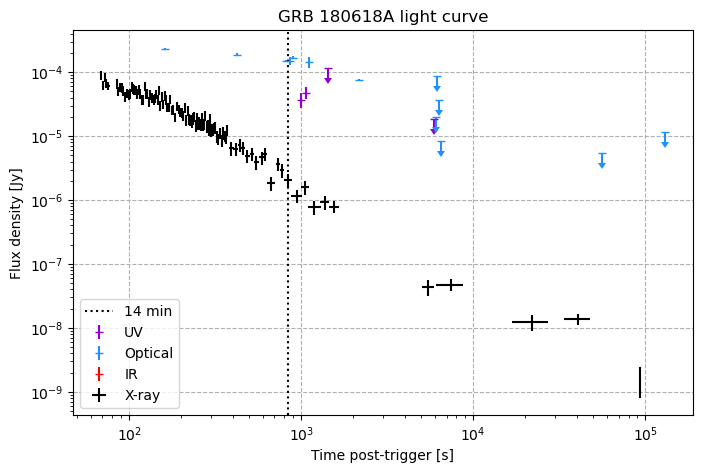

GRB     t_o       dt%  \
505  180618A   161.0  0.001487   
520  180618A   423.0  0.016343   
527  180618A   815.0  0.031596   
531  180618A   864.0  0.026627   
536  180618A   897.5  0.046156   
540  180618A  1001.0  0.048888   
543  180618A  1074.0  0.020474   
546  180618A  1112.0  0.056580   
549  180618A  1437.5  0.050929   
551  180618A  5882.5  0.071921   
552  180618A  6087.5  0.109277   
554  180618A  6190.0  0.127955   
556  180618A  6292.5  0.146632   
559  180618A  6497.5  0.124063   

                                            B_ox_w_err                  B_x  \
505  0.2701817734707163 (+0.04474859606087953, -0.2...  1.22 (+0.25, -0.23)   
520  0.5462199361034078 (+0.0818627937857624, -0.42...  1.22 (+0.25, -0.23)   
527  0.677317056166536 (+0.09773780698132033, -0.51...  1.22 (+0.25, -0.23)   
531  0.6674828969336349 (+0.09729216604542491, -0.4...  1.22 (+0.25, -0.23)   
536  0.800724408534892 (+0.11536874054817413, -0.61...  1.22 (+0.25, -0.23)   
540  0.5563424102797698 (+0.10409478164988357, -0.4...  1.22 (+0.25, -0.23)   
543  0.5759094251223985 (+0.09770079103414002, -0.4...  1.22 (+0.25, -0.23)   
546  0.6804661264558614 (+0.10004264407911767, -0.4...  1.22 (+0.25, -0.23)   
549    0.8398757950940956 (+0.12927202054024545, -inf)  1.22 (+0.25, -0.23)   
551    1.0199452356852825 (+0.15271008584954765, -inf)  1.22 (+0.25, -0.23)   
552    0.9870282975728539 (+0.14609675880156883, -inf)  1.22 (+0.25, -0.23)   
554     1.1470094712914323 (+0.1579203445903674, -inf)  1.22 (+0.25, -0.23)   
556    1.0483195418809161 (+0.15386565599251006, -inf)  1.22 (+0.25, -0.23)   
559    0.8189779366377461 (+0.12361144056492365, -inf)  1.22 (+0.25, -0.23)   

       α Jak_dark vdH_dark  
505  1.0     True     True  
520  1.0    False    False  
527  1.0    False    False  
531  1.0    False    False  
536  1.0    False    False  
540  1.0    False    False  
543  1.0    False    False  
546  1.0    False    False  
549  1.0    False    False  
551  1.0    False    False  
552  1.0    False    False  
554  1.0    False    False  
556  1.0    False    False  
559  1.0    False    False

In [35]:
    fig,ax = plt.subplots(figsize=(8,5))

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times.loc[(close_times["GRB"]==grb) & (close_times["vdH_dark"]|close_times["Jak_dark"])]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="_",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")

    ax.axvline(14*60,linestyle=":",color="k",label="14 min")
    ax.set(xscale="log",yscale="log",xlabel="Time post-trigger [s]",ylabel="Flux density [Jy]")
    tmin,tmax = ax.get_xlim()
    ax.legend()
    ax.grid(linestyle="--")
    ax.set_title(f"GRB {grb} light curve")
    
    fig.savefig(f"./products/{grb}_LC.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()
    display(close_times.loc[close_times["GRB"]==grb,["GRB","t_o","dt%",B_ox_name,"B_x","α","Jak_dark","vdH_dark"]])

## To-do

- compare $\beta_x$ distributions between vdH/Jakobsson dark bursts
    - dark between each method
    - dark vs non-dark for each method
- for dark but have optical detections, estimate extinctions ($A_v$)
    - if $\beta_x = \beta_{ox}$ (straight spectrum)
    - if it is -0.5 (assumed dark)
- $N_H$ vs. $\beta_{ox}$ plot and vs. $A_v$
- distribution of $N_H$: are dark mostly at the high end?
- deepest observation of each GRB over time -- have we gotten better at chasing them?
    - some indicator of how early we catch them?
    - at what time are GRBs dark?
- where are my early-time observations from? 
    - check David's tables
    - check Rastinejad, Fong sources
- interpolate XRT light curve to make data matches: does that get us more dark bursts?

### Project status

- finalize 'quantification' of early-time behavior (uninterestingly dark)
    - extra emission in xrays that makes it technically dark but not in the way we care about
- table: total # of sGRBs, # with xray detections, # with optical followup, # with temporally matched (at multiple % values), # dark, # interestingly dark
- fraction is # interestinly dark out of # with optical observations
    - different aspects to this: influence of using big telescopes, getting on it early, progress over the years, etc.
- of the ones that are interestingly dark, what can we say?
- 

### Paper structure
- GRBs two flavors: long/short
- shortly after discovery of afterglow, there were some that were optically dark. even in very fast followup there were some that were not found $\to$ led to classfication scheme for optical darkness where we quantify what we expect to see in optical based on xray. two methods based on what we expect from synchotron spectrum $\to p$. in long GRBs significant fraction due to host galaxy extinction, redshift, extra emission, etc. hasn't been done systematically for sGRBs. that's what we do here
- drill down to these are the interesting ones
- 2 part discussion: darkness in individual GRBs and then darkness in the short GRB population
    - darkness rate, comparison to long GRBs, what makes certain ones dark (characteristics), has rate changed over time
- properties of those and population as a whole in terms of stuff